In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix, roc_auc_score

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
# load dataset containing sex and participant id
df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
df

Unnamed: 0   V1  index  Subject  Age_in_Yrs  Gender  HasGT ZygositySR  \
0           156  170    206   152831          29       0      1    NotTwin   
1           266  385    462   248339          26       0      1      NotMZ   
2           152  429    515   329440          30       0      1    NotTwin   
3           511  717    854   952863          23       1      1    NotTwin   
4           410  267    316   180533          31       1      1         MZ   
..          ...  ...    ...      ...         ...     ...    ...        ...   
441         188  299    351   191942          27       0      1    NotTwin   
442          94   46     56   114419          33       0      1    NotTwin   
443          44  650    774   814649          29       0      1      NotMZ   
444          51  314    370   196346          27       0      1    NotTwin   
445         189  357    429   211619          27       0      1    NotTwin   

    ZygosityGT    Family_ID  ...  Noise_Comp  Odor_Unadj  Odor_AgeAdj  \
0          NaN  51969_81833  ...         5.2      108.79        98.04   
1           DZ  55787_85608  ...         3.6       96.87        77.12   
2          NaN  51348_81213  ...         6.0      108.79        98.04   
3          NaN  52968_82790  ...         5.2      101.12        86.45   
4           MZ  56127_85947  ...         6.0      101.12        87.11   
..         ...          ...  ...         ...         ...          ...   
441        NaN  56029_85850  ...         3.6      122.25       110.45   
442        NaN  52872_82694  ...         2.8      108.79        98.04   
443         DZ  52298_82161  ...         6.8      108.79        97.19   
444        NaN  55943_85763  ...         2.8      101.12        86.45   
445        NaN  53288_83110  ...         2.8       93.38        69.88   

    PainIntens_RawScore PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  \
0                   0.0              52.2        86.03         84.40   
1                   2.0              51.1        86.03         86.60   
2                   1.0              46.1        97.69         96.97   
3                   1.0              44.1       112.45        112.57   
4                   0.0              38.6        95.36         93.48   
..                  ...               ...          ...           ...   
441                 0.0              38.6        74.81         73.21   
442                 3.0              38.6        79.67         77.45   
443                 4.0              44.1        76.41         75.05   
444                 0.0              38.6        88.02         87.70   
445                 3.0              38.6       106.39        104.39   

     Mars_Log_Score  Mars_Errs  Mars_Final  
0              1.80        0.0        1.80  
1              1.92        1.0        1.88  
2              1.76        0.0        1.76  
3              1.92        0.0        1.92  
4              1.88        1.0        1.84  
..              ...        ...         ...  
441            1.80        0.0        1.80  
442            1.84        1.0        1.80  
443            1.80        0.0        1.80  
444            1.80        0.0        1.80  
445            1.92        1.0        1.88  

[446 rows x 586 columns]

In [3]:
print("hommes = ", df["Gender"].value_counts()[0])
print("femmes = ", df["Gender"].value_counts()[1])

hommes =  220
femmes =  226


In [4]:
average_age_men = round(df[df["Gender"]== 0]["Age_in_Yrs"].mean(),1)
average_age_men


27.9

In [5]:
average_age_women = round(df[df["Gender"]== 1]["Age_in_Yrs"].mean(),1)
average_age_women


28.3

In [6]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    # TODO le path des atlas a changer, à confirmer
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in df["Subject"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

In [7]:
df_boot = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
x_correl = []
for sub in tqdm(df_boot["Subject"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


100%|██████████████████████████████████████| 446/446 [00:00<00:00, 46509.52it/s]


# Define function

In [8]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [9]:
def bestRegion(ROIs, data_dict, data_df):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi =[]

    # Might be better, but not completed
#     seed_label = list(best["seed"]+"_"+best["labels"])
    
#     index = []
#     for i in seed_label:
#         index.append((i, "male", "female"))
    
#     index = pd.MultiIndex.from_tuples(index)
    
    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []
    
    mask = data_df["Gender"] == 0
    label_male = np.array(data_df[mask]["Subject"])
    label_female = np.array(data_df[~mask]["Subject"])
        
        
    for i in data_dict.keys():
        if i[0] in label_male:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif i[0] in label_female:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("male std : " + str(np.std(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        print("female std : " + str(np.std(best_roi[i][3])))
        pd.concat([table_best, pd.DataFrame([{'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}])], ignore_index=True)
        # table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
        #                                 'Men' : np.mean(best_roi[i][2]), 
        #                                 'Women' : np.mean(best_roi[i][3]), 
        #                                 'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

In [10]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [11]:
def compute_results(results_path):
    results = joblib.load(results_path)

    coefs = []
    for result in results:
        coefs.append(result["model"].coef_[0])

    coefs = np.array(coefs)

    data_results = pd.DataFrame.from_dict(results)
    moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
    return moyenne, scoresZ, pvalue_bonf, data_results

In [12]:
def sensitivity_specificity(confusion_matrix):
    sensitivity = confusion_matrix["Femme"][0] / (confusion_matrix["Femme"][0] + confusion_matrix["Femme"][1])
    specificity = confusion_matrix['Homme'][1] / (confusion_matrix["Homme"][1] + confusion_matrix["Homme"][0])
    return sensitivity, specificity

## Define data path to each model results

In [13]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"


# Best region with grey matter corrected

In [14]:
# fetching label from destrieux atlas minus two labels not used
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

## Best regions all seed

     coefficient          seed                       labels
53      0.071998       opIFG_L                L S_front_sup
98      0.068703       opIFG_L       R G_pariet_inf-Angular
305     0.067761        aMTG_L      L G_cingul-Post-ventral
4       0.062096       opIFG_L   L G_and_S_transv_frontopol
351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
379     0.055342        aMTG_L      R G_cingul-Post-ventral
421     0.054767        aMTG_L                R S_front_inf
189     0.053099  planumtemp_L             L Pole_occipital
301     0.052427        aMTG_L         L G_and_S_cingul-Ant
431     0.051413        aMTG_L          R S_orbital_lateral
The mean accuracy : 0.908557777777778
The standard deviation of the accuracy : 0.03230256642328694
The lower boundry of the confidance interval of the accuracy : 0.8452447475881356
The upper boundry of the confidance interval of the accuracy : 0.9718708079674204
Mean sensitivity : 0.9072061866247968 Std sensitivity : 0.04202736982884448
M

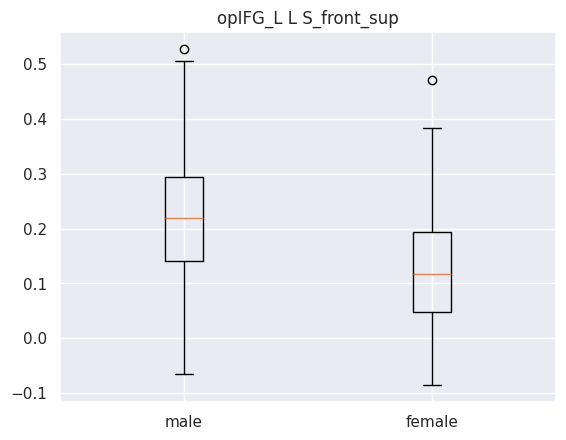

TtestResult(statistic=9.514226955534408, pvalue=1.1745948061525577e-19, df=444.0)
male mean : 0.22193633239999996
male std : 0.11249626112199279
female mean : 0.12588911007571682
female std : 0.10000267392277586


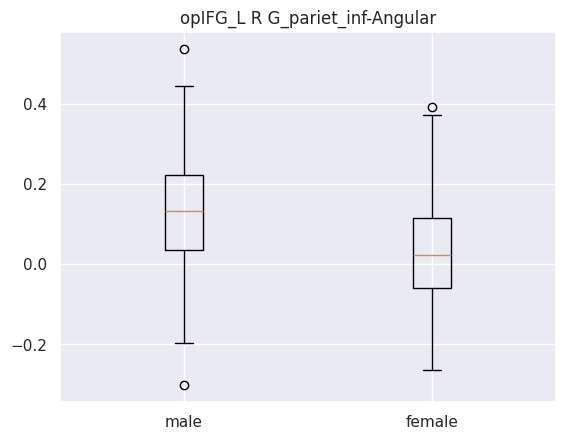

TtestResult(statistic=7.24780487230096, pvalue=1.8918423767886693e-12, df=444.0)
male mean : 0.12424016548681818
male std : 0.13424300726761648
female mean : 0.03453558849026549
female std : 0.1265180924203619


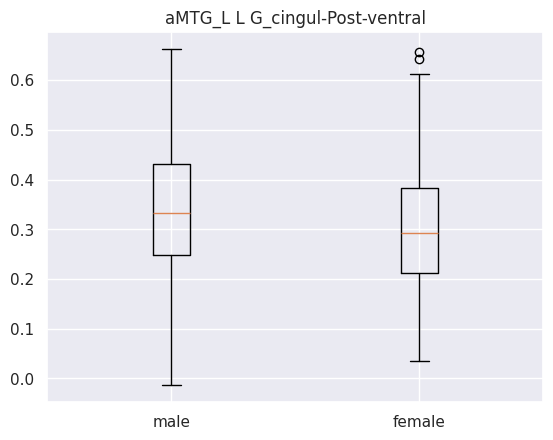

TtestResult(statistic=2.7358247046655375, pvalue=0.006471799539479473, df=444.0)
male mean : 0.3344936346227273
male std : 0.12852301357983476
female mean : 0.30081479229646013
female std : 0.1308069984904627


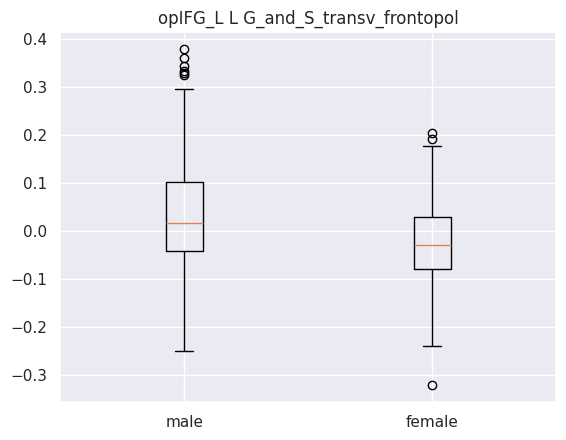

TtestResult(statistic=5.033838587916691, pvalue=6.999625036984745e-07, df=444.0)
male mean : 0.025597121174999998
male std : 0.11515068596736391
female mean : -0.023709215497699117
female std : 0.09002691208082556


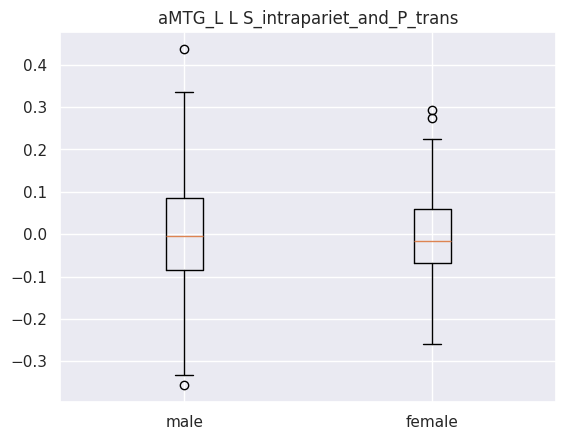

TtestResult(statistic=1.0441439448576817, pvalue=0.29698694253266955, df=444.0)
male mean : 0.004413317491818183
male std : 0.12667357592144304
female mean : -0.006823133387610619
female std : 0.09870796418027704


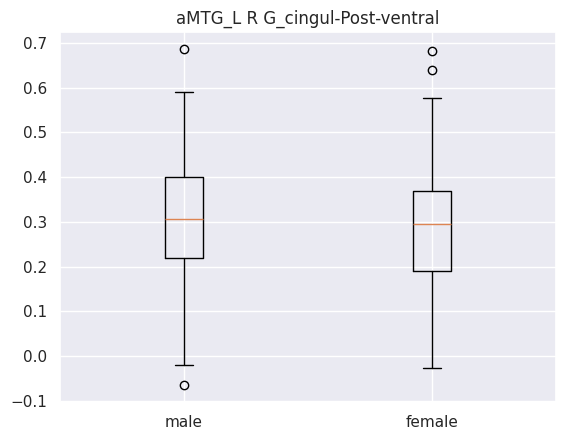

TtestResult(statistic=1.8738792848668957, pvalue=0.06160360622903291, df=444.0)
male mean : 0.30625412715000006
male std : 0.13256098239856265
female mean : 0.28295946666194693
female std : 0.12938146719020743


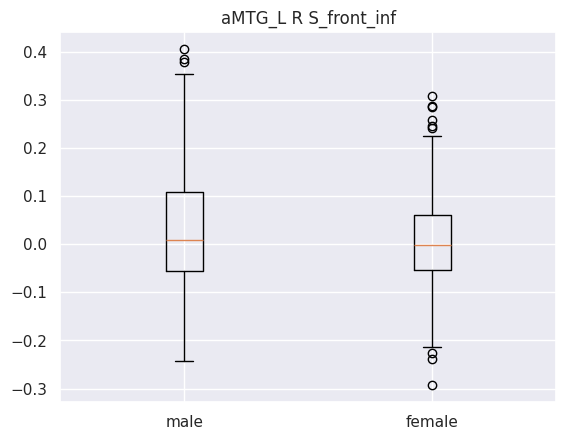

TtestResult(statistic=1.9193910426129293, pvalue=0.055575465964615225, df=444.0)
male mean : 0.025140619681999998
male std : 0.12506768589238804
female mean : 0.004515161334216815
female std : 0.10031688528841444


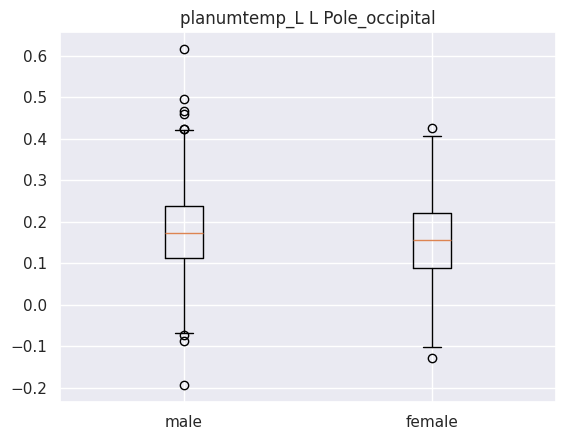

TtestResult(statistic=2.8966477425742636, pvalue=0.003958114551412912, df=444.0)
male mean : 0.18402248281818182
male std : 0.11334589412846845
female mean : 0.1545630971402655
female std : 0.10073153762994376


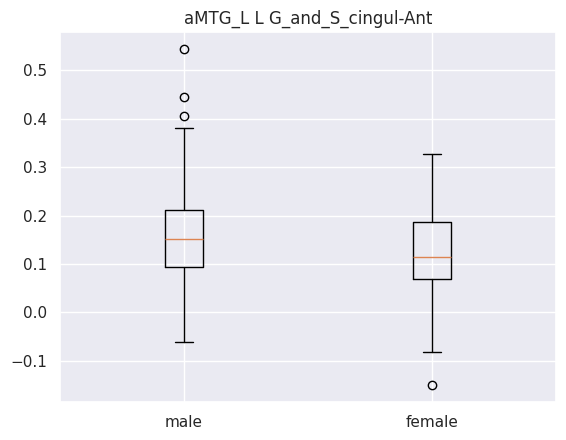

TtestResult(statistic=4.307060944860257, pvalue=2.038136442014065e-05, df=444.0)
male mean : 0.16099100311954548
male std : 0.0980609784038807
female mean : 0.1242215932681416
female std : 0.08124741946330903


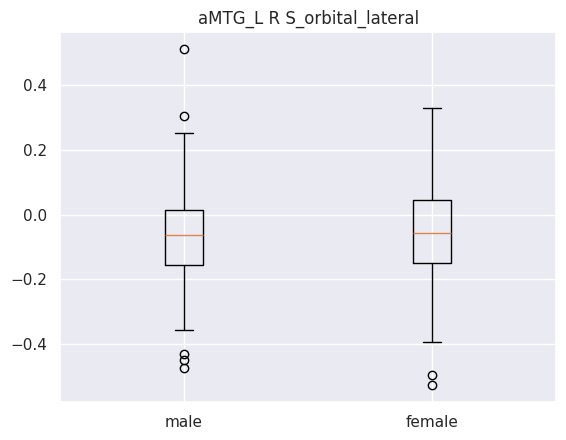

TtestResult(statistic=-0.9595545169231156, pvalue=0.337801699063937, df=444.0)
male mean : -0.06771869820213636
male std : 0.14263363470452184
female mean : -0.05464536117588496
female std : 0.14439482773638504
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [15]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)


## Best regions for aMTG_L

     coefficient    seed                       labels
53      0.281044  aMTG_L                L S_front_sup
98      0.250923  aMTG_L       R G_pariet_inf-Angular
131     0.183568  aMTG_L   R S_oc_sup_and_transversal
22      0.180551  aMTG_L      L G_oc-temp_med-Parahip
4       0.175986  aMTG_L   L G_and_S_transv_frontopol
104     0.173773  aMTG_L                   R G_rectus
103     0.168947  aMTG_L                R G_precuneus
55      0.166147  aMTG_L  L S_intrapariet_and_P_trans
66      0.158217  aMTG_L              L S_postcentral
87      0.149105  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.8202100000000002
The standard deviation of the accuracy : 0.042053908363456245
The lower boundry of the confidance interval of the accuracy : 0.737784339607626
The upper boundry of the confidance interval of the accuracy : 0.9026356603923744
Mean sensitivity : 0.8154806899097619 Std sensitivity : 0.05005300041329873
Mean specificity : 0.8303861582136113 Std specificity : 0.05303873

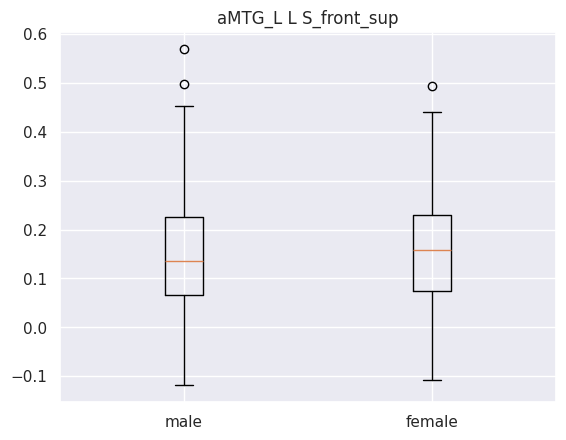

TtestResult(statistic=-0.9406515856219914, pvalue=0.3473949131207905, df=444.0)
male mean : 0.149155713895
male std : 0.12215414677633321
female mean : 0.15968833962980092
female std : 0.1137261077832309


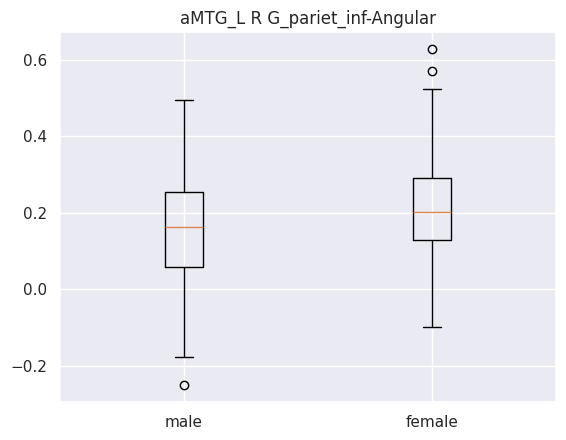

TtestResult(statistic=-3.9493086257770935, pvalue=9.112915695993898e-05, df=444.0)
male mean : 0.1597038146640909
male std : 0.14141209184423478
female mean : 0.20934205392477875
female std : 0.12301362367570179


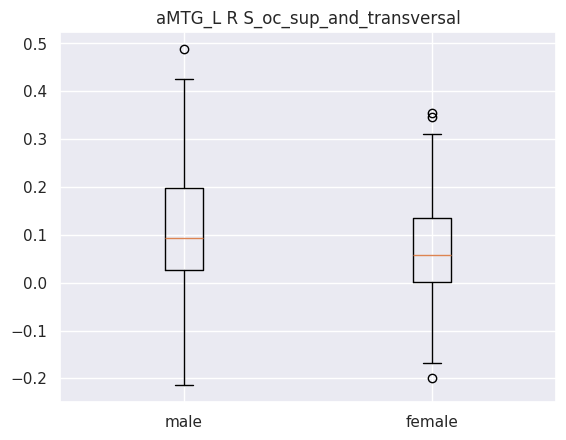

TtestResult(statistic=3.5613990096675714, pvalue=0.0004087562486128332, df=444.0)
male mean : 0.10625280339390909
male std : 0.12637717435553078
female mean : 0.06767066309955752
female std : 0.10078149226010065


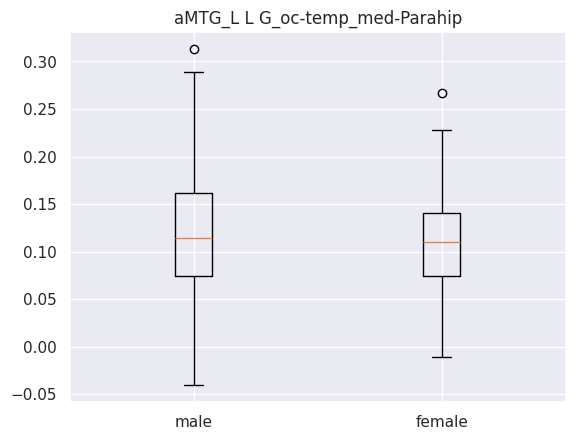

TtestResult(statistic=2.6168014548691065, pvalue=0.00917858413141157, df=444.0)
male mean : 0.12139309023636362
male std : 0.05894973262885631
female mean : 0.10806080625663717
female std : 0.04798219271826174


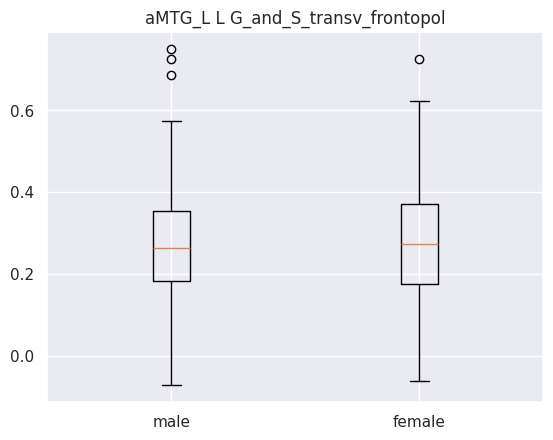

TtestResult(statistic=-0.13187058202998522, pvalue=0.8951463929773453, df=444.0)
male mean : 0.2736758421272727
male std : 0.13376710268148156
female mean : 0.2753599954026549
female std : 0.13529084478562486


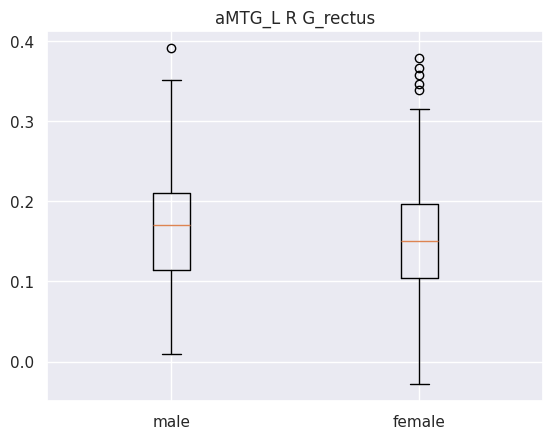

TtestResult(statistic=1.5156403489067496, pvalue=0.1303218993854485, df=444.0)
male mean : 0.1657639553590909
male std : 0.0682223379382807
female mean : 0.15580128479203542
female std : 0.07023035925739472


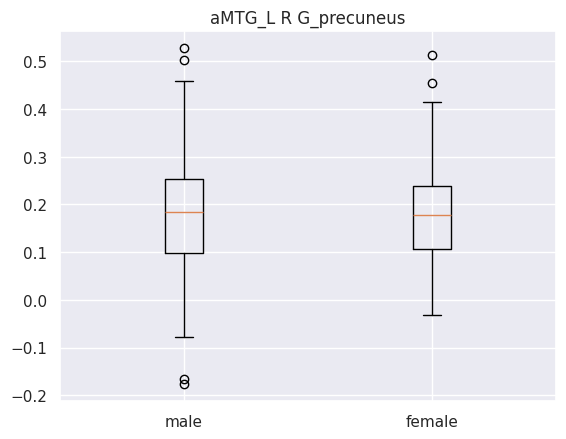

TtestResult(statistic=0.20836146513744597, pvalue=0.8350422894528916, df=444.0)
male mean : 0.1794498914168182
male std : 0.11811792236708751
female mean : 0.17732722280000002
female std : 0.09564836134166617


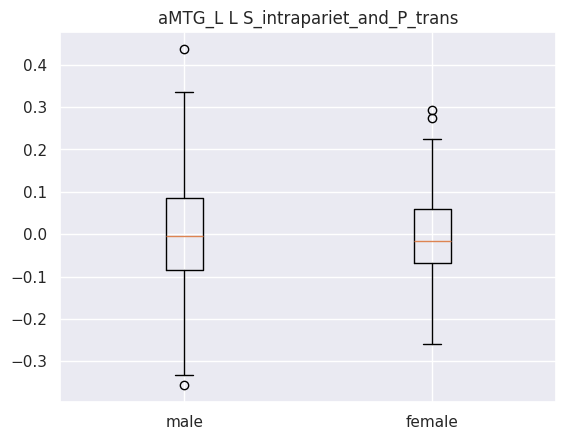

TtestResult(statistic=1.0441439448576817, pvalue=0.29698694253266955, df=444.0)
male mean : 0.004413317491818183
male std : 0.12667357592144304
female mean : -0.006823133387610619
female std : 0.09870796418027704


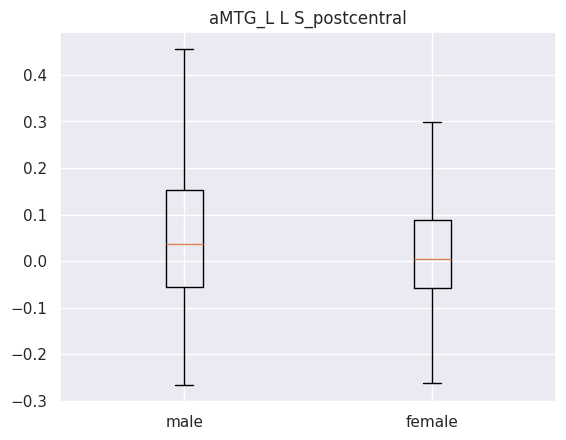

TtestResult(statistic=2.4484128219617074, pvalue=0.01473464302856492, df=444.0)
male mean : 0.04535718950954546
male std : 0.14137947053259706
female mean : 0.01543427044787611
female std : 0.11512896698383501


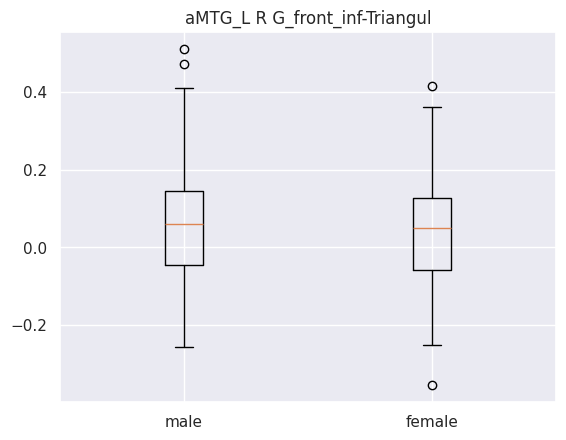

TtestResult(statistic=0.8029229066384681, pvalue=0.42244888658810364, df=444.0)
male mean : 0.05413531161409091
male std : 0.14048142342875752
female mean : 0.04356582297920354
female std : 0.13689628286994152
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [16]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions aMTG_R

     coefficient    seed                       labels
66      0.235741  aMTG_R              L S_postcentral
53      0.235184  aMTG_R                L S_front_sup
22      0.215506  aMTG_R      L G_oc-temp_med-Parahip
98      0.214273  aMTG_R       R G_pariet_inf-Angular
55      0.196734  aMTG_R  L S_intrapariet_and_P_trans
96      0.173958  aMTG_R      R G_oc-temp_med-Parahip
4       0.162914  aMTG_R   L G_and_S_transv_frontopol
77      0.149204  aMTG_R         R G_and_S_subcentral
131     0.146683  aMTG_R   R S_oc_sup_and_transversal
90      0.130523  aMTG_R    R G_Ins_lg_and_S_cent_ins
The mean accuracy : 0.8109111111111114
The standard deviation of the accuracy : 0.043558497633061015
The lower boundry of the confidance interval of the accuracy : 0.7255364557503118
The upper boundry of the confidance interval of the accuracy : 0.8962857664719109
Mean sensitivity : 0.8088480095877181 Std sensitivity : 0.051696829941751885
Mean specificity : 0.818307480321062 Std specificity : 0.0536930

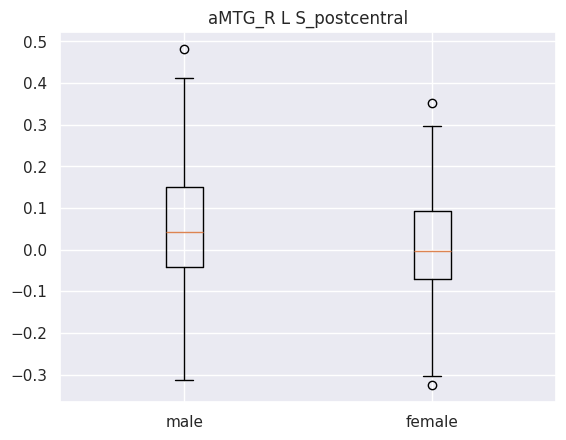

TtestResult(statistic=2.627621292338559, pvalue=0.008896140355824254, df=444.0)
male mean : 0.04901591075681818
male std : 0.13953276104441498
female mean : 0.016055526186592915
female std : 0.12453371759228786


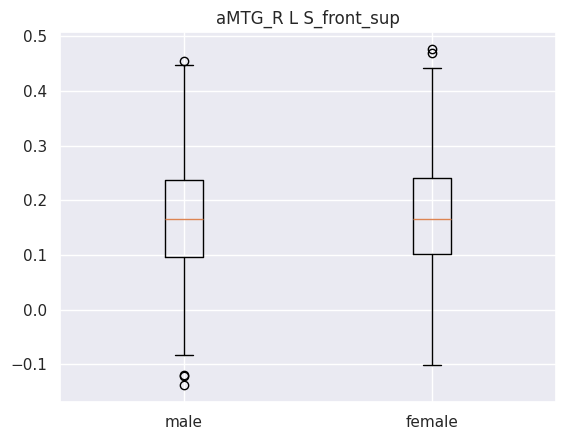

TtestResult(statistic=-0.08008365126456747, pvalue=0.9362068082925741, df=444.0)
male mean : 0.17175187354863636
male std : 0.11338550789442398
female mean : 0.1725857526397788
female std : 0.10597629980410962


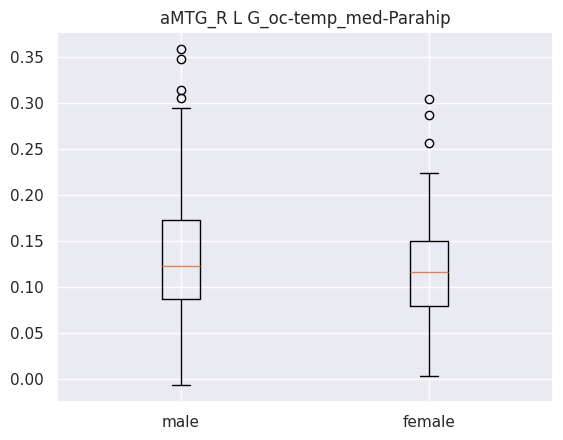

TtestResult(statistic=2.839191497277654, pvalue=0.004730402487154351, df=444.0)
male mean : 0.13388492833
male std : 0.06366889431603796
female mean : 0.11838812058539823
female std : 0.05078064169079939


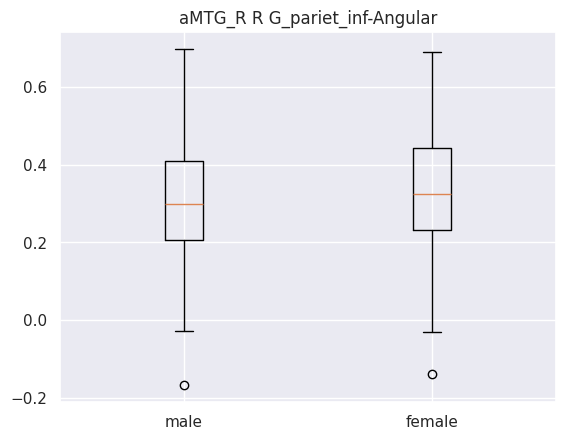

TtestResult(statistic=-1.2323437014086307, pvalue=0.21847289401376063, df=444.0)
male mean : 0.30850017917
male std : 0.1509961278933057
female mean : 0.3258114792300885
female std : 0.14499535619579842


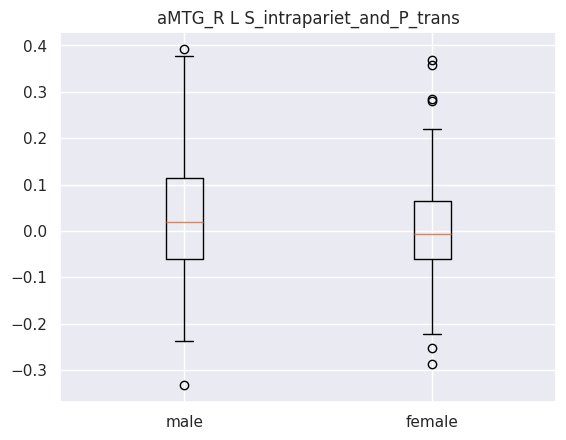

TtestResult(statistic=2.0033433133727625, pvalue=0.0457476860349034, df=444.0)
male mean : 0.02404788690863636
male std : 0.12464427867043203
female mean : 0.0021809927742920342
female std : 0.10473721060141471


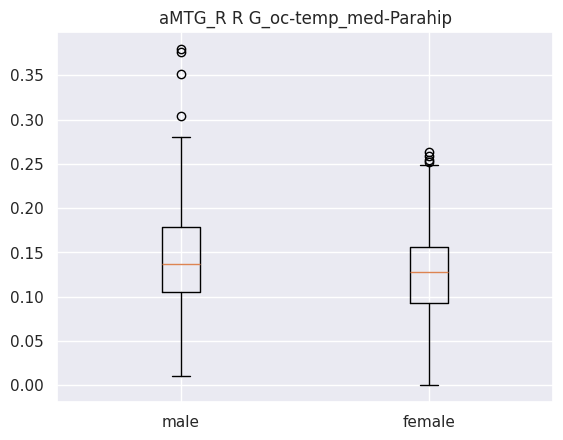

TtestResult(statistic=3.2230120586916766, pvalue=0.0013619508370199724, df=444.0)
male mean : 0.14602855690909092
male std : 0.06277541821437044
female mean : 0.1286269260214602
female std : 0.050481361154379095


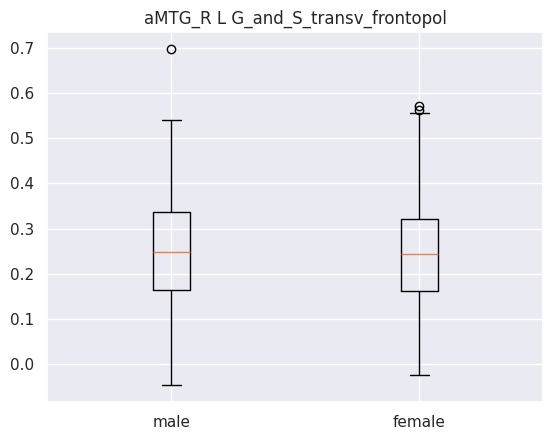

TtestResult(statistic=0.7806963776760073, pvalue=0.43539711360071087, df=444.0)
male mean : 0.25175311356636365
male std : 0.12076507584294517
female mean : 0.2429040562159292
female std : 0.11807395115490585


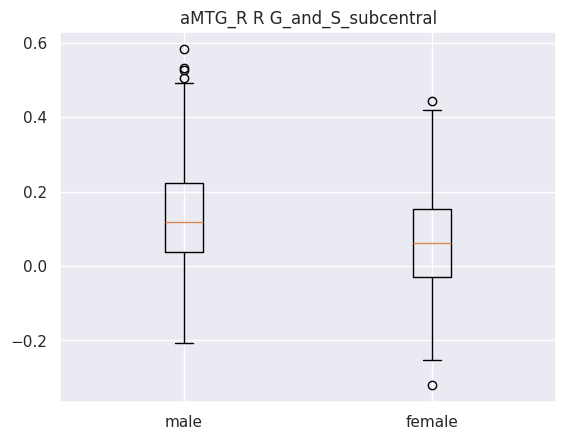

TtestResult(statistic=4.062267488891093, pvalue=5.7460358444403454e-05, df=444.0)
male mean : 0.12416156709794092
male std : 0.1454961305113495
female mean : 0.0702078637039823
female std : 0.13426643484180018


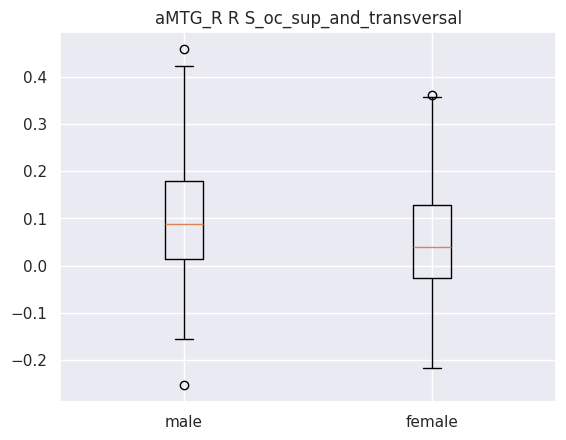

TtestResult(statistic=4.231939532641933, pvalue=2.8164514848048607e-05, df=444.0)
male mean : 0.10353396476636365
male std : 0.1292749411740477
female mean : 0.05450852847345132
female std : 0.1145602710940684


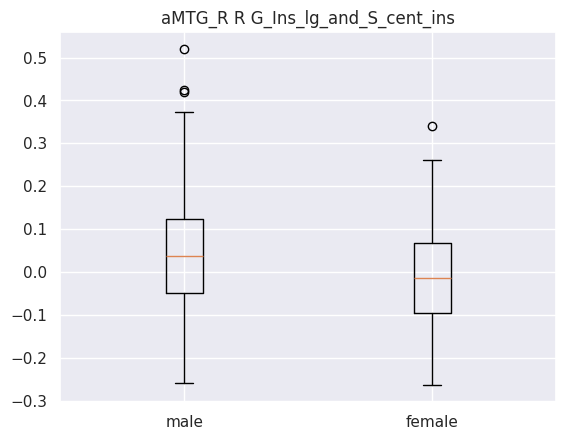

TtestResult(statistic=4.494099754685952, pvalue=8.92418981107013e-06, df=444.0)
male mean : 0.0445266324765
male std : 0.12931193503968358
female mean : -0.007410436407079646
female std : 0.11390051576344988
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [17]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_L

     coefficient     seed                       labels
125     0.202689  opIFG_L                R S_front_inf
20      0.200376  opIFG_L      L G_oc-temp_lat-fusifor
35      0.190572  opIFG_L      L G_temp_sup-Plan_tempo
144     0.189744  opIFG_L              R S_subparietal
91      0.188180  opIFG_L            R G_insular_short
79      0.158492  opIFG_L         R G_and_S_cingul-Ant
60      0.157379  opIFG_L  L S_oc-temp_med_and_Lingual
89      0.151293  opIFG_L                R G_front_sup
72      0.150238  opIFG_L             L S_temporal_sup
9       0.147801  opIFG_L      L G_cingul-Post-ventral
The mean accuracy : 0.8472244444444444
The standard deviation of the accuracy : 0.03985312534795734
The lower boundry of the confidance interval of the accuracy : 0.769112318762448
The upper boundry of the confidance interval of the accuracy : 0.9253365701264409
Mean sensitivity : 0.8420658930947892 Std sensitivity : 0.04859285455967222
Mean specificity : 0.857698111507087 Std specificity : 0

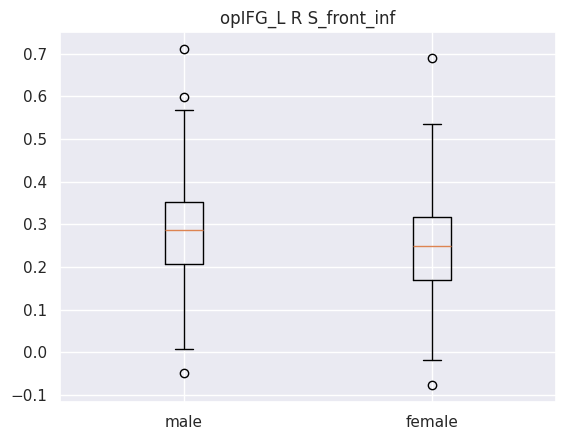

TtestResult(statistic=3.835811545215277, pvalue=0.0001432689580451875, df=444.0)
male mean : 0.2851604080318182
male std : 0.11340294993333086
female mean : 0.24395864221681413
female std : 0.11291671921913636


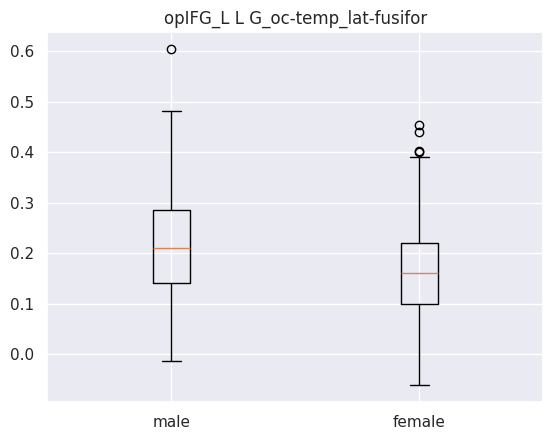

TtestResult(statistic=5.347205581276891, pvalue=1.4323542479964458e-07, df=444.0)
male mean : 0.21720834137113634
male std : 0.10505156622836234
female mean : 0.1665263415774336
female std : 0.09451242193790162


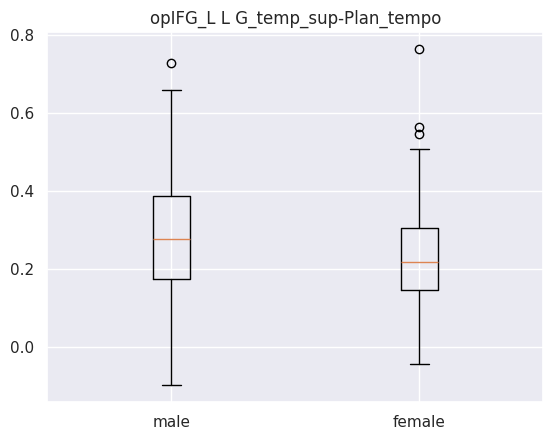

TtestResult(statistic=4.658112093864058, pvalue=4.223278693577736e-06, df=444.0)
male mean : 0.2863882349772728
male std : 0.14948277729148243
female mean : 0.22649747706194692
female std : 0.12022186901150231


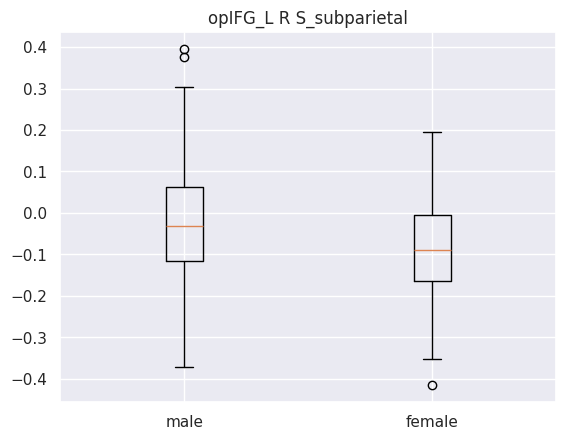

TtestResult(statistic=4.609312989745705, pvalue=5.2885387407695605e-06, df=444.0)
male mean : -0.024811179274522723
male std : 0.14365742689954286
female mean : -0.08184163840840707
female std : 0.1159257812279483


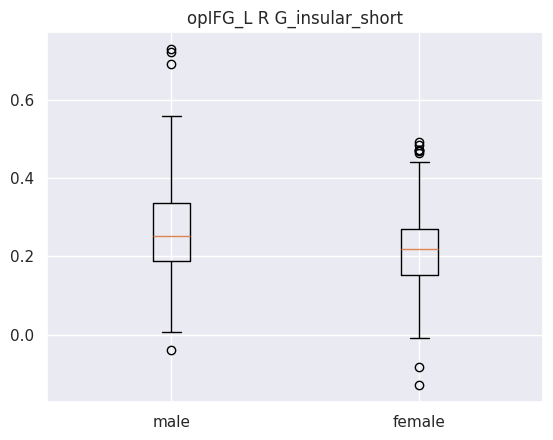

TtestResult(statistic=4.228696451103205, pvalue=2.855749277590576e-05, df=444.0)
male mean : 0.2642323993227273
male std : 0.12153962695267223
female mean : 0.21892150578761063
female std : 0.10375910549235366


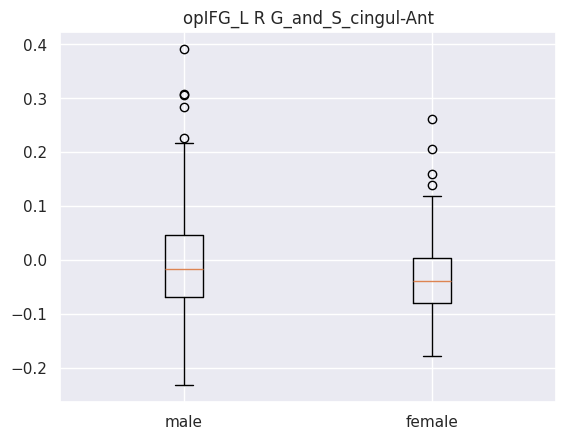

TtestResult(statistic=3.464665320247692, pvalue=0.0005824633674892333, df=444.0)
male mean : -0.006062558034272728
male std : 0.09768015129495845
female mean : -0.033554106136725666
female std : 0.0670920200770204


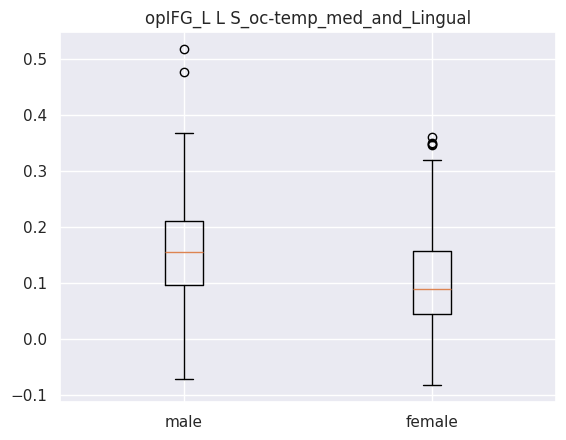

TtestResult(statistic=5.608872459876942, pvalue=3.5868373548282604e-08, df=444.0)
male mean : 0.15474476261090905
male std : 0.09145221886246907
female mean : 0.10766764768845133
female std : 0.08536736636712615


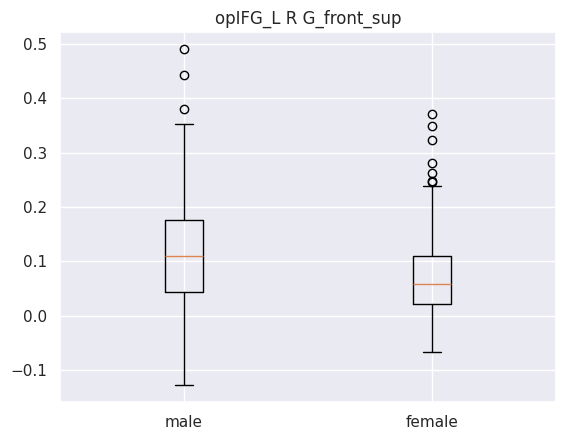

TtestResult(statistic=5.637293911515764, pvalue=3.0760252455572435e-08, df=444.0)
male mean : 0.11798845308907728
male std : 0.10117311695046627
female mean : 0.07026109567020353
female std : 0.07572629349379853


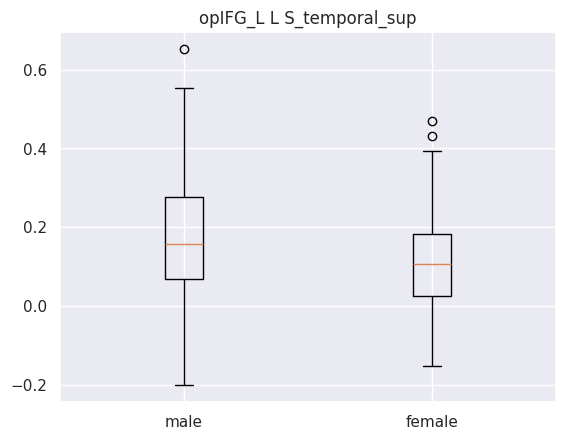

TtestResult(statistic=4.986420632756741, pvalue=8.837798072236852e-07, df=444.0)
male mean : 0.17709827854295454
male std : 0.14528631593413507
female mean : 0.11401556901061947
female std : 0.12043399442961387


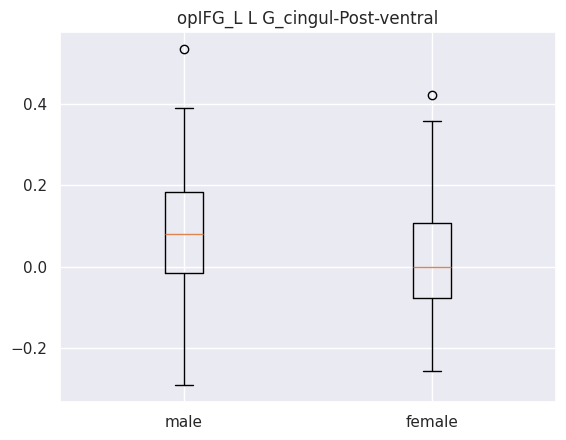

TtestResult(statistic=5.084136311641698, pvalue=5.454955637828819e-07, df=444.0)
male mean : 0.08083275604595454
male std : 0.1405096922901904
female mean : 0.018020681705044245
female std : 0.11920621954418258
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [18]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_R

     coefficient     seed                       labels
125     0.234703  opIFG_R                R S_front_inf
80      0.224280  opIFG_R     R G_and_S_cingul-Mid-Ant
91      0.181864  opIFG_R            R G_insular_short
144     0.168338  opIFG_R              R S_subparietal
20      0.165930  opIFG_R      L G_oc-temp_lat-fusifor
90      0.165617  opIFG_R    R G_Ins_lg_and_S_cent_ins
41      0.161333  opIFG_R             L Pole_occipital
117     0.152971  opIFG_R                R S_calcarine
63      0.152894  opIFG_R         L S_orbital-H_Shaped
60      0.151867  opIFG_R  L S_oc-temp_med_and_Lingual
The mean accuracy : 0.8309533333333334
The standard deviation of the accuracy : 0.04169986582564197
The lower boundry of the confidance interval of the accuracy : 0.7492215963150752
The upper boundry of the confidance interval of the accuracy : 0.9126850703515916
Mean sensitivity : 0.8322554230578544 Std sensitivity : 0.050887627795741186
Mean specificity : 0.8347027848251469 Std specificity 

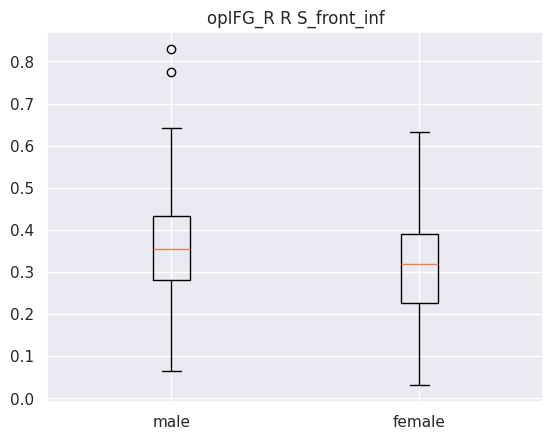

TtestResult(statistic=3.9946084585433304, pvalue=7.584042967238988e-05, df=444.0)
male mean : 0.36241775419090916
male std : 0.11709006437871611
female mean : 0.31739422023451325
female std : 0.12031934666421866


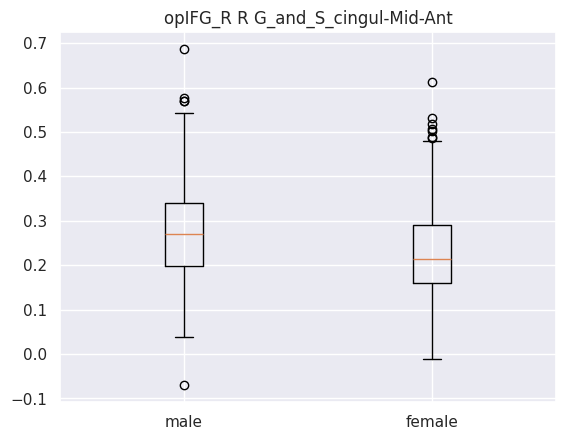

TtestResult(statistic=3.964127034948002, pvalue=8.583233085828756e-05, df=444.0)
male mean : 0.2759169506818182
male std : 0.11781973016961253
female mean : 0.2327772969358407
female std : 0.1114656795348218


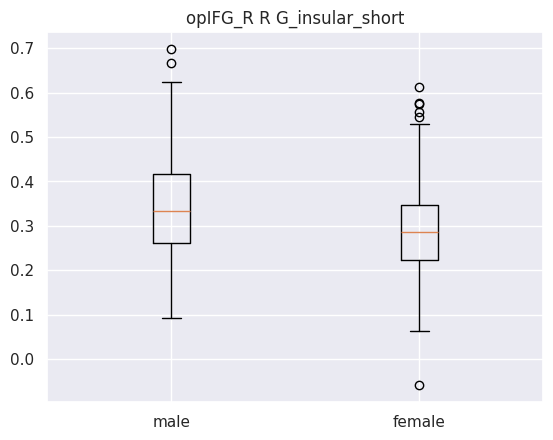

TtestResult(statistic=4.5606645152083, pvalue=6.6049251869165826e-06, df=444.0)
male mean : 0.34029636559545456
male std : 0.11365052713646152
female mean : 0.2927324357035398
female std : 0.10605668848768768


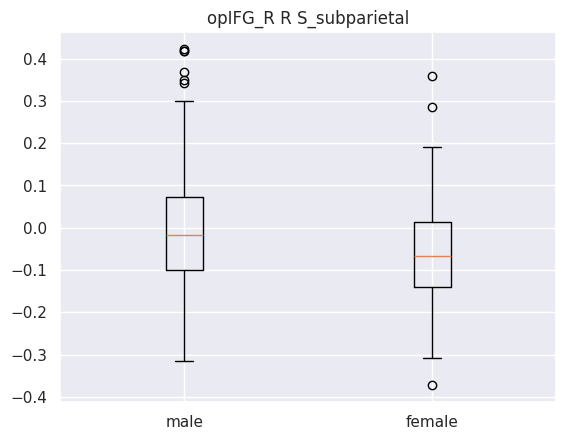

TtestResult(statistic=4.342181044945235, pvalue=1.749268283550659e-05, df=444.0)
male mean : -0.008883466066818179
male std : 0.14428559820039927
female mean : -0.06175231570632744
female std : 0.11046401972822666


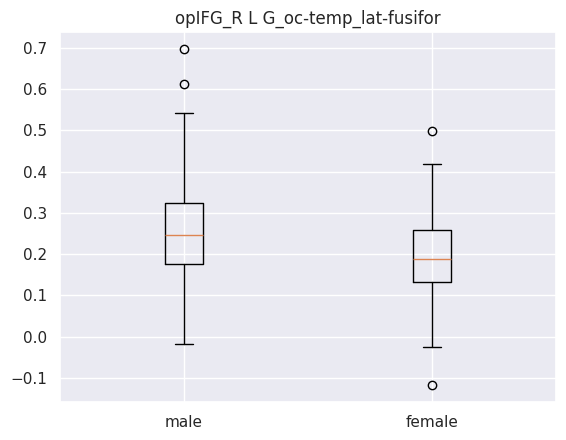

TtestResult(statistic=5.192733430788187, pvalue=3.162104238851161e-07, df=444.0)
male mean : 0.24746643591363637
male std : 0.1114361981429399
female mean : 0.1962682065265487
female std : 0.095928572655737


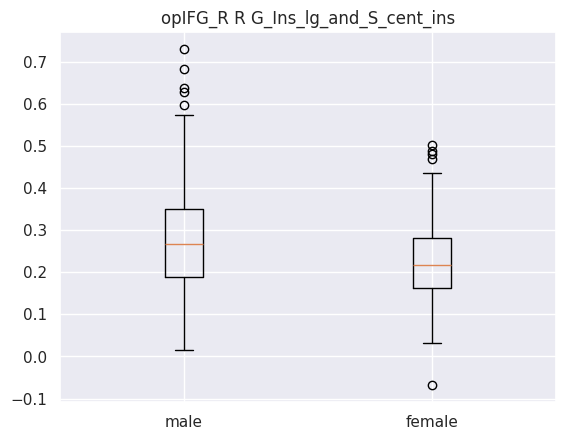

TtestResult(statistic=4.719580637797441, pvalue=3.1723919963938446e-06, df=444.0)
male mean : 0.2733611874181818
male std : 0.12407207041222522
female mean : 0.22280797660176993
female std : 0.1007125264660346


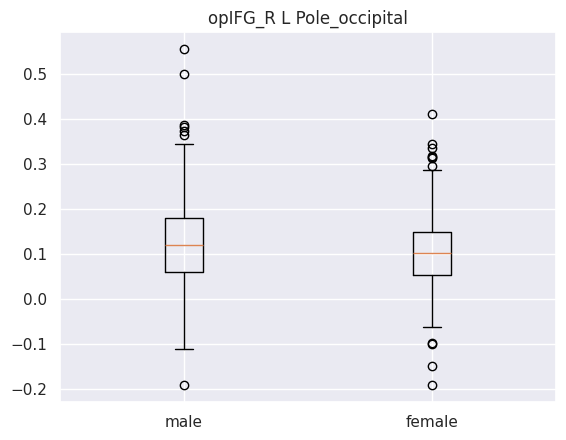

TtestResult(statistic=1.9668569199465695, pvalue=0.049822028600582956, df=444.0)
male mean : 0.1226511061215
male std : 0.10336637927130211
female mean : 0.10500797782699114
female std : 0.08498185574097446


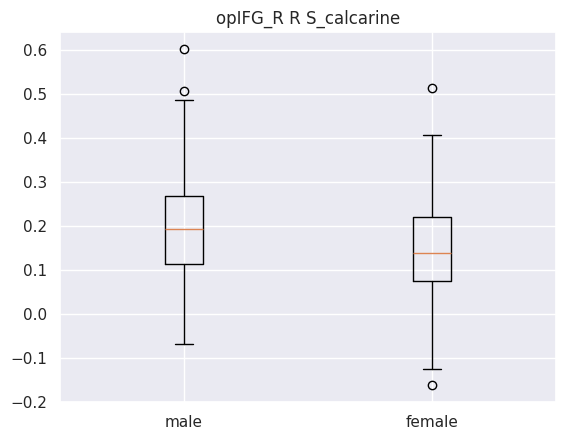

TtestResult(statistic=4.237827850565027, pvalue=2.7464151972045144e-05, df=444.0)
male mean : 0.19217596783045457
male std : 0.11294197663986946
female mean : 0.14892272028761064
female std : 0.10196970971881396


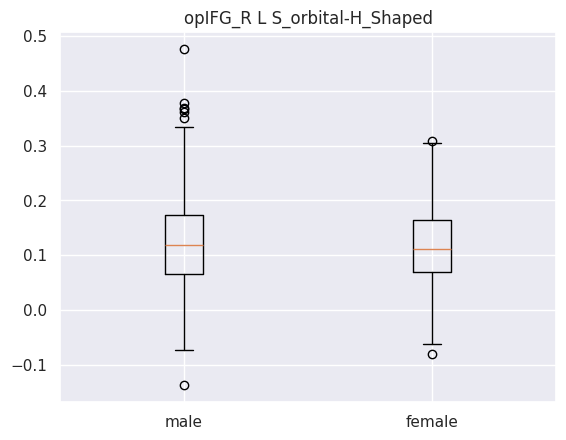

TtestResult(statistic=0.8561324777791736, pvalue=0.39238630056013113, df=444.0)
male mean : 0.12343299978045455
male std : 0.08958678153626323
female mean : 0.11666919567345133
female std : 0.07653337463165284


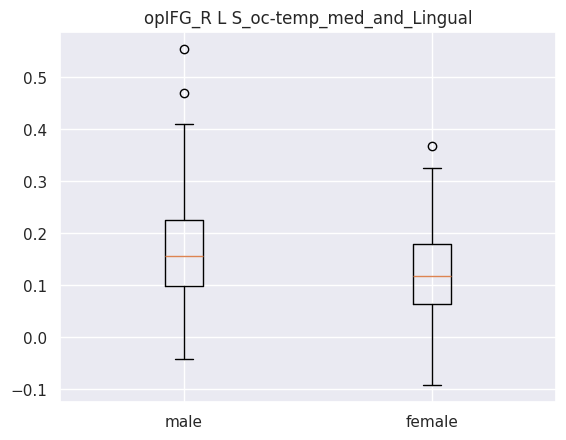

TtestResult(statistic=4.9683687670111105, pvalue=9.65358806851133e-07, df=444.0)
male mean : 0.16568285368454544
male std : 0.09795658686725976
female mean : 0.12266675558539823
female std : 0.08412303322404859
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [19]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions pITG_L

     coefficient    seed                       labels
26      0.258569  pITG_L             L G_parietal_sup
125     0.251404  pITG_L                R S_front_inf
9       0.229381  pITG_L      L G_cingul-Post-ventral
73      0.196164  pITG_L      L S_temporal_transverse
20      0.178793  pITG_L      L G_oc-temp_lat-fusifor
75      0.174681  pITG_L      R G_and_S_occipital_inf
83      0.170141  pITG_L      R G_cingul-Post-ventral
55      0.161171  pITG_L  L S_intrapariet_and_P_trans
135     0.149312  pITG_L          R S_orbital_lateral
4       0.145410  pITG_L   L G_and_S_transv_frontopol
The mean accuracy : 0.8340655555555557
The standard deviation of the accuracy : 0.04090814339830513
The lower boundry of the confidance interval of the accuracy : 0.7538855944948777
The upper boundry of the confidance interval of the accuracy : 0.9142455166162338
Mean sensitivity : 0.8368868824147409 Std sensitivity : 0.04986718307660728
Mean specificity : 0.8359144147978517 Std specificity : 0.05096994

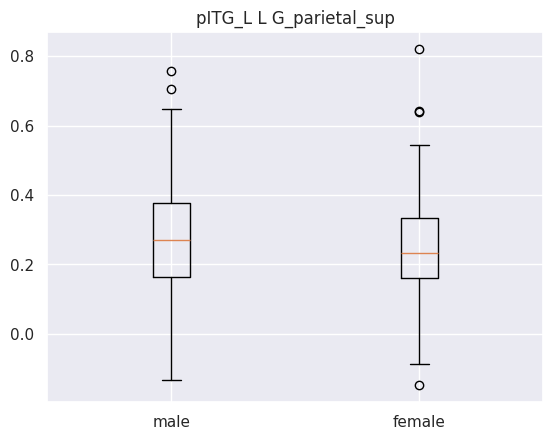

TtestResult(statistic=1.932579843967068, pvalue=0.05392366198499659, df=444.0)
male mean : 0.2742340569533182
male std : 0.16088494195816322
female mean : 0.2469608636460177
female std : 0.13572558594984654


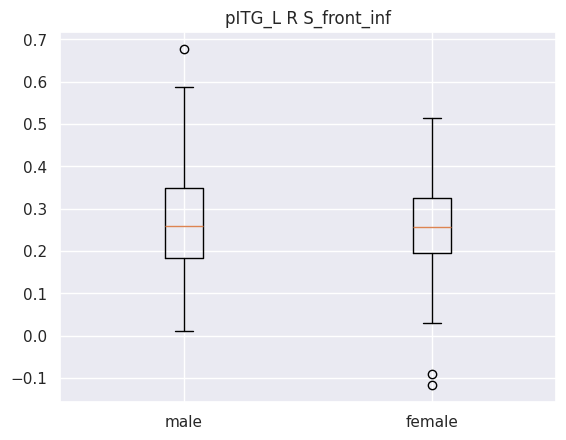

TtestResult(statistic=1.0020328934125462, pvalue=0.31687348431400925, df=444.0)
male mean : 0.2700681785363636
male std : 0.11105772730043446
female mean : 0.25973832161504423
female std : 0.10615524639315872


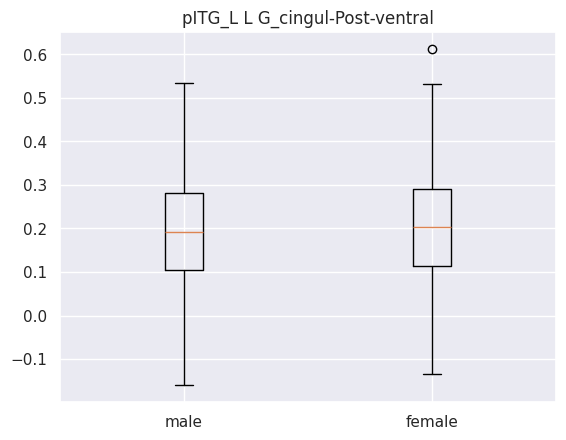

TtestResult(statistic=-0.8502284729847315, pvalue=0.3956563221847449, df=444.0)
male mean : 0.19532825054954547
male std : 0.12405214793600829
female mean : 0.2054311569070796
female std : 0.12626706102176716


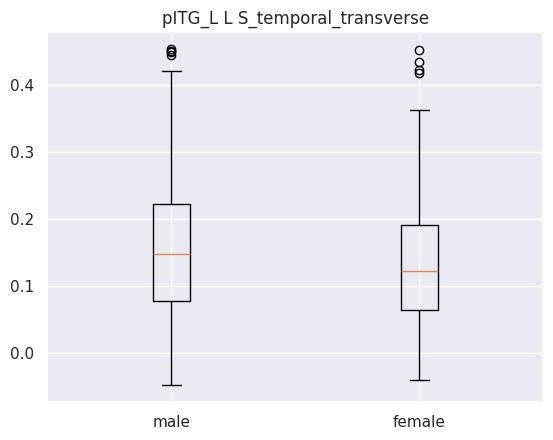

TtestResult(statistic=2.5571750426222266, pvalue=0.010883989566106632, df=444.0)
male mean : 0.1583446232454545
male std : 0.10578124515424395
female mean : 0.1342784206256637
female std : 0.09222667259385757


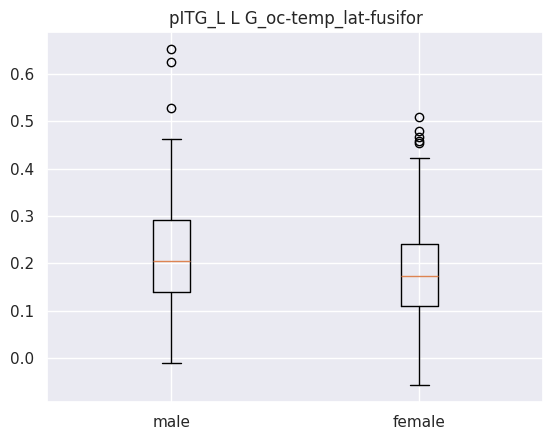

TtestResult(statistic=2.9177266272120463, pvalue=0.0037049025784669063, df=444.0)
male mean : 0.2166043530454545
male std : 0.10970491808955896
female mean : 0.18723372998539822
female std : 0.10235689928590931


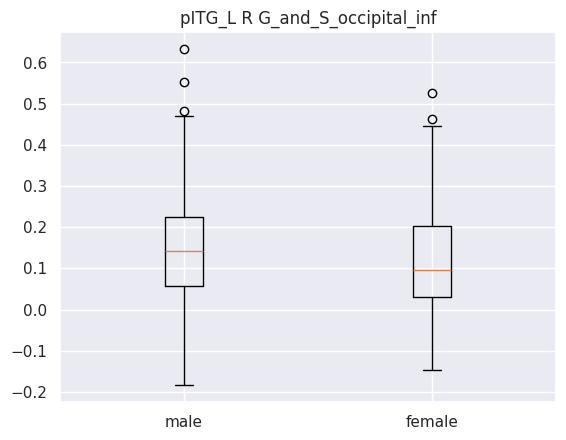

TtestResult(statistic=2.1181886492106354, pvalue=0.03471405998766398, df=444.0)
male mean : 0.14558922257772727
male std : 0.1311116449490574
female mean : 0.11931503520522121
female std : 0.13024516583608292


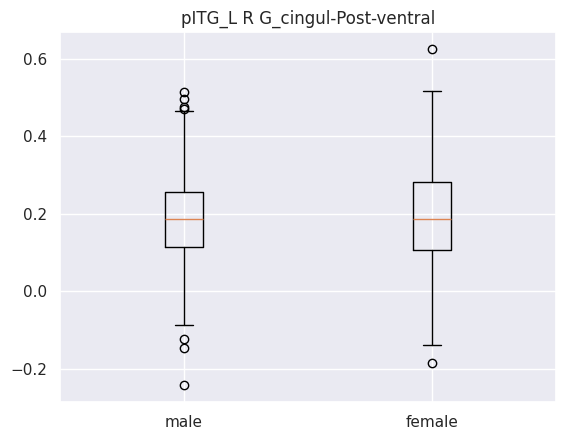

TtestResult(statistic=-0.7258276764624265, pvalue=0.4683268290899185, df=444.0)
male mean : 0.18240836490872728
male std : 0.12319924649574499
female mean : 0.19105889225530973
female std : 0.12780495959682228


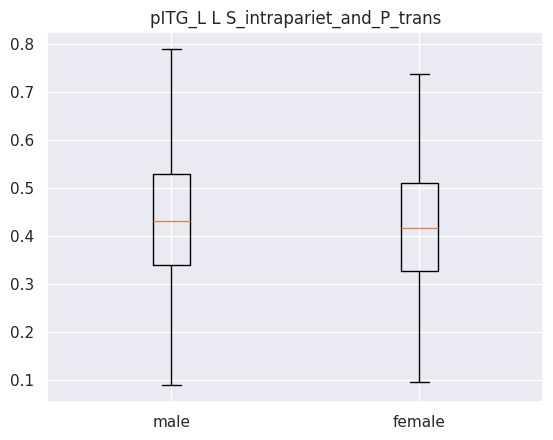

TtestResult(statistic=0.6041143572753404, pvalue=0.5460761592105134, df=444.0)
male mean : 0.4304373097727274
male std : 0.13301584196209193
female mean : 0.42295020637610614
female std : 0.1281282122063903


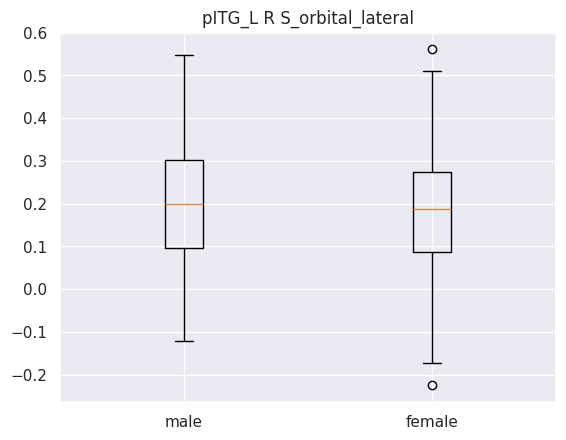

TtestResult(statistic=1.3108865376813061, pvalue=0.19057369875431965, df=444.0)
male mean : 0.20063633318604546
male std : 0.1449903023935802
female mean : 0.1830400494539823
female std : 0.13783407715558785


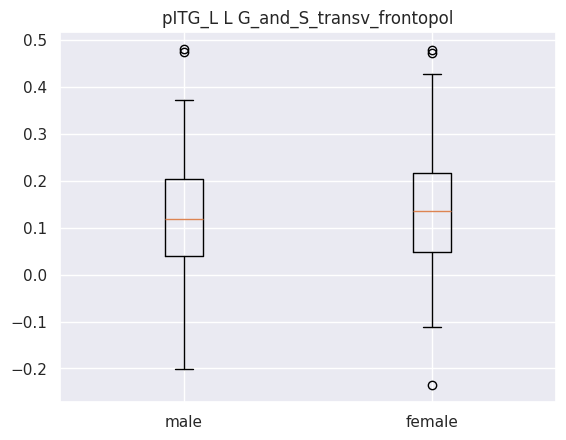

TtestResult(statistic=-1.162423120542947, pvalue=0.24568805822769893, df=444.0)
male mean : 0.12402863729863638
male std : 0.11615416814273921
female mean : 0.13712417481902656
female std : 0.12109015309239457
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [20]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions pITG_R

     coefficient    seed                    labels
20      0.317350  pITG_R   L G_oc-temp_lat-fusifor
83      0.207225  pITG_R   R G_cingul-Post-ventral
91      0.203452  pITG_R         R G_insular_short
84      0.195611  pITG_R                R G_cuneus
125     0.194242  pITG_R             R S_front_inf
72      0.162033  pITG_R          L S_temporal_sup
80      0.158161  pITG_R  R G_and_S_cingul-Mid-Ant
32      0.146301  pITG_R   L G_temp_sup-G_T_transv
144     0.142211  pITG_R           R S_subparietal
19      0.136236  pITG_R         L G_occipital_sup
The mean accuracy : 0.8087766666666668
The standard deviation of the accuracy : 0.04366703136686832
The lower boundry of the confidance interval of the accuracy : 0.723189285187605
The upper boundry of the confidance interval of the accuracy : 0.8943640481457287
Mean sensitivity : 0.8030865538507487 Std sensitivity : 0.05111756646867676
Mean specificity : 0.8199458184890595 Std specificity : 0.05372855203856655


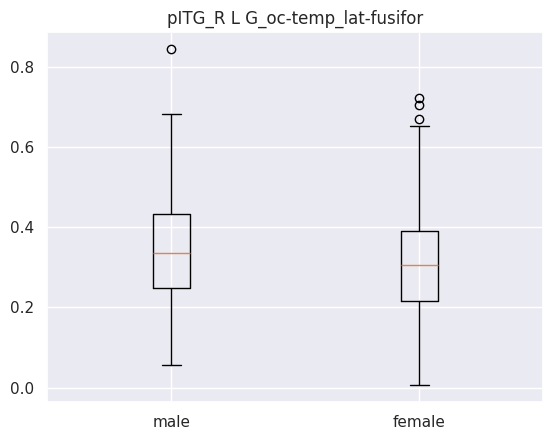

TtestResult(statistic=2.207601503782289, pvalue=0.027782692747375555, df=444.0)
male mean : 0.3381230503772727
male std : 0.13608853787659086
female mean : 0.31070127244911505
female std : 0.1255552430118421


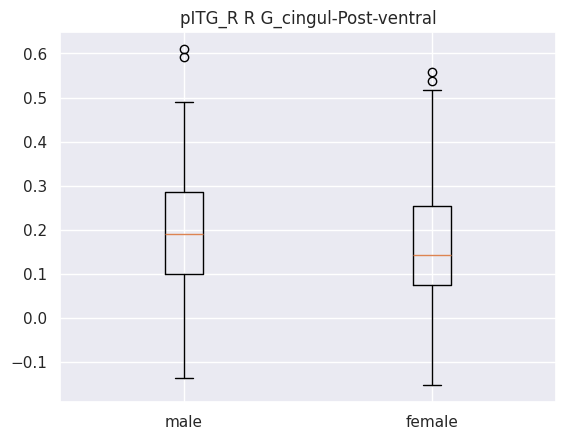

TtestResult(statistic=2.380140291533847, pvalue=0.01772726625126871, df=444.0)
male mean : 0.19296064746681815
male std : 0.1346758980066957
female mean : 0.16264045314955752
female std : 0.13373455574896778


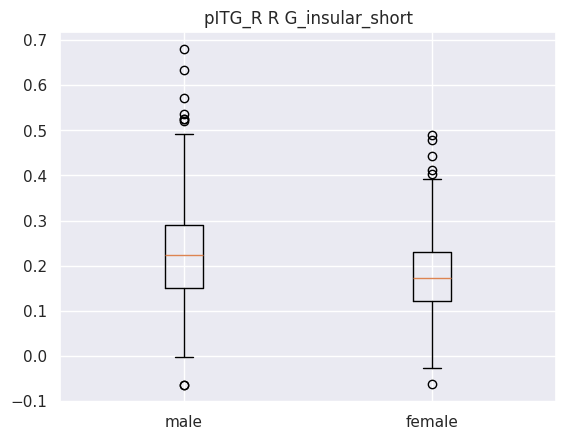

TtestResult(statistic=5.112160421970684, pvalue=4.743233770538839e-07, df=444.0)
male mean : 0.2313763518045455
male std : 0.12096734073549982
female mean : 0.1792633135699115
female std : 0.09227387552085549


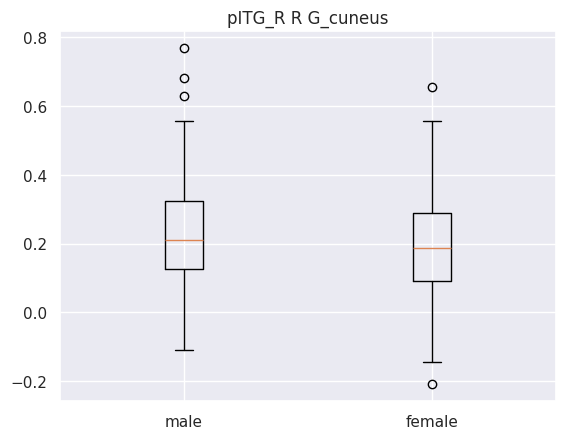

TtestResult(statistic=2.518734910789549, pvalue=0.012128078944136934, df=444.0)
male mean : 0.22664096681499996
male std : 0.14532160156704602
female mean : 0.192063495079646
female std : 0.14393677903416816


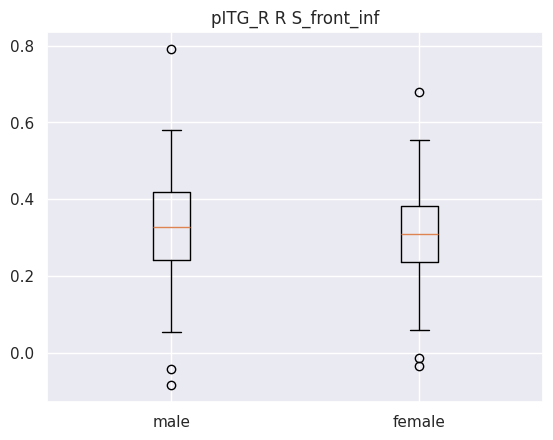

TtestResult(statistic=2.13538486489198, pvalue=0.03327622102378573, df=444.0)
male mean : 0.3298146207409091
male std : 0.12123145108487972
female mean : 0.3068887235929204
female std : 0.1045843071513845


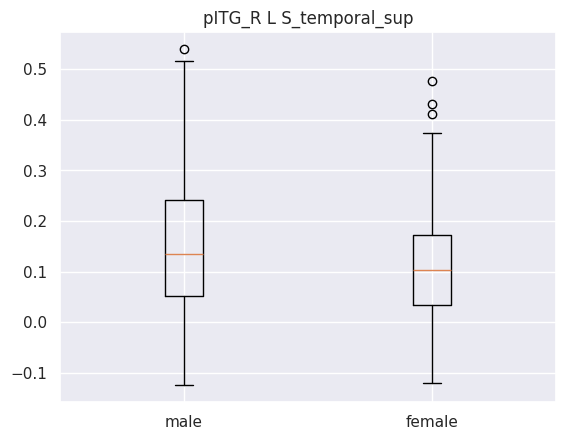

TtestResult(statistic=3.880451580314428, pvalue=0.00012007067421179041, df=444.0)
male mean : 0.15231047255386362
male std : 0.1297059803514484
female mean : 0.10898147674115045
female std : 0.10454350572317415


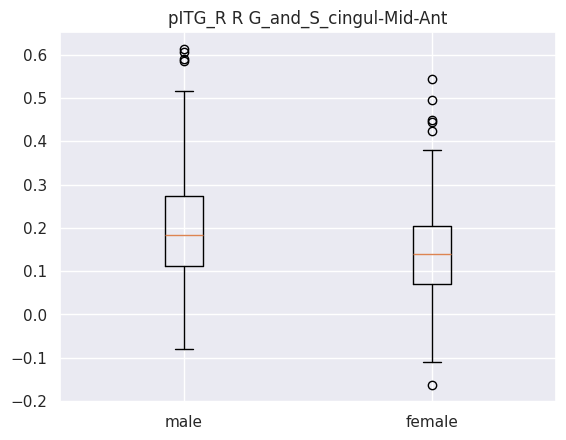

TtestResult(statistic=5.066890396884413, pvalue=5.943184005143566e-07, df=444.0)
male mean : 0.1998270520648636
male std : 0.12720804898662696
female mean : 0.14344552138243363
female std : 0.10661125501036757


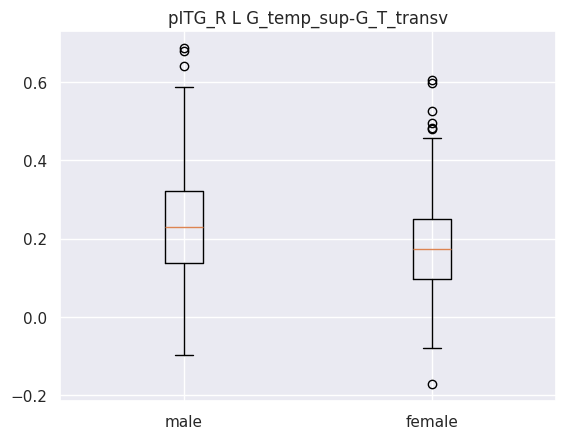

TtestResult(statistic=4.524709164152146, pvalue=7.774373381230067e-06, df=444.0)
male mean : 0.2398444346181818
male std : 0.1385572380212938
female mean : 0.1833660085743363
female std : 0.12423831506745996


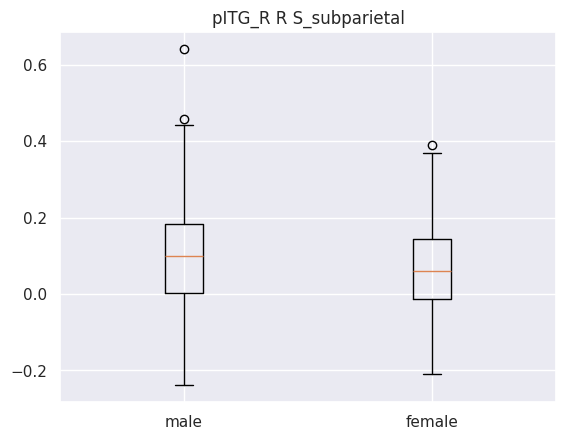

TtestResult(statistic=2.829717950526025, pvalue=0.004870145913425502, df=444.0)
male mean : 0.09907962378045454
male std : 0.14339205847252812
female mean : 0.06350742244464602
female std : 0.12080952413470375


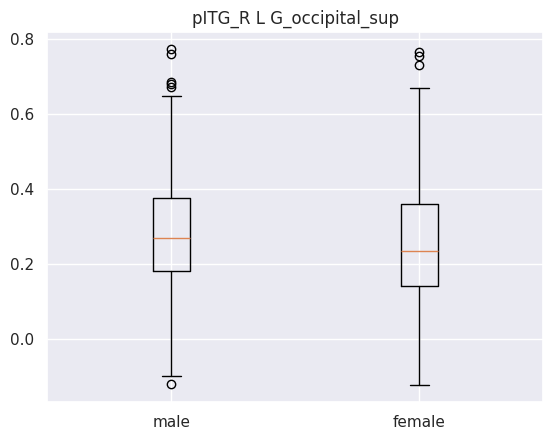

TtestResult(statistic=1.9000999167732846, pvalue=0.0580675668673942, df=444.0)
male mean : 0.2820350529227273
male std : 0.16444488939612117
female mean : 0.2527341717604425
female std : 0.1604892713694592
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [21]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_L

     coefficient          seed                       labels
60      0.285785  planumtemp_L  L S_oc-temp_med_and_Lingual
66      0.214379  planumtemp_L              L S_postcentral
108     0.189177  planumtemp_L      R G_temp_sup-Plan_polar
20      0.177437  planumtemp_L      L G_oc-temp_lat-fusifor
99      0.169222  planumtemp_L      R G_pariet_inf-Supramar
32      0.146572  planumtemp_L      L G_temp_sup-G_T_transv
84      0.144802  planumtemp_L                   R G_cuneus
124     0.140053  planumtemp_L       R S_collat_transv_post
97      0.137739  planumtemp_L                  R G_orbital
12      0.137529  planumtemp_L        L G_front_inf-Orbital
The mean accuracy : 0.7954433333333334
The standard deviation of the accuracy : 0.04432193948546348
The lower boundry of the confidance interval of the accuracy : 0.708572331941825
The upper boundry of the confidance interval of the accuracy : 0.8823143347248418
Mean sensitivity : 0.7915346005222705 Std sensitivity : 0.051554777928525294


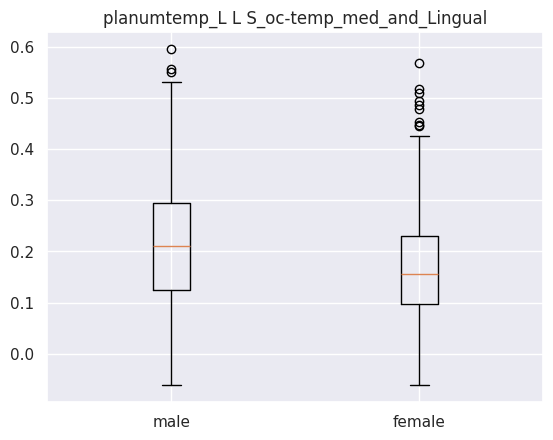

TtestResult(statistic=3.568169946152254, pvalue=0.00039862792533886367, df=444.0)
male mean : 0.21577463173863637
male std : 0.11920041520251866
female mean : 0.17618120696902656
female std : 0.11460830695377548


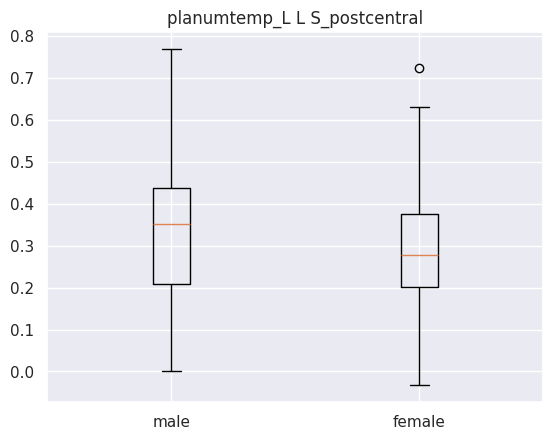

TtestResult(statistic=3.3982524664602822, pvalue=0.0007393236091411032, df=444.0)
male mean : 0.33581050932090906
male std : 0.15519364606058975
female mean : 0.28810105651946905
female std : 0.14043859969892733


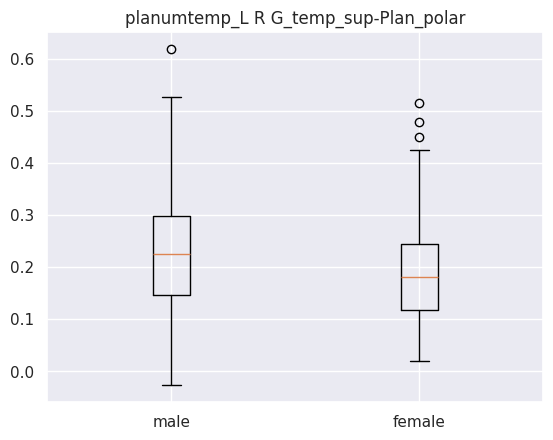

TtestResult(statistic=4.42054857038295, pvalue=1.2391524231536645e-05, df=444.0)
male mean : 0.231116042775
male std : 0.10743291511827939
female mean : 0.18849037465929203
female std : 0.09554310246985663


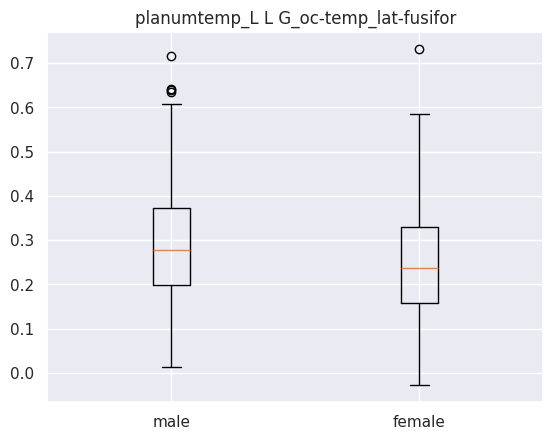

TtestResult(statistic=3.7622305190657452, pvalue=0.0001909807101357603, df=444.0)
male mean : 0.2942304806272728
male std : 0.13292350850751689
female mean : 0.24918162700884958
female std : 0.119170924743853


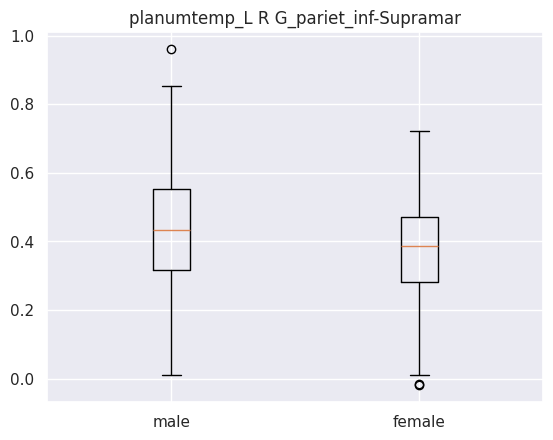

TtestResult(statistic=3.40846885515764, pvalue=0.0007128702515509998, df=444.0)
male mean : 0.4307228165545455
male std : 0.17295636548930826
female mean : 0.3790449651415929
female std : 0.14569081362589828


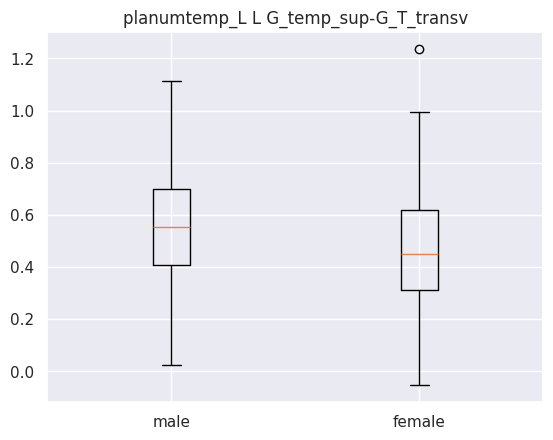

TtestResult(statistic=4.257820644190498, pvalue=2.5208094311888567e-05, df=444.0)
male mean : 0.5589595099318182
male std : 0.21319300616377004
female mean : 0.4754513254070797
female std : 0.20000588864178753


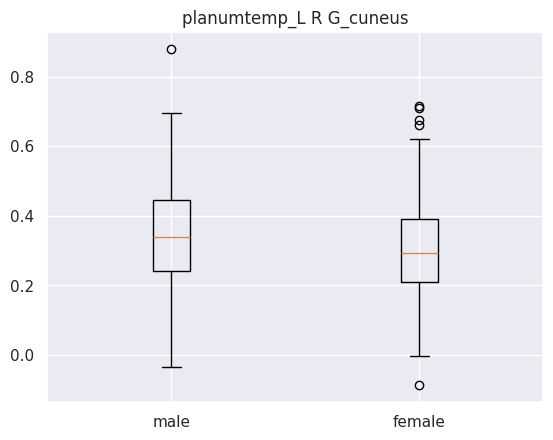

TtestResult(statistic=2.779045702868326, pvalue=0.005683247460462339, df=444.0)
male mean : 0.3442871131318182
male std : 0.15448762649047768
female mean : 0.30501909665823007
female std : 0.1431606319240156


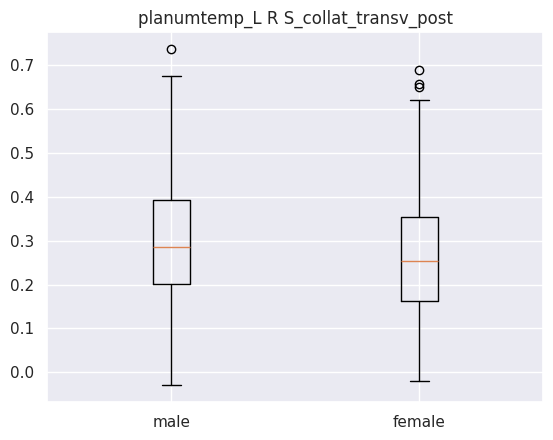

TtestResult(statistic=2.721180273283202, pvalue=0.006760590380353587, df=444.0)
male mean : 0.2982221393318182
male std : 0.14752263554395537
female mean : 0.26174931810398233
female std : 0.13476027522052467


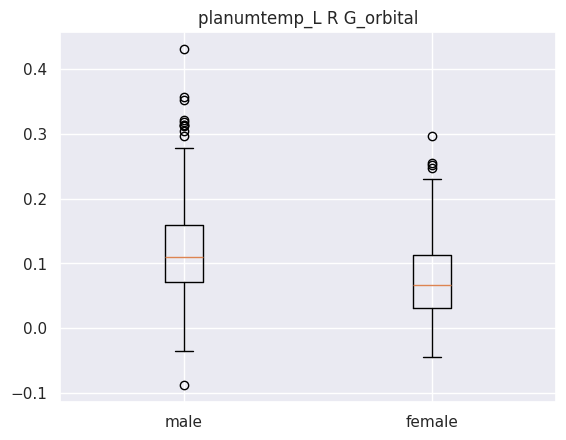

TtestResult(statistic=6.196595562626994, pvalue=1.3181987091251495e-09, df=444.0)
male mean : 0.11958186677313637
male std : 0.08248911781923307
female mean : 0.07573241422522124
female std : 0.06590387588645001


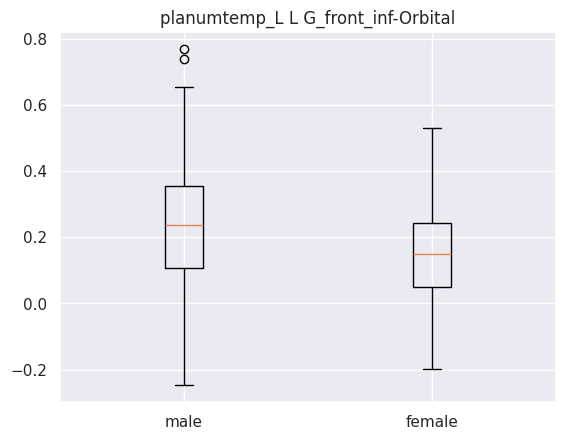

TtestResult(statistic=5.107135513546635, pvalue=4.863866810935087e-07, df=444.0)
male mean : 0.23303983193518182
male std : 0.172649773101282
female mean : 0.15810105575973452
female std : 0.13467953472609615
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [22]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_R

     coefficient          seed                       labels
72      0.223593  planumtemp_R             L S_temporal_sup
60      0.222028  planumtemp_R  L S_oc-temp_med_and_Lingual
47      0.216804  planumtemp_R      L S_circular_insula_inf
108     0.211511  planumtemp_R      R G_temp_sup-Plan_polar
121     0.186898  planumtemp_R      R S_circular_insula_inf
145     0.171646  planumtemp_R             R S_temporal_inf
139     0.167862  planumtemp_R             R S_pericallosal
78      0.152822  planumtemp_R   R G_and_S_transv_frontopol
80      0.145916  planumtemp_R     R G_and_S_cingul-Mid-Ant
32      0.144998  planumtemp_R      L G_temp_sup-G_T_transv
The mean accuracy : 0.7970066666666668
The standard deviation of the accuracy : 0.04447058070396819
The lower boundry of the confidance interval of the accuracy : 0.709844328486889
The upper boundry of the confidance interval of the accuracy : 0.8841690048464445
Mean sensitivity : 0.7893166242418801 Std sensitivity : 0.0515266336808596
Me

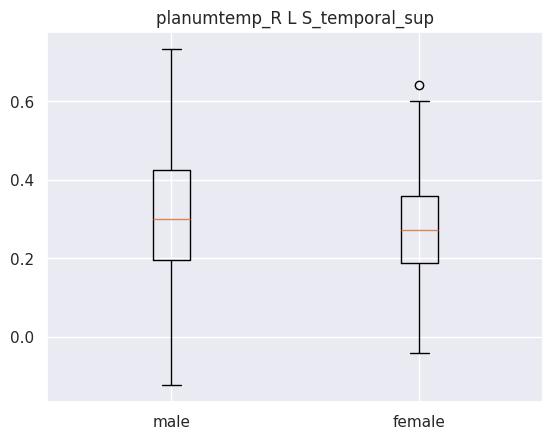

TtestResult(statistic=1.8695975920657857, pvalue=0.06219767425438533, df=444.0)
male mean : 0.3054438005095454
male std : 0.16618568479496404
female mean : 0.2788564426159292
female std : 0.13193744183702244


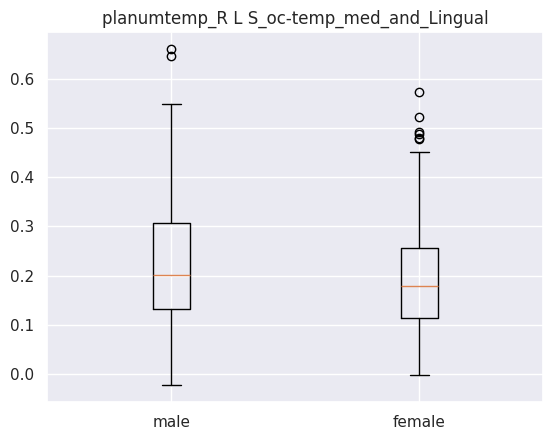

TtestResult(statistic=3.1406026539933913, pvalue=0.001798634977217268, df=444.0)
male mean : 0.22554338915745453
male std : 0.12167229969009292
female mean : 0.19155830762477874
female std : 0.10599522757213717


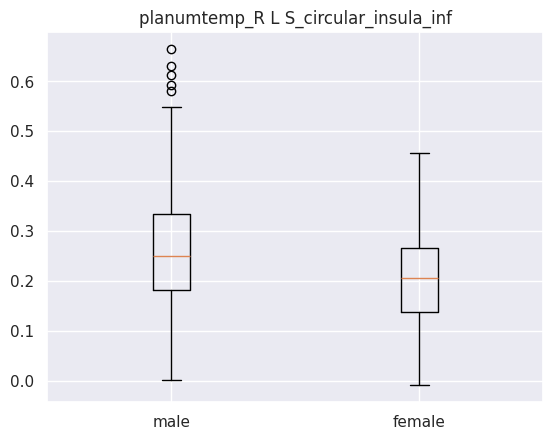

TtestResult(statistic=5.536682319675686, pvalue=5.283850273823166e-08, df=444.0)
male mean : 0.26314078573
male std : 0.11589033220243106
female mean : 0.20795944492035398
female std : 0.09317104682445226


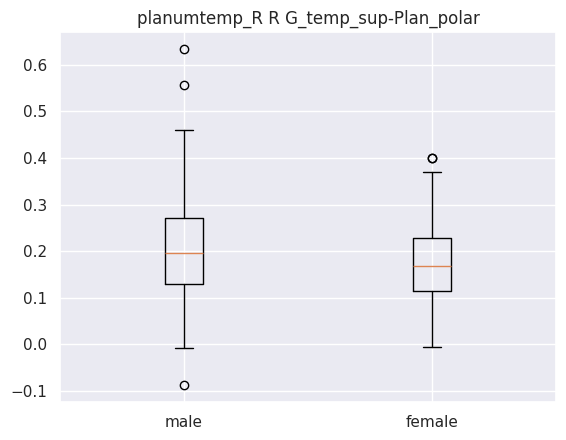

TtestResult(statistic=3.411258353986623, pvalue=0.0007058022781917119, df=444.0)
male mean : 0.20694257242727274
male std : 0.10325686123318684
female mean : 0.17643976180088497
female std : 0.08445412241365245


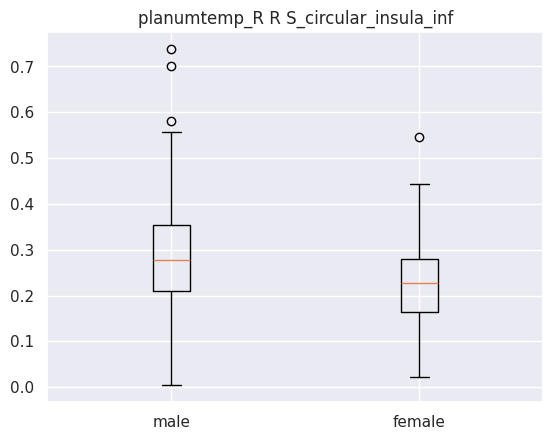

TtestResult(statistic=5.673022197146965, pvalue=2.5335329424316272e-08, df=444.0)
male mean : 0.28464964156636363
male std : 0.11115068945139177
female mean : 0.22998609894690267
female std : 0.0911493316406924


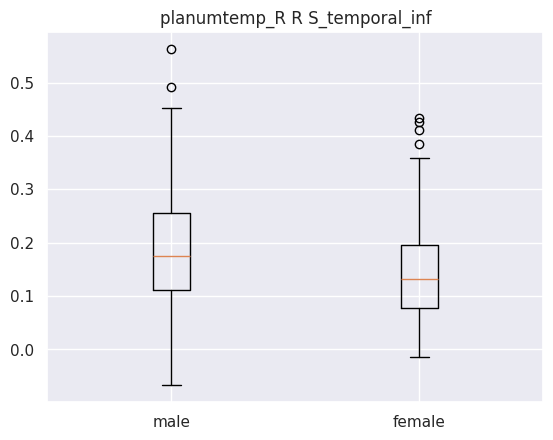

TtestResult(statistic=5.093445831834155, pvalue=5.207770662763331e-07, df=444.0)
male mean : 0.19109833336272727
male std : 0.11146610197202778
female mean : 0.14283558278274336
female std : 0.08700087808711052


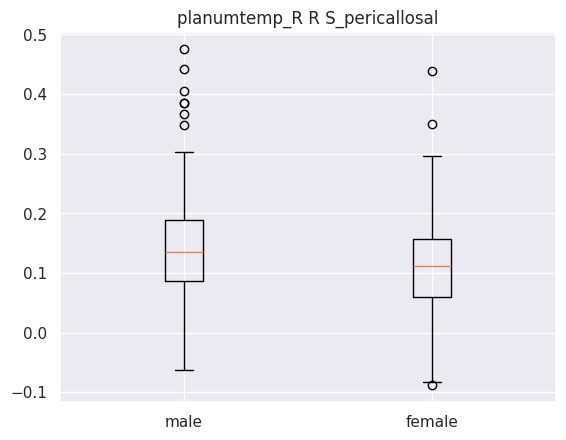

TtestResult(statistic=4.099512012037479, pvalue=4.9237855822734976e-05, df=444.0)
male mean : 0.14388453827454545
male std : 0.08547370646470348
female mean : 0.11232528979557523
female std : 0.07660129004358317


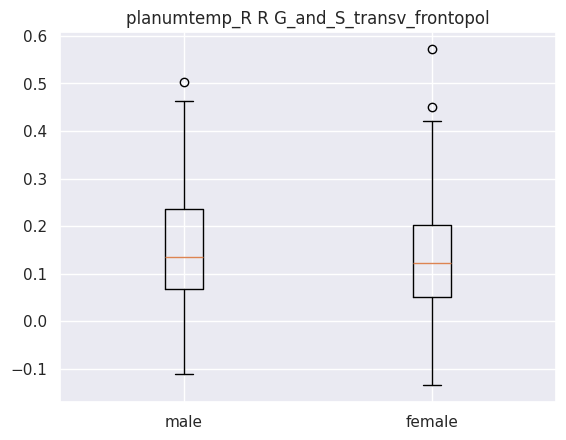

TtestResult(statistic=1.6197574048200072, pvalue=0.10599440842770202, df=444.0)
male mean : 0.14979874731818182
male std : 0.12757857054837393
female mean : 0.13102783685654867
female std : 0.11648592660505695


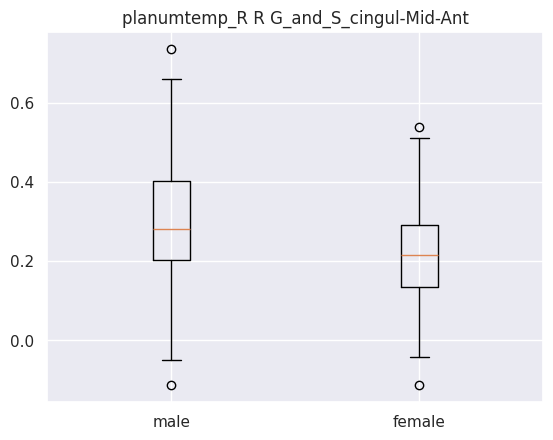

TtestResult(statistic=6.25879902032395, pvalue=9.150965155556426e-10, df=444.0)
male mean : 0.2963763690363636
male std : 0.14184665808875968
female mean : 0.22059838039203541
female std : 0.11188772976763034


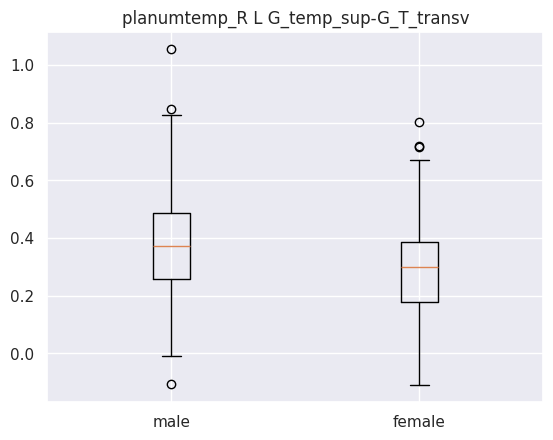

TtestResult(statistic=5.327111610985564, pvalue=1.5894850932283935e-07, df=444.0)
male mean : 0.3784629311636364
male std : 0.18082731693617612
female mean : 0.29372215279778763
female std : 0.15359132563789854
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [23]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions for all left seeds

     coefficient          seed                       labels
53      0.123777       opIFG_L                L S_front_sup
98      0.113710       opIFG_L       R G_pariet_inf-Angular
351     0.105832        aMTG_L  L S_intrapariet_and_P_trans
421     0.105135        aMTG_L                R S_front_inf
322     0.103736        aMTG_L             L G_parietal_sup
305     0.100285        aMTG_L      L G_cingul-Post-ventral
4       0.100128       opIFG_L   L G_and_S_transv_frontopol
431     0.095805        aMTG_L          R S_orbital_lateral
273     0.093985  planumtemp_L                R S_front_inf
55      0.088499       opIFG_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.9125455555555558
The standard deviation of the accuracy : 0.03167706104259511
The lower boundry of the confidance interval of the accuracy : 0.8504585159120694
The upper boundry of the confidance interval of the accuracy : 0.9746325951990422
Mean sensitivity : 0.9134898379989987 Std sensitivity : 0.04150831932387169


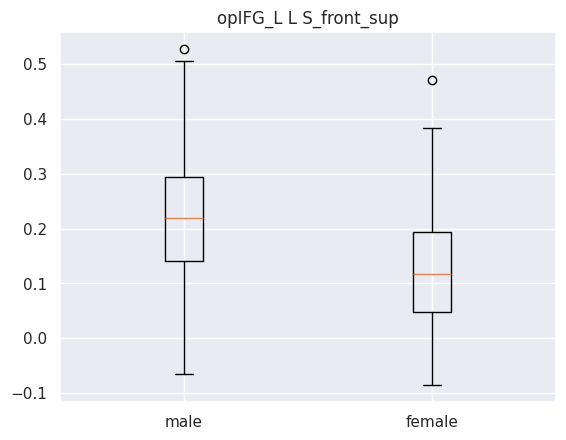

TtestResult(statistic=9.514226955534408, pvalue=1.1745948061525577e-19, df=444.0)
male mean : 0.22193633239999996
male std : 0.11249626112199279
female mean : 0.12588911007571682
female std : 0.10000267392277586


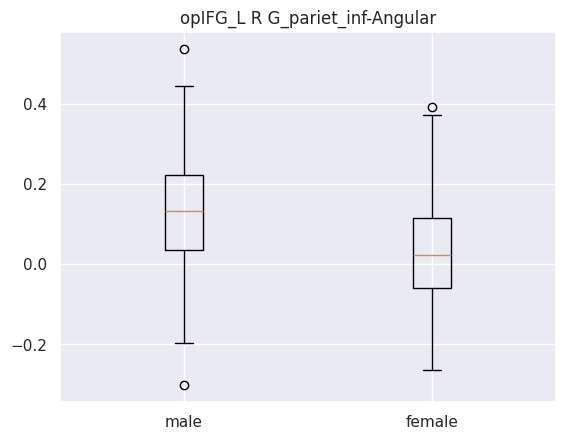

TtestResult(statistic=7.24780487230096, pvalue=1.8918423767886693e-12, df=444.0)
male mean : 0.12424016548681818
male std : 0.13424300726761648
female mean : 0.03453558849026549
female std : 0.1265180924203619


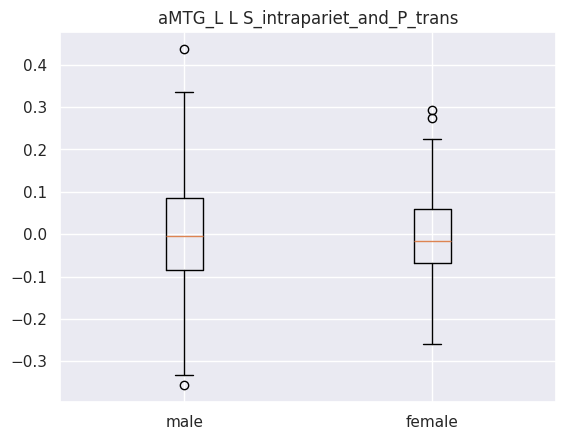

TtestResult(statistic=1.0441439448576817, pvalue=0.29698694253266955, df=444.0)
male mean : 0.004413317491818183
male std : 0.12667357592144304
female mean : -0.006823133387610619
female std : 0.09870796418027704


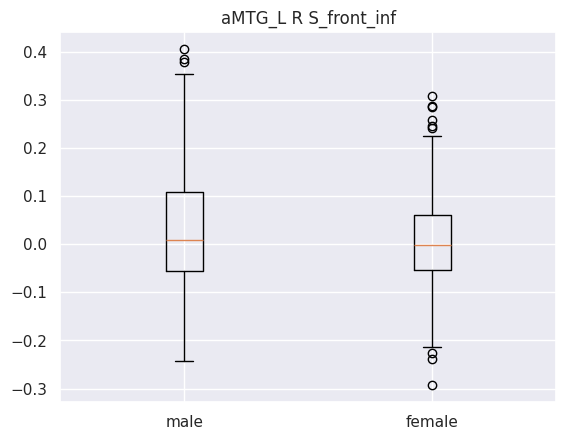

TtestResult(statistic=1.9193910426129293, pvalue=0.055575465964615225, df=444.0)
male mean : 0.025140619681999998
male std : 0.12506768589238804
female mean : 0.004515161334216815
female std : 0.10031688528841444


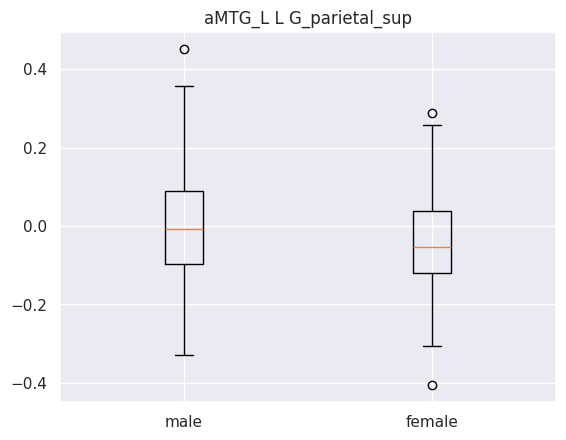

TtestResult(statistic=3.4850474873752884, pvalue=0.0005409444654669903, df=444.0)
male mean : 0.003152544490909089
male std : 0.1486536903265774
female mean : -0.040841305016592916
female std : 0.11571389999440254


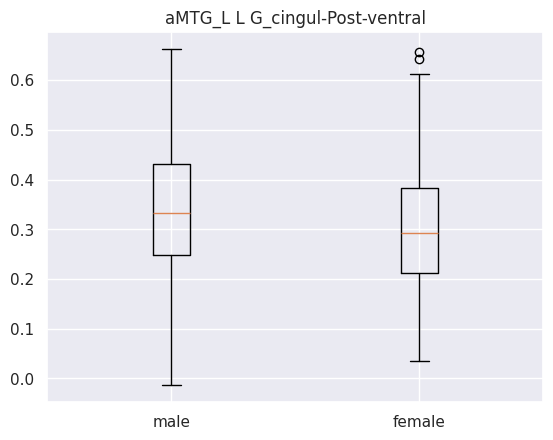

TtestResult(statistic=2.7358247046655375, pvalue=0.006471799539479473, df=444.0)
male mean : 0.3344936346227273
male std : 0.12852301357983476
female mean : 0.30081479229646013
female std : 0.1308069984904627


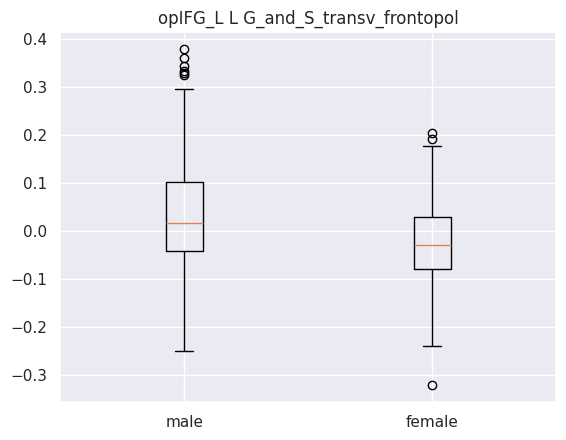

TtestResult(statistic=5.033838587916691, pvalue=6.999625036984745e-07, df=444.0)
male mean : 0.025597121174999998
male std : 0.11515068596736391
female mean : -0.023709215497699117
female std : 0.09002691208082556


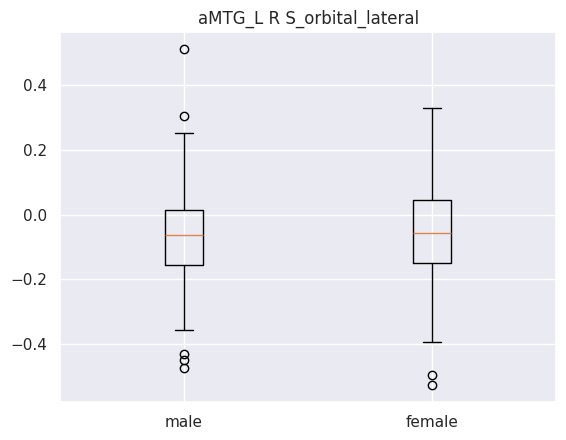

TtestResult(statistic=-0.9595545169231156, pvalue=0.337801699063937, df=444.0)
male mean : -0.06771869820213636
male std : 0.14263363470452184
female mean : -0.05464536117588496
female std : 0.14439482773638504


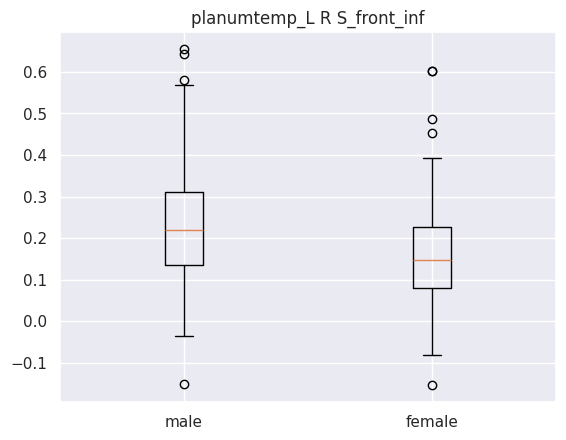

TtestResult(statistic=5.587999239745126, pvalue=4.0136433383783943e-08, df=444.0)
male mean : 0.2274188739409091
male std : 0.1272630755767123
female mean : 0.16257370877256638
female std : 0.11716102765540921


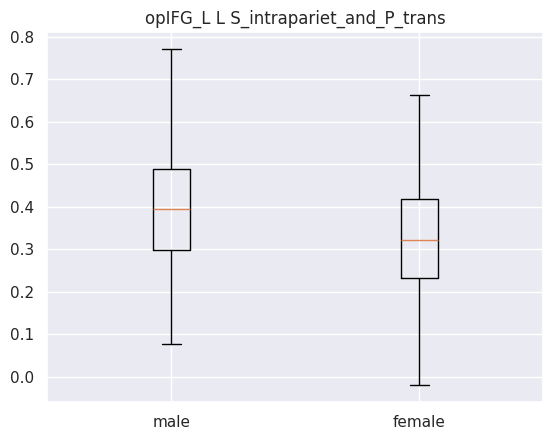

TtestResult(statistic=5.1258862531393055, pvalue=4.4282893375816664e-07, df=444.0)
male mean : 0.3898567061545455
male std : 0.13731628353334865
female mean : 0.32281164144557517
female std : 0.1382510384328816
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [24]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions of all right seeds

     coefficient          seed                       labels
53      0.134322       opIFG_R                L S_front_sup
66      0.114011       opIFG_R              L S_postcentral
316     0.104480        aMTG_R      L G_oc-temp_lat-fusifor
55      0.103655       opIFG_R  L S_intrapariet_and_P_trans
421     0.103610        aMTG_R                R S_front_inf
379     0.094846        aMTG_R      R G_cingul-Post-ventral
239     0.092743  planumtemp_R            R G_insular_short
522     0.086193        pITG_R   R G_and_S_transv_frontopol
273     0.085974  planumtemp_R                R S_front_inf
228     0.084403  planumtemp_R     R G_and_S_cingul-Mid-Ant
The mean accuracy : 0.8903488888888891
The standard deviation of the accuracy : 0.03524470722894888
The lower boundry of the confidance interval of the accuracy : 0.8212692627201492
The upper boundry of the confidance interval of the accuracy : 0.9594285150576289
Mean sensitivity : 0.8889100879516413 Std sensitivity : 0.044828656788072456

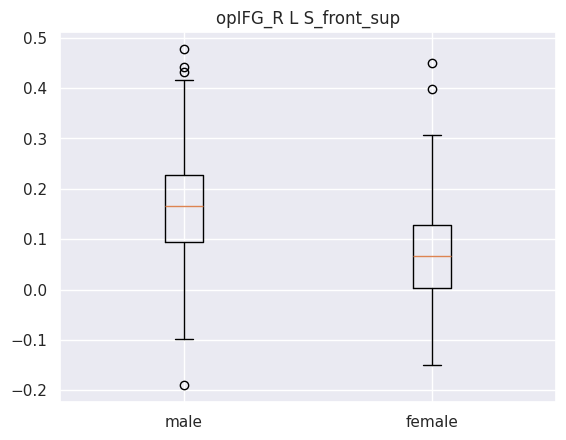

TtestResult(statistic=9.215326889220611, pvalue=1.248160215367442e-18, df=444.0)
male mean : 0.16320744882072724
male std : 0.10965043228920933
female mean : 0.07219020907314161
female std : 0.09828873030252666


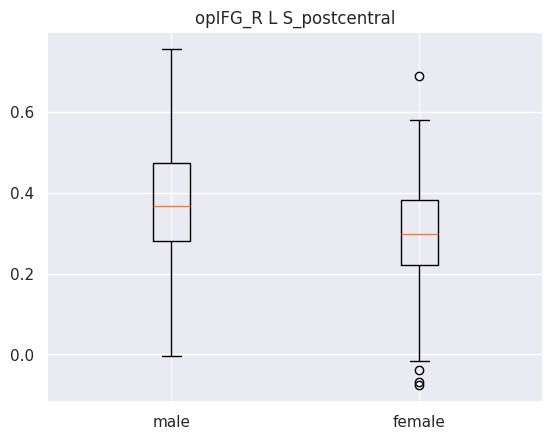

TtestResult(statistic=5.748096942910928, pvalue=1.6798182257112908e-08, df=444.0)
male mean : 0.37275803086818177
male std : 0.13910319518939593
female mean : 0.29995721800884956
female std : 0.12765335683486648


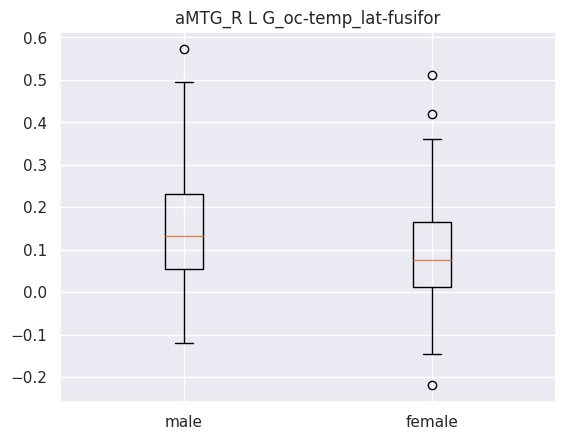

TtestResult(statistic=5.157132505636498, pvalue=3.7849853475325553e-07, df=444.0)
male mean : 0.15163267344727274
male std : 0.13083327172091533
female mean : 0.09148790766993664
female std : 0.11456737640495235


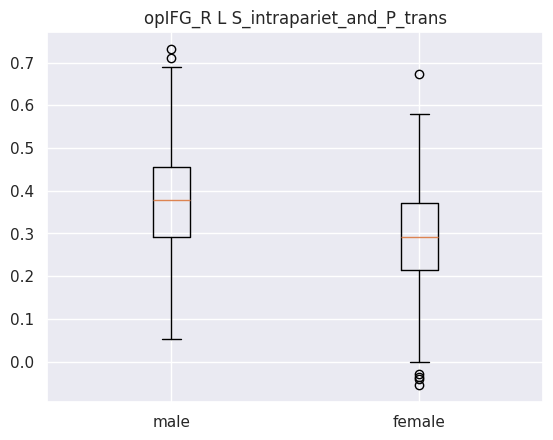

TtestResult(statistic=7.525715474692434, pvalue=2.943978024764579e-13, df=444.0)
male mean : 0.3783558262136364
male std : 0.13092386861978492
female mean : 0.2881963432641593
female std : 0.1214409141686982


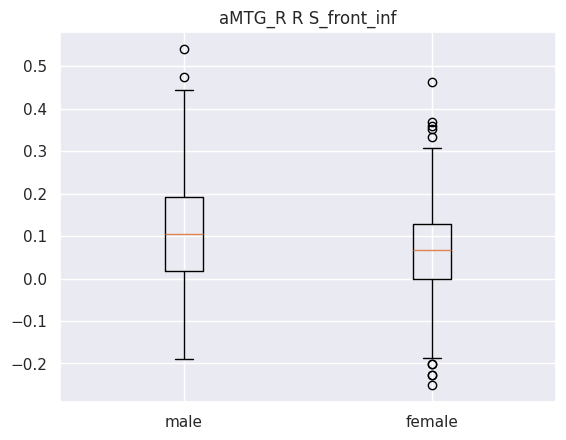

TtestResult(statistic=3.956278857457922, pvalue=8.86001863789618e-05, df=444.0)
male mean : 0.10791621693545454
male std : 0.12931995413969696
female mean : 0.06154310212610619
female std : 0.11751957032303513


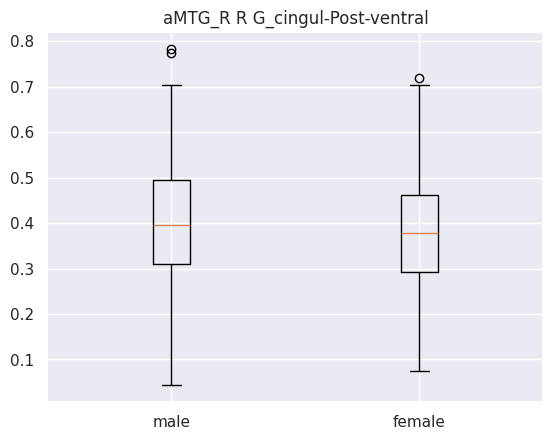

TtestResult(statistic=1.908818782319767, pvalue=0.056929922966081396, df=444.0)
male mean : 0.3987402407954545
male std : 0.13795183996980973
female mean : 0.37419803800884954
female std : 0.1329643689111022


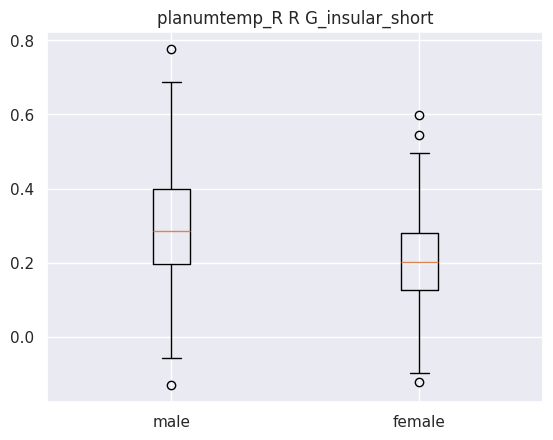

TtestResult(statistic=7.239063193304473, pvalue=2.0041429727150364e-12, df=444.0)
male mean : 0.29305110629318176
male std : 0.14523358447346782
female mean : 0.2019796631004425
female std : 0.11887194196042161


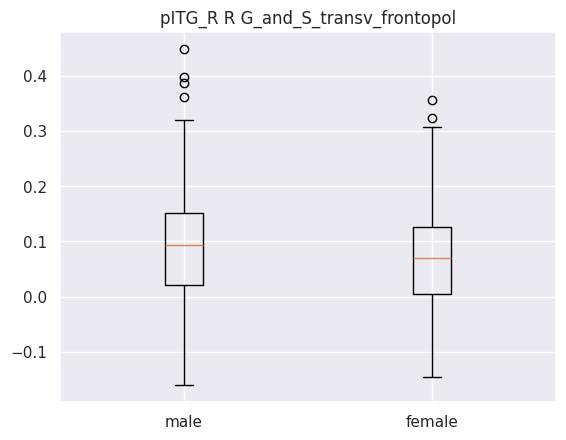

TtestResult(statistic=2.652366977979778, pvalue=0.008279246837594543, df=444.0)
male mean : 0.09232632171545455
male std : 0.10090598868239635
female mean : 0.06824433925265487
female std : 0.09023806023391034


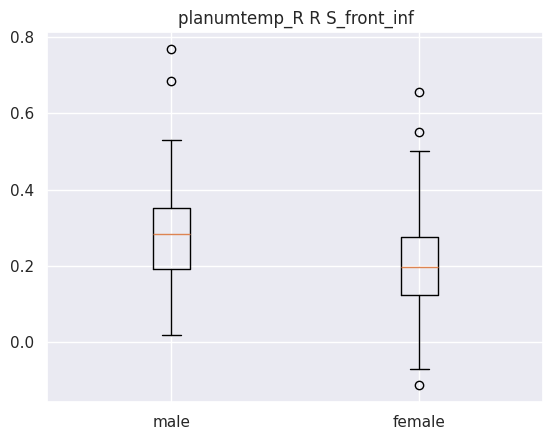

TtestResult(statistic=6.639061278911552, pvalue=9.234462597542052e-11, df=444.0)
male mean : 0.2812065720636364
male std : 0.1191306123770796
female mean : 0.20553979665486727
female std : 0.12096998265755837


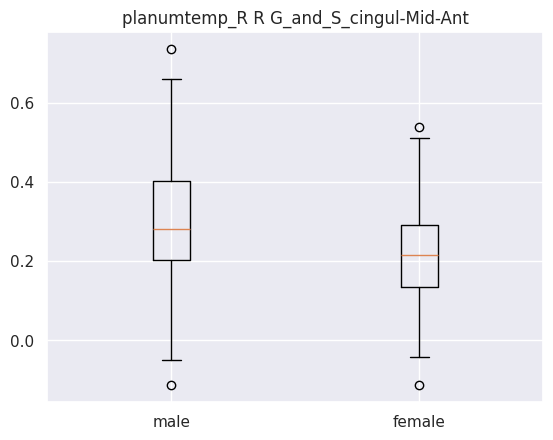

TtestResult(statistic=6.25879902032395, pvalue=9.150965155556426e-10, df=444.0)
male mean : 0.2963763690363636
male std : 0.14184665808875968
female mean : 0.22059838039203541
female std : 0.11188772976763034
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [25]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

# Noise testing

In [26]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [27]:
model_test = data_results["model"][random.randint(0, 10000)]
gender_test = np.asarray(df_boot["Gender"])
score, perm_score, p_val = permutation_test_score(model_test, x_correl, gender_test)

In [28]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

In [29]:
gender_test = np.asarray(df_boot["Gender"])
x_correl.size

528064

(0.4, 1.0)

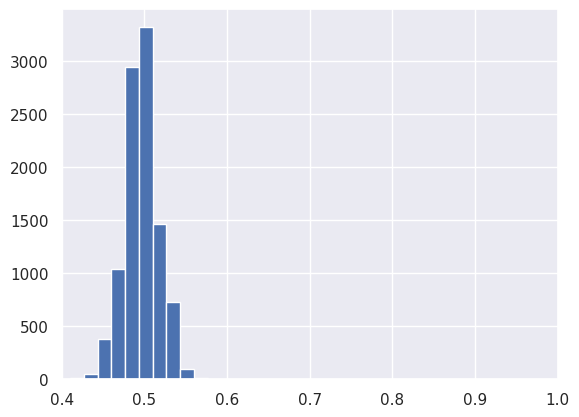

In [30]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [31]:
# accuracy should be around 0.50 (50%) if not it's a problem
acc_iter.mean()

0.4963991031390135

# Permutation testing

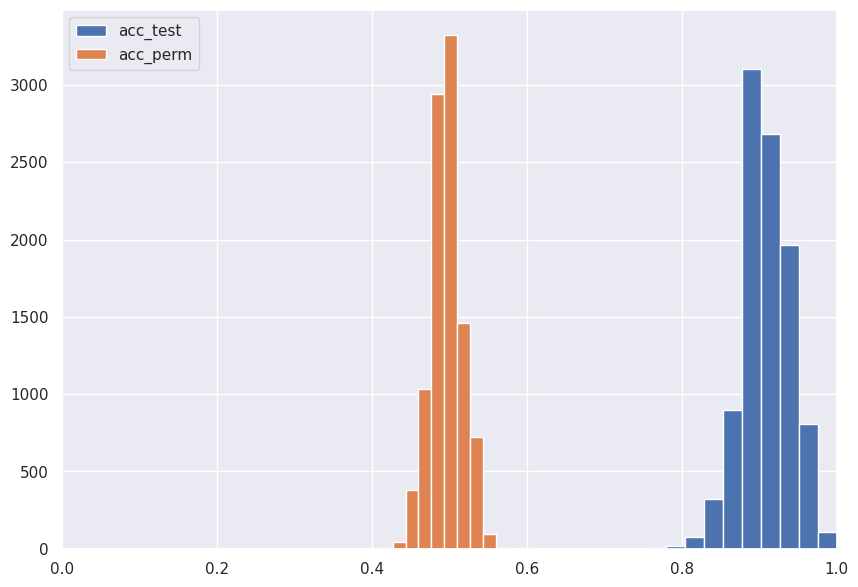

In [32]:
f = plt.figure()
plt.hist(data_results["acc_test"], label="acc_test")
plt.hist(acc_iter, label="acc_perm")
plt.legend(loc="upper left")
plt.xlim([0, 1])
f.set_figwidth(10)
f.set_figheight(7)

In [33]:
t_test = stats.ttest_ind(data_results["acc_test"], acc_iter)
print(t_test.pvalue)

0.0


# Violin plot

0.149155713895


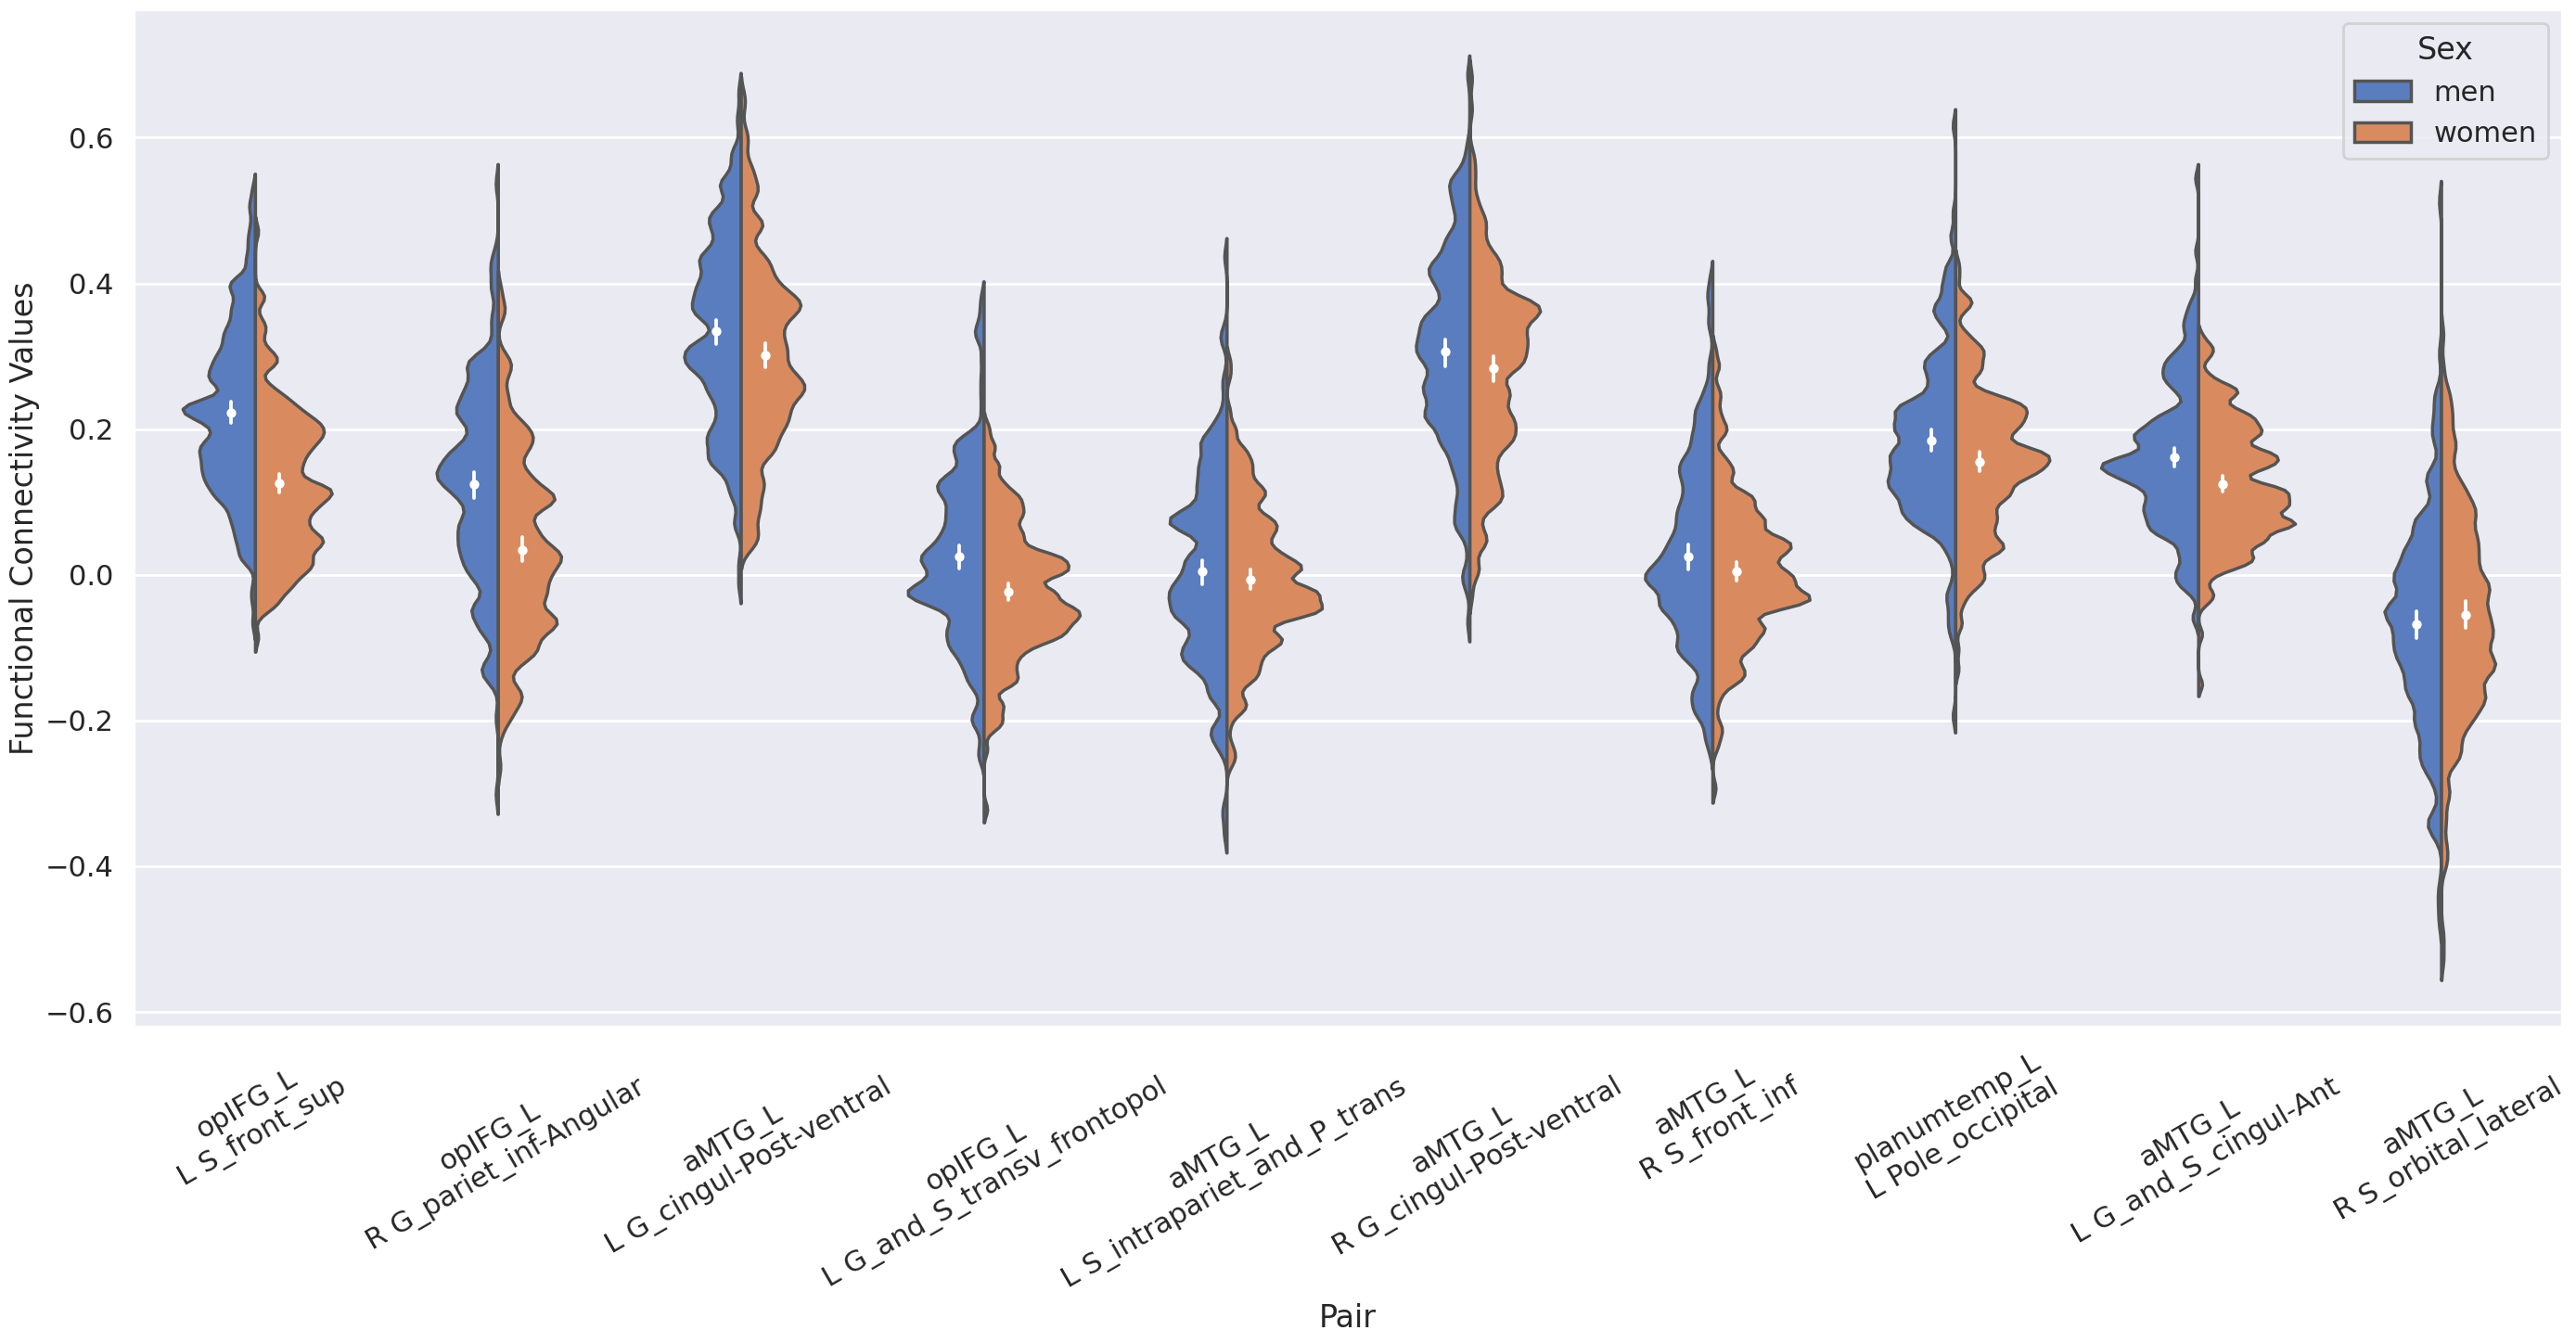

In [35]:
#1. make dataframe for the violin plot 
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})

df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]

df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())


# 53      0.071998       opIFG_L                L S_front_sup
# 98      0.068703       opIFG_L       R G_pariet_inf-Angular
# 305     0.067761        aMTG_L      L G_cingul-Post-ventral
# 4       0.062096       opIFG_L   L G_and_S_transv_frontopol
# 351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
# 379     0.055342        aMTG_L      R G_cingul-Post-ventral
# 421     0.054767        aMTG_L                R S_front_inf
# 189     0.053099  planumtemp_L             L Pole_occipital
# 301     0.052427        aMTG_L         L G_and_S_cingul-Ant
# 431     0.051413        aMTG_L          R S_orbital_lateral


# A changer selon les dix meilleures seeds
# list to make sure top 10 regions are in order 
top10 = ["opIFG_L with L S_front_sup",
         "opIFG_L with R G_pariet_inf-Angular",
         "aMTG_L with L G_cingul-Post-ventral",
         "opIFG_L with L G_and_S_transv_frontopol",
         "aMTG_L with L S_intrapariet_and_P_trans", 
         "aMTG_L with R G_cingul-Post-ventral",
         "aMTG_L with R S_front_inf",
         "planumtemp_L with L Pole_occipital",
         "aMTG_L with L G_and_S_cingul-Ant", 
         "aMTG_L with R S_orbital_lateral"]
         

df_temp = df_connectivity.loc[
    # (df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.5, order=top10, legend=False)

# changer les xticklabels selon les labels obtenues
v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["opIFG_L\nL S_front_sup",
         "opIFG_L\nR G_pariet_inf-Angular",
         "aMTG_L\nL G_cingul-Post-ventral",
         "opIFG_L\n L G_and_S_transv_frontopol",
         "aMTG_L\nL S_intrapariet_and_P_trans", 
         "aMTG_L\nR G_cingul-Post-ventral",
         "aMTG_L\nR S_front_inf",
         "planumtemp_L\nL Pole_occipital",
         "aMTG_L\nL G_and_S_cingul-Ant",
         "aMTG_L\nR S_orbital_lateral"], rotation=30)


fig = v_plot.get_figure()
fig.set_size_inches(28.5, 15)
plt.tight_layout()
fig.savefig("./Images/violin_plot.png", dpi=300)

# Classification based on best feature

In [36]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

## Testing the machine learning classification feature by feature

In [37]:
# the best feature (seed and their region)
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L", "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
           "L_Pole_occipital",
           "L_G_and_S_cingul-Ant",
           "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["Subject"]:
        sub_sex = Final_df.loc[Final_df["Subject"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    results = machine_learning(x,y)
    sensitivity = results["confusion_matrix"]["Femme"][0] / (results["confusion_matrix"]["Femme"][0] + results["confusion_matrix"]["Femme"][1])
    specificity = results["confusion_matrix"]['Homme'][1] / (results["confusion_matrix"]["Homme"][1] + results["confusion_matrix"]["Homme"][0])
    print("Sensitivity : " + str(sensitivity))
    print("Specificity : " + str(specificity))
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L L_S_front_sup
train: 356 test: 90


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.61111111, 0.66666667, 0.44444444, 0.77777778, 0.72222222,
       0.5       , 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.55555556, 0.66666667, 0.77777778, 0.66666667, 0.55555556,
       0.66666667, 0.58823529, 0.88235294, 0.70588235, 0.64705882])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               11     33
accuracy test (r2) = 0.6666666666666666
accuracy train (r2) = 0.651685393258427
Sensitivity : 0.7105263157894737
Specificity : 0.6346153846153846


Testing : opIFG_L R_G_pariet_inf-Angular
train: 356 test: 90
[array([0.66666667, 0.66666667, 0.5       , 0.77777778, 0.88888889,
       0.72222222, 0.72222222, 0.5       , 0.72222222, 0.38888889,
       0.55555556, 0.55555556, 0.66666667, 0.66666667, 0.66666667,
       0.44444444, 0.52941176, 0.58823529, 0.82352941, 0.52941176])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               13     31
accuracy 

/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L L_G_cingul-Post-ventral
train: 356 test: 90
[array([0.5       , 0.5       , 0.38888889, 0.5       , 0.61111111,
       0.44444444, 0.44444444, 0.55555556, 0.55555556, 0.61111111,
       0.66666667, 0.72222222, 0.38888889, 0.61111111, 0.5       ,
       0.72222222, 0.52941176, 0.58823529, 0.58823529, 0.35294118])]
predicted class  Femme  Homme
actual class                 
Femme               28     18
Homme               21     23
accuracy test (r2) = 0.5666666666666667
accuracy train (r2) = 0.5421348314606742
Sensitivity : 0.5714285714285714
Specificity : 0.5609756097560976




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : opIFG_L L_G_and_S_transv_frontopol
train: 356 test: 90
[array([0.55555556, 0.55555556, 0.5       , 0.83333333, 0.72222222,
       0.44444444, 0.44444444, 0.55555556, 0.5       , 0.5       ,
       0.55555556, 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.5       , 0.41176471, 0.70588235, 0.64705882, 0.47058824])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               15     29
accuracy test (r2) = 0.6111111111111112
accuracy train (r2) = 0.5786516853932584
Sensitivity : 0.6341463414634146
Specificity : 0.5918367346938775


Testing : aMTG_L L_S_intrapariet_and_P_trans


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

train: 356 test: 90
[array([0.5       , 0.61111111, 0.5       , 0.55555556, 0.5       ,
       0.55555556, 0.44444444, 0.55555556, 0.66666667, 0.61111111,
       0.16666667, 0.5       , 0.61111111, 0.5       , 0.61111111,
       0.61111111, 0.58823529, 0.58823529, 0.47058824, 0.58823529])]
predicted class  Femme  Homme
actual class                 
Femme               35     11
Homme               28     16
accuracy test (r2) = 0.5666666666666667
accuracy train (r2) = 0.547752808988764
Sensitivity : 0.5555555555555556
Specificity : 0.5925925925925926




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L R_G_cingul-Post-ventral
train: 356 test: 90
[array([0.38888889, 0.38888889, 0.38888889, 0.44444444, 0.61111111,
       0.5       , 0.5       , 0.61111111, 0.5       , 0.5       ,
       0.66666667, 0.66666667, 0.44444444, 0.72222222, 0.55555556,
       0.55555556, 0.52941176, 0.58823529, 0.58823529, 0.29411765])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               23     21
accuracy test (r2) = 0.5222222222222223
accuracy train (r2) = 0.5224719101123596
Sensitivity : 0.5306122448979592
Specificity : 0.5121951219512195




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L R_S_front_inf
train: 356 test: 90
[array([0.5       , 0.5       , 0.44444444, 0.61111111, 0.55555556,
       0.5       , 0.33333333, 0.61111111, 0.5       , 0.44444444,
       0.44444444, 0.61111111, 0.77777778, 0.61111111, 0.55555556,
       0.61111111, 0.58823529, 0.58823529, 0.58823529, 0.47058824])]
predicted class  Femme  Homme
actual class                 
Femme               23     23
Homme               26     18
accuracy test (r2) = 0.45555555555555555
accuracy train (r2) = 0.5393258426966292
Sensitivity : 0.46938775510204084
Specificity : 0.43902439024390244


Testing : planumtemp_L L_Pole_occipital


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

train: 356 test: 90
[array([0.38888889, 0.66666667, 0.44444444, 0.61111111, 0.66666667,
       0.44444444, 0.66666667, 0.55555556, 0.5       , 0.38888889,
       0.38888889, 0.55555556, 0.5       , 0.61111111, 0.5       ,
       0.61111111, 0.52941176, 0.64705882, 0.58823529, 0.52941176])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               19     25
accuracy test (r2) = 0.5777777777777777
accuracy train (r2) = 0.5393258426966292
Sensitivity : 0.5869565217391305
Specificity : 0.5681818181818182




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L L_G_and_S_cingul-Ant
train: 356 test: 90
[array([0.66666667, 0.5       , 0.55555556, 0.55555556, 0.55555556,
       0.55555556, 0.33333333, 0.72222222, 0.44444444, 0.66666667,
       0.55555556, 0.44444444, 0.44444444, 0.61111111, 0.66666667,
       0.66666667, 0.70588235, 0.41176471, 0.58823529, 0.41176471])]
predicted class  Femme  Homme
actual class                 
Femme               31     15
Homme               19     25
accuracy test (r2) = 0.6222222222222222
accuracy train (r2) = 0.5533707865168539
Sensitivity : 0.62
Specificity : 0.625




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L R_S_orbital_lateral
train: 356 test: 90
[array([0.44444444, 0.5       , 0.61111111, 0.66666667, 0.55555556,
       0.55555556, 0.61111111, 0.61111111, 0.33333333, 0.38888889,
       0.61111111, 0.55555556, 0.38888889, 0.5       , 0.44444444,
       0.55555556, 0.52941176, 0.35294118, 0.41176471, 0.41176471])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               28     16
accuracy test (r2) = 0.4666666666666667
accuracy train (r2) = 0.5140449438202247
Sensitivity : 0.48148148148148145
Specificity : 0.4444444444444444




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

# Independent validation testing (60/20/20) with z-transformed applied on r-pearson score

In [38]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

# FYI do not interpret the regions just look at the mean accuraccy which is the mean accuracy of the model on the validation sample

In [39]:
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [40]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print(mean_confusion)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

predicted class    Femme    Homme
actual class                     
Femme            41.7031   3.8758
Homme             4.3540  40.0671
Mean sensitivity : 0.9072061866247968 Std sensitivity : 0.04202736982884448
Mean specificity : 0.9136310735800757 Std specificity : 0.042892507727411947


In [41]:
# mean confusion matrix of the validation set
pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

predicted class    Femme    Homme
actual class                     
Femme            46.2543  15.7457
Homme            12.7040  37.2960
Mean sensitivity : 0.7858537418951091 Std sensitivity : 0.033347857493706494
Mean specificity : 0.7041367430473859 Std specificity : 0.03249751606179386


## Best regions all seed validation accuraccy

Validation accuracy
The mean accuracy : 0.7459848214285714
The standard deviation of the accuracy : 0.027793640289270078
The lower boundry of the confidance interval of the accuracy : 0.691509286461602
The upper boundry of the confidance interval of the accuracy : 0.8004603563955407

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            46.2543  15.7457
Homme            12.7040  37.2960
Mean sensitivity : 0.7858537418951091 Std sensitivity : 0.033347857493706494
Mean specificity : 0.7041367430473859 Std specificity : 0.03249751606179386

Testing accuracy
     coefficient          seed                       labels
53      0.071998       opIFG_L                L S_front_sup
98      0.068703       opIFG_L       R G_pariet_inf-Angular
305     0.067761        aMTG_L      L G_cingul-Post-ventral
4       0.062096       opIFG_L   L G_and_S_transv_frontopol
351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
379     0.055342      

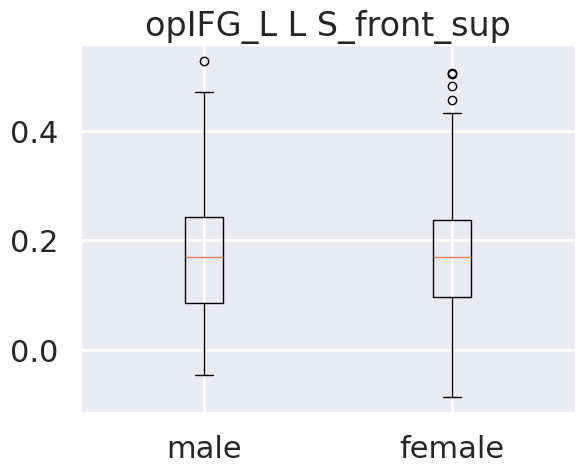

TtestResult(statistic=0.16750658280997677, pvalue=0.8670477340134027, df=444.0)
male mean : 0.17420680631400912
male std : 0.11912401318414584
female mean : 0.17235148060190264
female std : 0.11425827299617537


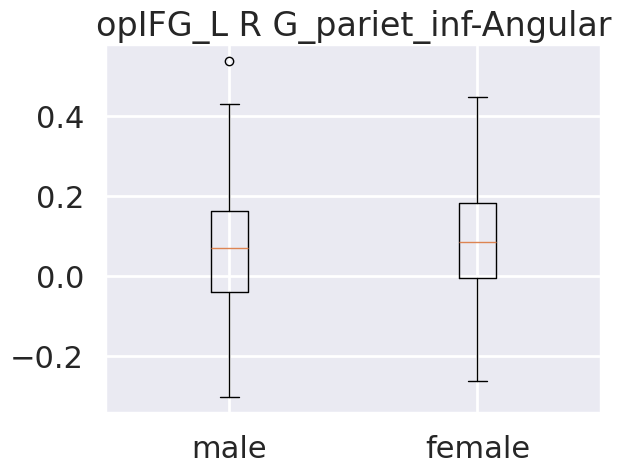

TtestResult(statistic=-1.2837042805959493, pvalue=0.199914972641604, df=444.0)
male mean : 0.07028634473590908
male std : 0.14273980163318048
female mean : 0.08705700692035398
female std : 0.13246296008577768


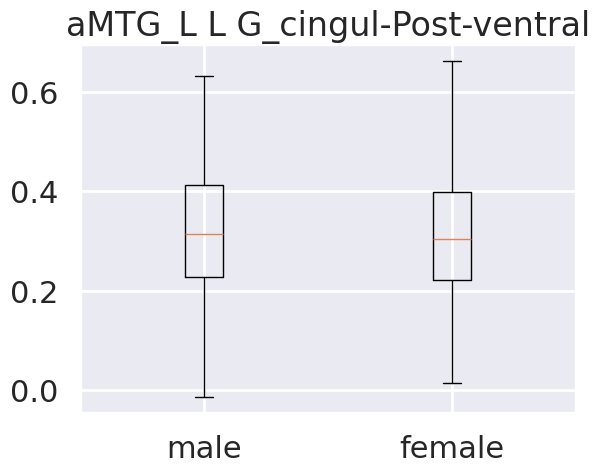

TtestResult(statistic=0.34553641189043366, pvalue=0.729854790212547, df=444.0)
male mean : 0.3196009154818181
male std : 0.12604857929946972
female mean : 0.31531212951327436
female std : 0.13518172022595426


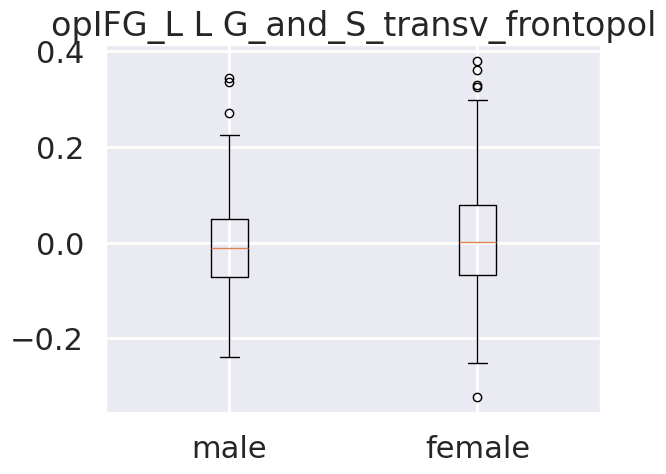

TtestResult(statistic=-1.6356167289057768, pvalue=0.10262849376599101, df=444.0)
male mean : -0.007709291982363636
male std : 0.1025075482709296
female mean : 0.008712956602389379
female std : 0.10885698253664537


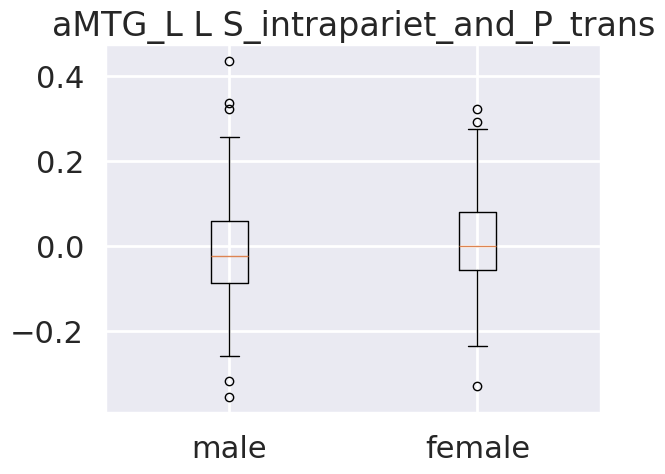

TtestResult(statistic=-2.1882039400431994, pvalue=0.02917519005188522, df=444.0)
male mean : -0.013163690943181816
male std : 0.11543664057625902
female mean : 0.01028722880575221
female std : 0.11037489457068743


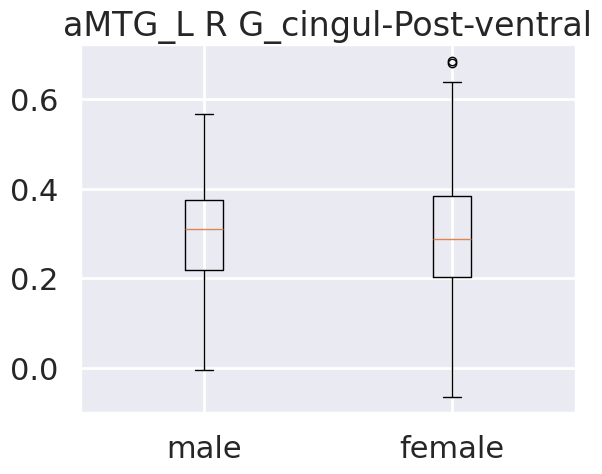

TtestResult(statistic=0.5696685420158588, pvalue=0.569190633014657, df=444.0)
male mean : 0.2980514330136363
male std : 0.12135344253894698
female mean : 0.29094439015752216
female std : 0.14054367406888102


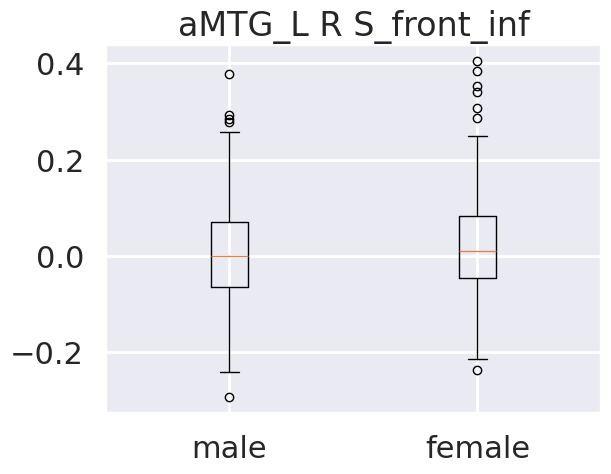

TtestResult(statistic=-1.3466607734060878, pvalue=0.17877651125344068, df=444.0)
male mean : 0.007340951230286363
male std : 0.11529808759000482
female mean : 0.02184227221641593
female std : 0.1116043211309179


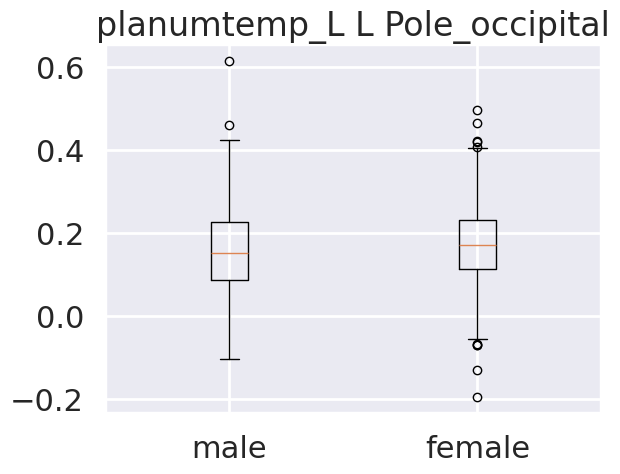

TtestResult(statistic=-1.2435986924357074, pvalue=0.21430350155941602, df=444.0)
male mean : 0.1626367214127273
male std : 0.10820773953855245
female mean : 0.17538109496858406
female std : 0.10771708400084226


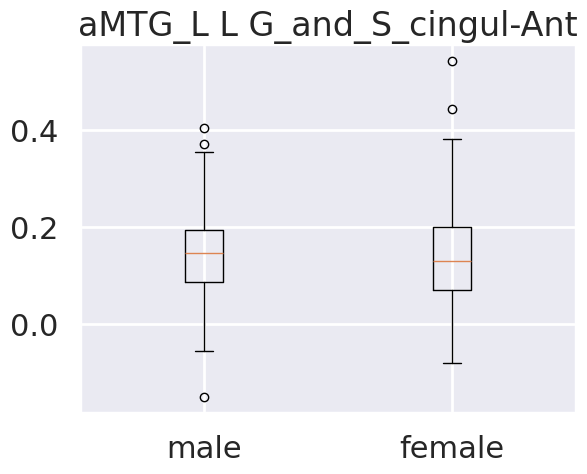

TtestResult(statistic=0.3413024497235528, pvalue=0.7330373624378532, df=444.0)
male mean : 0.1438657504609091
male std : 0.08680836057329544
female mean : 0.14089219320132743
female std : 0.09637799565302058


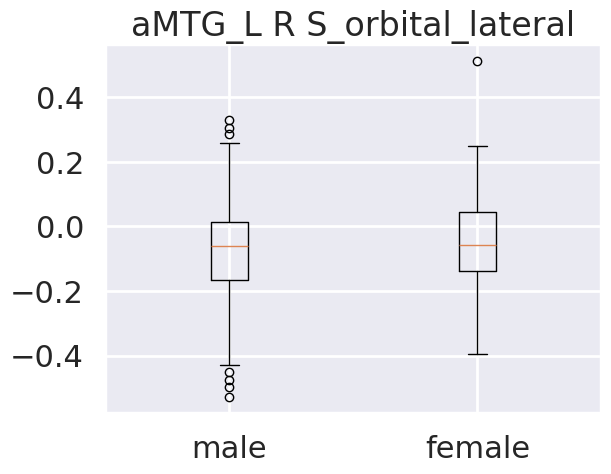

TtestResult(statistic=-1.6077494948748297, pvalue=0.10860088765355616, df=444.0)
male mean : -0.07217302953036363
male std : 0.1506820663019503
female mean : -0.05030928643159292
female std : 0.1356477770331538
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [42]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMTG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6878017857142857
The standard deviation of the accuracy : 0.030430134883962023
The lower boundry of the confidance interval of the accuracy : 0.6281587213417201
The upper boundry of the confidance interval of the accuracy : 0.7474448500868514

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.9740  18.0260
Homme            16.9402  33.0598
Mean sensitivity : 0.7225298449467529 Std sensitivity : 0.029493904389839197
Mean specificity : 0.6483918357546864 Std specificity : 0.03694493537740851

Testing accuracy
     coefficient    seed                       labels
53      0.281044  aMTG_L                L S_front_sup
98      0.250923  aMTG_L       R G_pariet_inf-Angular
131     0.183568  aMTG_L   R S_oc_sup_and_transversal
22      0.180551  aMTG_L      L G_oc-temp_med-Parahip
4       0.175986  aMTG_L   L G_and_S_transv_frontopol
104     0.173773  aMTG_L                   R G_rectus
103

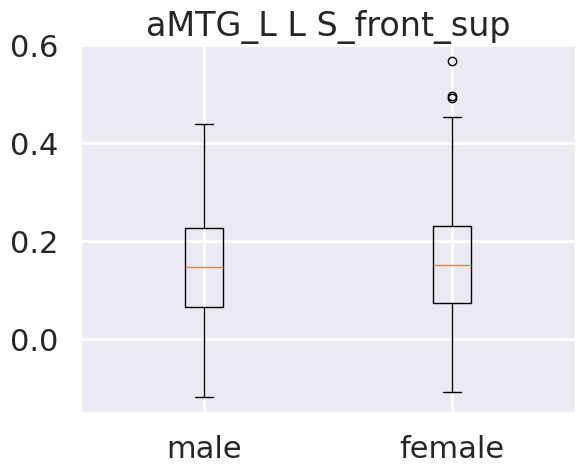

TtestResult(statistic=-1.1751106937355225, pvalue=0.2405802232243336, df=444.0)
male mean : 0.1478291311859091
male std : 0.11603800518100213
female mean : 0.16097970332891592
female std : 0.11967115083492198


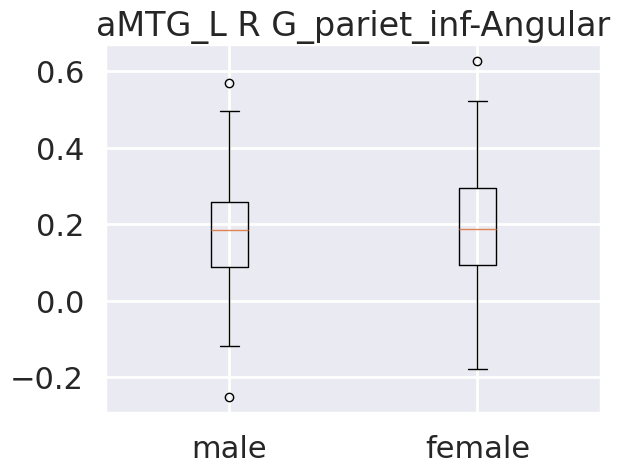

TtestResult(statistic=-1.0504936792226138, pvalue=0.2940626194797266, df=444.0)
male mean : 0.1780582094481818
male std : 0.13210061257409986
female mean : 0.1914749439579646
female std : 0.13688738170125272


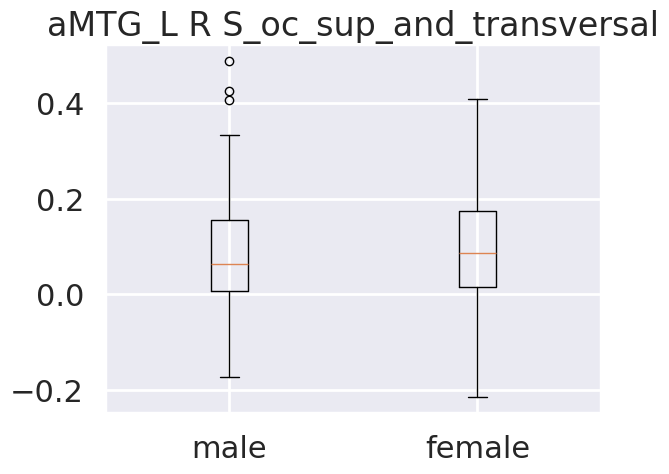

TtestResult(statistic=-1.1446329934212456, pvalue=0.25297787860802684, df=444.0)
male mean : 0.08033891944345455
male std : 0.11449052622994668
female mean : 0.0928965678300885
female std : 0.11662117465554366


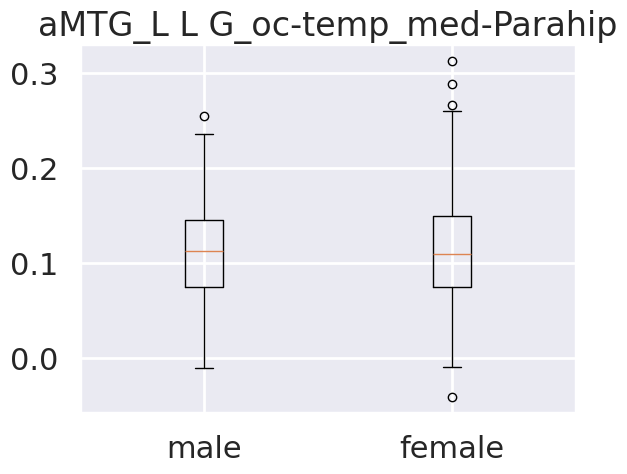

TtestResult(statistic=-0.4360799569615245, pvalue=0.6629906684830664, df=444.0)
male mean : 0.11350303190636363
male std : 0.05112342014996484
female mean : 0.11574139401150443
female std : 0.0567987213357124


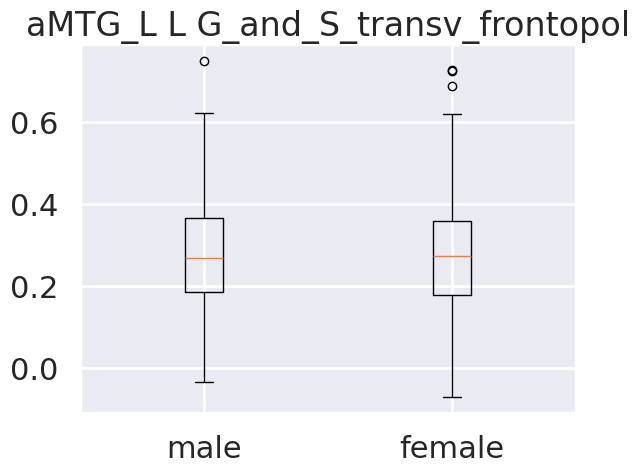

TtestResult(statistic=0.10138159638724922, pvalue=0.9192933110339168, df=444.0)
male mean : 0.2751853469045455
male std : 0.13433527982242252
female mean : 0.27389056597345135
female std : 0.13474382858851425


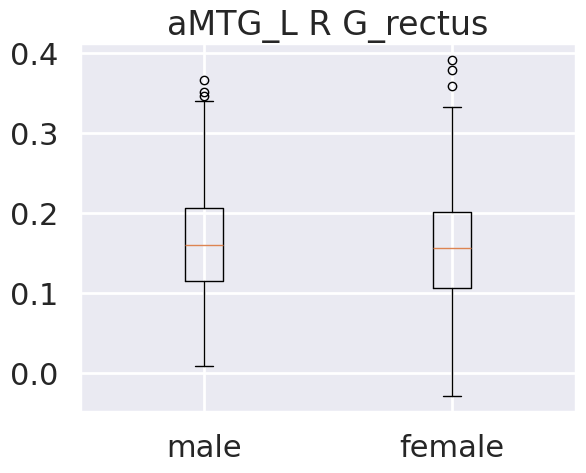

TtestResult(statistic=1.0532425726213273, pvalue=0.2928026663845215, df=444.0)
male mean : 0.1642284623545455
male std : 0.06926358511265035
female mean : 0.15729601249557523
female std : 0.06941326069895917


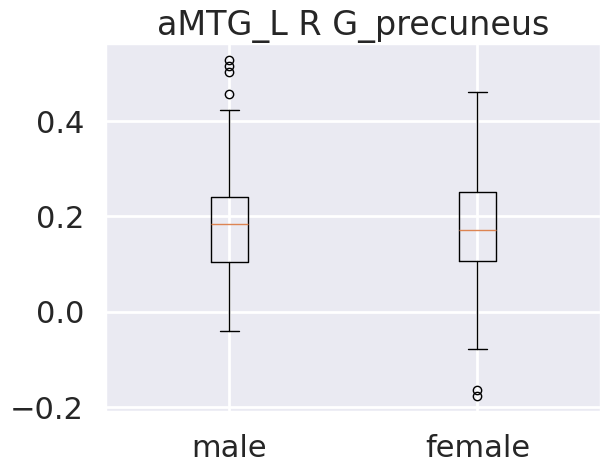

TtestResult(statistic=0.1010516489042115, pvalue=0.9195550755221649, df=444.0)
male mean : 0.17889595165909095
male std : 0.10655216802446173
female mean : 0.17786645619247785
female std : 0.10807313117970997


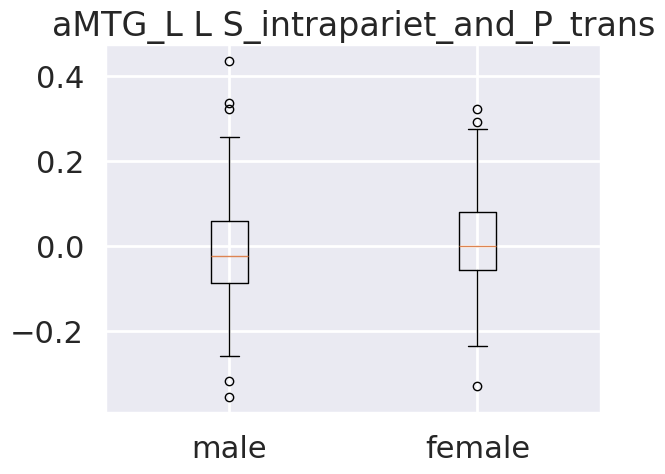

TtestResult(statistic=-2.1882039400431994, pvalue=0.02917519005188522, df=444.0)
male mean : -0.013163690943181816
male std : 0.11543664057625902
female mean : 0.01028722880575221
female std : 0.11037489457068743


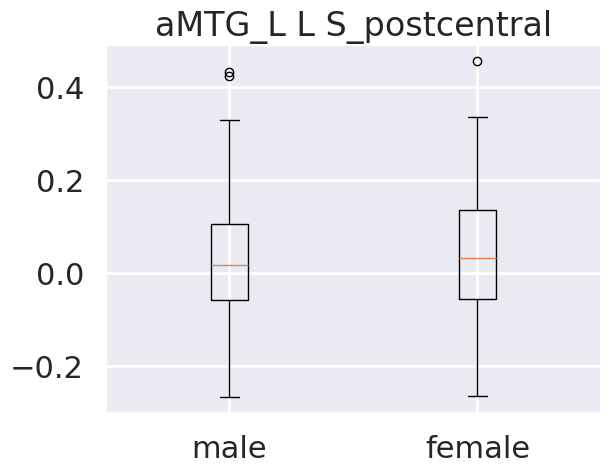

TtestResult(statistic=-1.1493793241412416, pvalue=0.25101835877760137, df=444.0)
male mean : 0.023039228635909095
male std : 0.13014753913717106
female mean : 0.03715971908592921
female std : 0.12871207875153445


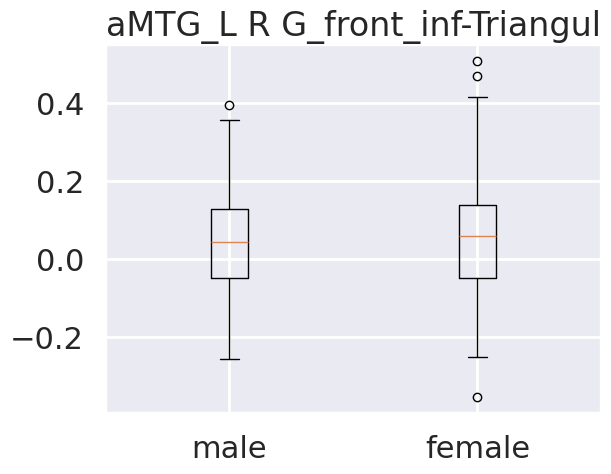

TtestResult(statistic=-0.8363357521123771, pvalue=0.40341591774654606, df=444.0)
male mean : 0.04320109813272727
male std : 0.13155418790842896
female mean : 0.054209747607079646
female std : 0.1452582861670815
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [43]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMRG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6687901785714286
The standard deviation of the accuracy : 0.032582043899393266
The lower boundry of the confidance interval of the accuracy : 0.6049293725286178
The upper boundry of the confidance interval of the accuracy : 0.7326509846142395

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            41.5573  20.4427
Homme            16.6528  33.3472
Mean sensitivity : 0.7148366001103809 Std sensitivity : 0.033535009011358786
Mean specificity : 0.6211492546608288 Std specificity : 0.0368221178952218

Testing accuracy
     coefficient    seed                       labels
66      0.235741  aMTG_R              L S_postcentral
53      0.235184  aMTG_R                L S_front_sup
22      0.215506  aMTG_R      L G_oc-temp_med-Parahip
98      0.214273  aMTG_R       R G_pariet_inf-Angular
55      0.196734  aMTG_R  L S_intrapariet_and_P_trans
96      0.173958  aMTG_R      R G_oc-temp_med-Parahip
4   

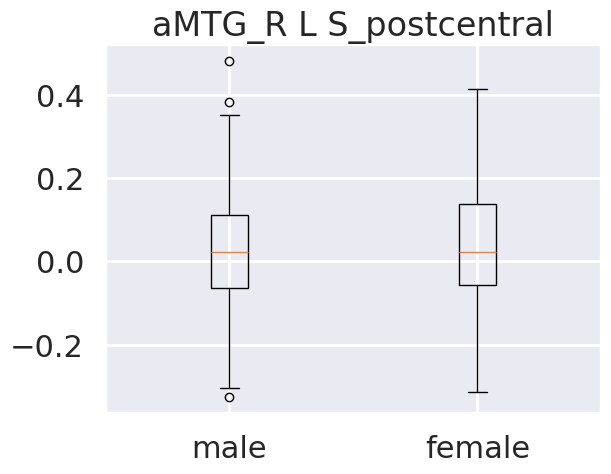

TtestResult(statistic=-0.8839635844535796, pvalue=0.3771942703547976, df=444.0)
male mean : 0.026656748687727275
male std : 0.13758083211770142
female mean : 0.0378210821830531
female std : 0.12848967152538782


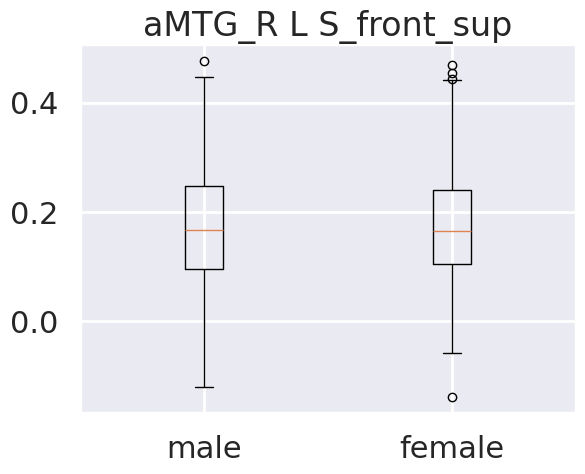

TtestResult(statistic=-0.618611589229639, pvalue=0.5364894911642072, df=444.0)
male mean : 0.16891179901768183
male std : 0.11339118600625214
female mean : 0.17535042696194691
female std : 0.10587547652331339


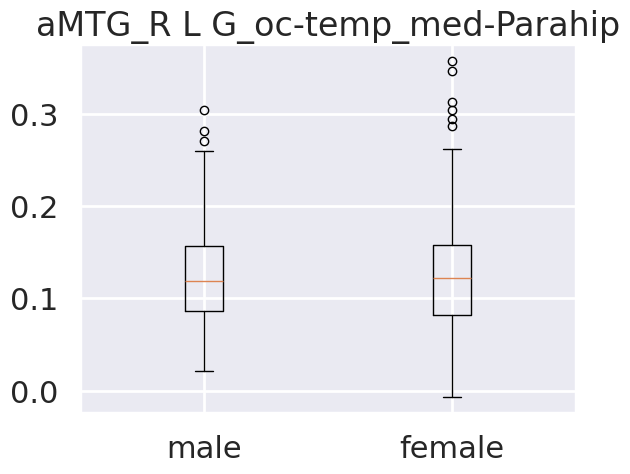

TtestResult(statistic=-0.5519803077155576, pvalue=0.5812395639659306, df=444.0)
male mean : 0.12449234937272725
male std : 0.054627669956499265
female mean : 0.12753133903938055
female std : 0.06110424601087162


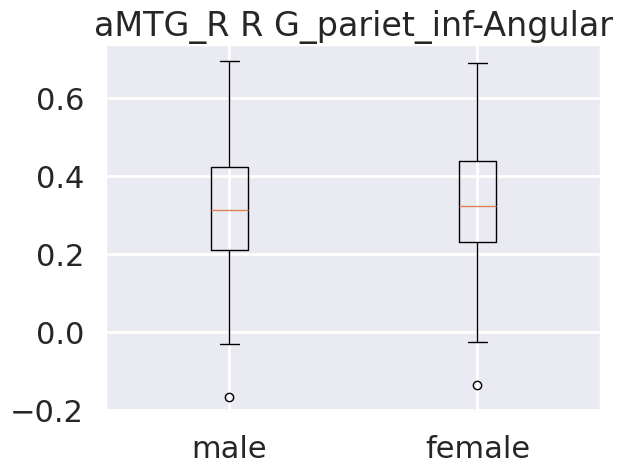

TtestResult(statistic=-0.8873251252086612, pvalue=0.3753842728975051, df=444.0)
male mean : 0.31095090691090904
male std : 0.14898750316302797
female mean : 0.32342581505752205
female std : 0.1472456136016748


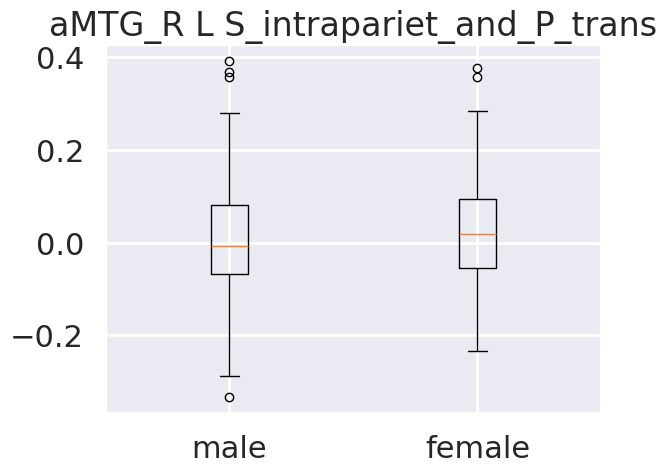

TtestResult(statistic=-1.5125186486936233, pvalue=0.13111340326959242, df=444.0)
male mean : 0.004585422339954544
male std : 0.11824601657800982
female mean : 0.021126754743805307
female std : 0.11217663406183852


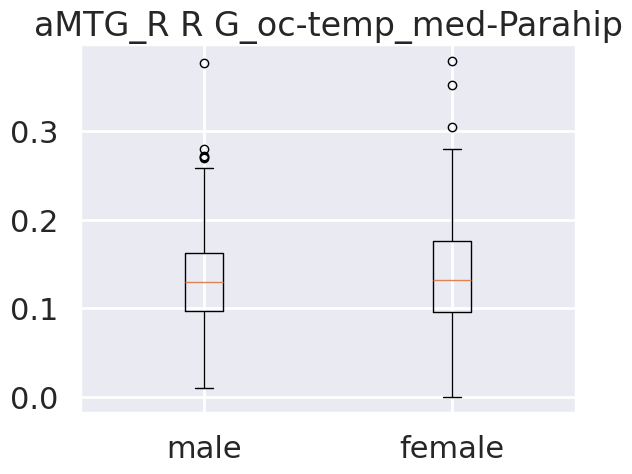

TtestResult(statistic=-0.9053119691450434, pvalue=0.36579112388962864, df=444.0)
male mean : 0.13470734202272724
male std : 0.05470723351375943
female mean : 0.13964757768075223
female std : 0.060070021782849134


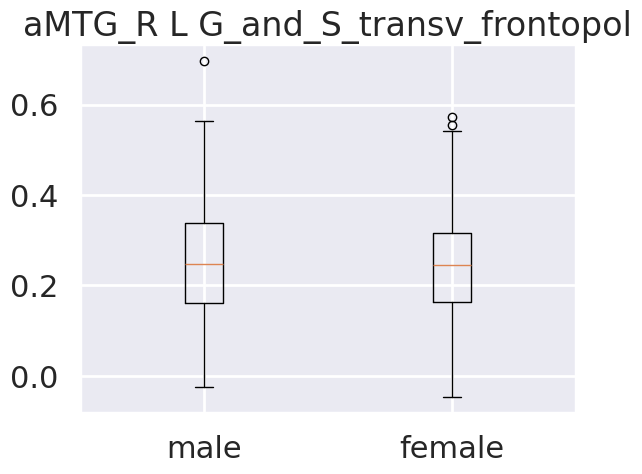

TtestResult(statistic=0.12361551761816675, pvalue=0.9016756443757344, df=444.0)
male mean : 0.24797954202636363
male std : 0.12113163803494588
female mean : 0.246577444440708
female std : 0.11786771525451314


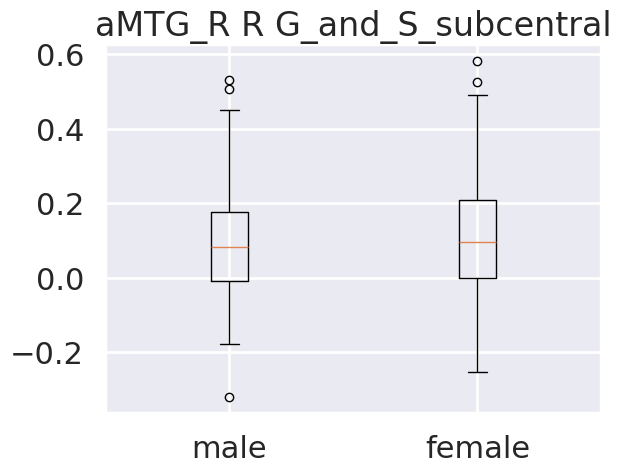

TtestResult(statistic=-0.8005291764654797, pvalue=0.4238323985426886, df=444.0)
male mean : 0.0913388444129409
male std : 0.13897496312617294
female mean : 0.10215918667168143
female std : 0.14564160493396786


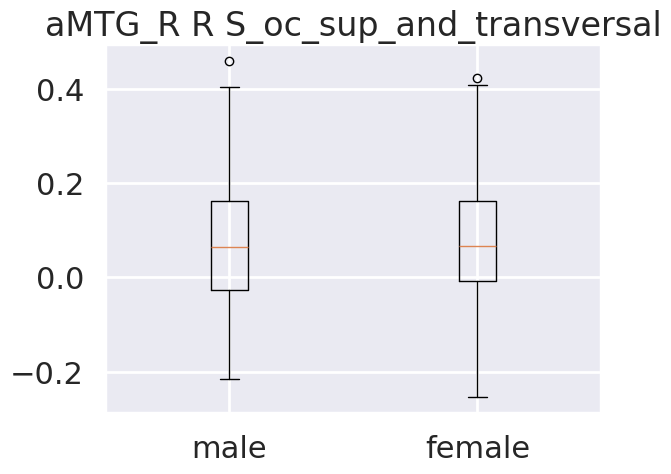

TtestResult(statistic=-0.8246809089033029, pvalue=0.4099955909982721, df=444.0)
male mean : 0.07375751430727273
male std : 0.12705495605947967
female mean : 0.08349445369911505
female std : 0.1217243205733012


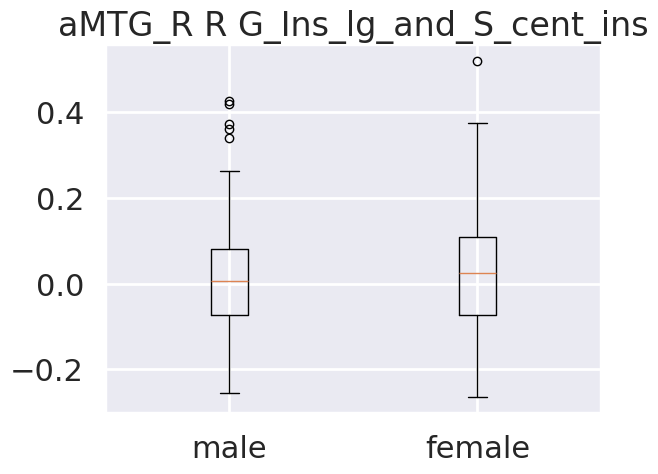

TtestResult(statistic=-0.8905061957246968, pvalue=0.3736764150669861, df=444.0)
male mean : 0.012881319693318183
male std : 0.11967301682808063
female mean : 0.02339473532876106
female std : 0.1287851717427992
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [44]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6940196428571428
The standard deviation of the accuracy : 0.030538335257191282
The lower boundry of the confidance interval of the accuracy : 0.6341645057530478
The upper boundry of the confidance interval of the accuracy : 0.7538747799612378

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.2005  18.7995
Homme            15.4703  34.5297
Mean sensitivity : 0.7367119038083971 Std sensitivity : 0.027888917028889758
Mean specificity : 0.6492900895528839 Std specificity : 0.03803593428104327

Testing accuracy
     coefficient     seed                       labels
125     0.202689  opIFG_L                R S_front_inf
20      0.200376  opIFG_L      L G_oc-temp_lat-fusifor
35      0.190572  opIFG_L      L G_temp_sup-Plan_tempo
144     0.189744  opIFG_L              R S_subparietal
91      0.188180  opIFG_L            R G_insular_short
79      0.158492  opIFG_L         R G_and_S_cingul-

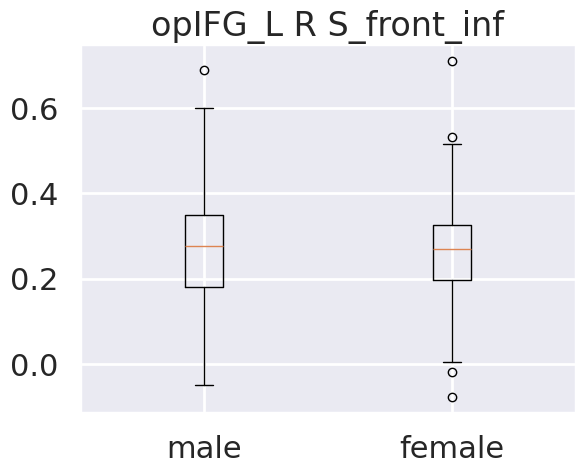

TtestResult(statistic=0.4086500580486553, pvalue=0.6829935111678093, df=444.0)
male mean : 0.26654276243181824
male std : 0.12183023146296644
female mean : 0.262082014039823
female std : 0.1079258885330421


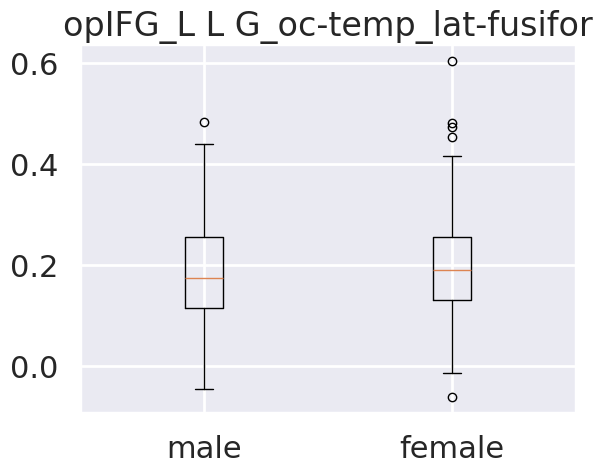

TtestResult(statistic=-1.2638383968246645, pvalue=0.20695117020945525, df=444.0)
male mean : 0.1852752198459091
male std : 0.10399941551678461
female mean : 0.1976116811152655
female std : 0.10167937677171758


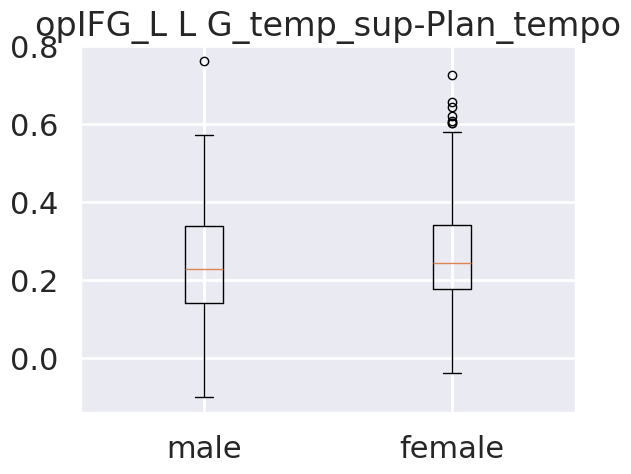

TtestResult(statistic=-1.0831643105663868, pvalue=0.27932336202798874, df=444.0)
male mean : 0.24882219316818183
male std : 0.14205533972004805
female mean : 0.2630661903274336
female std : 0.13502012539804434


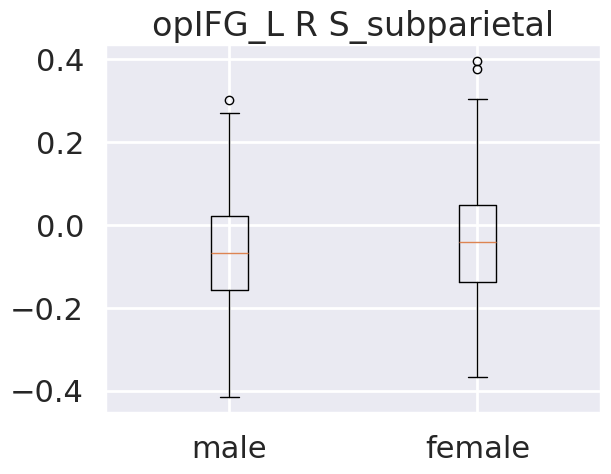

TtestResult(statistic=-2.255229197653168, pvalue=0.02460516436494521, df=444.0)
male mean : -0.06810169745361364
male std : 0.130743931634728
female mean : -0.03970042602168142
female std : 0.1345163981432872


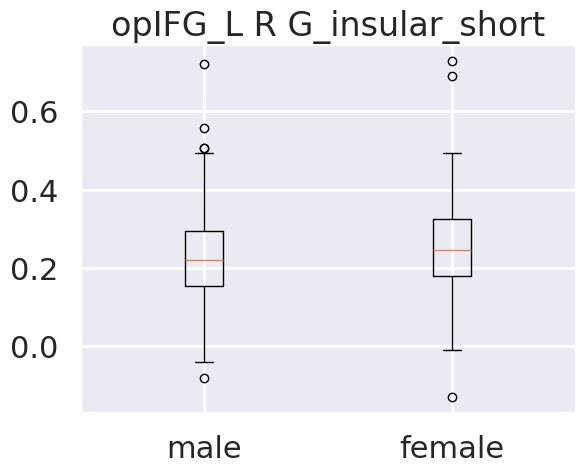

TtestResult(statistic=-1.9483857884698608, pvalue=0.051998443166544006, df=444.0)
male mean : 0.23052807419545454
male std : 0.1165855674991435
female mean : 0.2517310258230089
female std : 0.11271774145675777


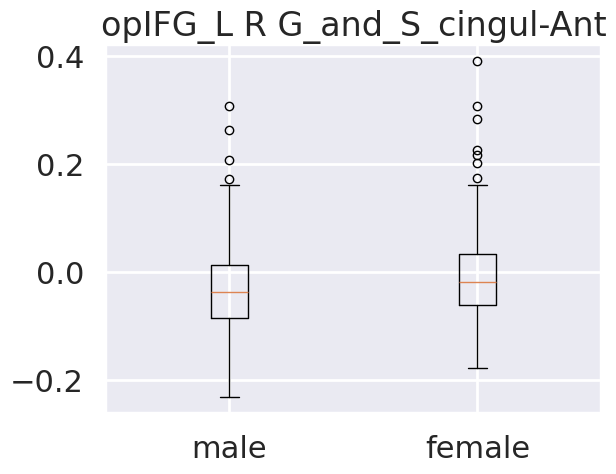

TtestResult(statistic=-3.0227918624798313, pvalue=0.0026495197276630482, df=444.0)
male mean : -0.03218565054136363
male std : 0.08257610031110921
female mean : -0.008124547059026547
female std : 0.08508167876146118


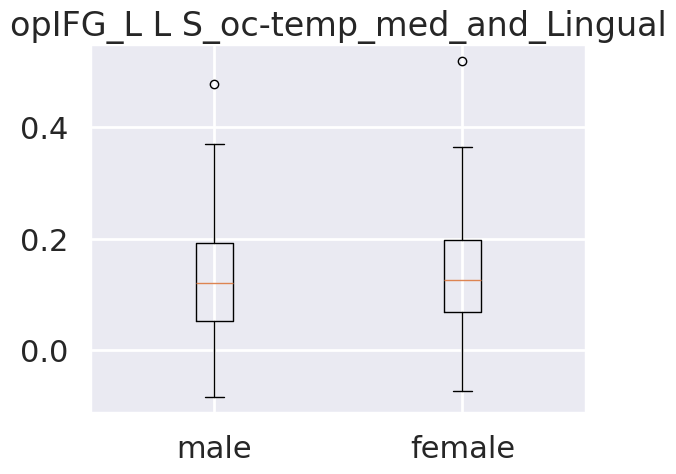

TtestResult(statistic=-1.1708065560376852, pvalue=0.24230452705784916, df=444.0)
male mean : 0.12574450147995456
male std : 0.09302276655386568
female mean : 0.13589799038230088
female std : 0.08971019426459184


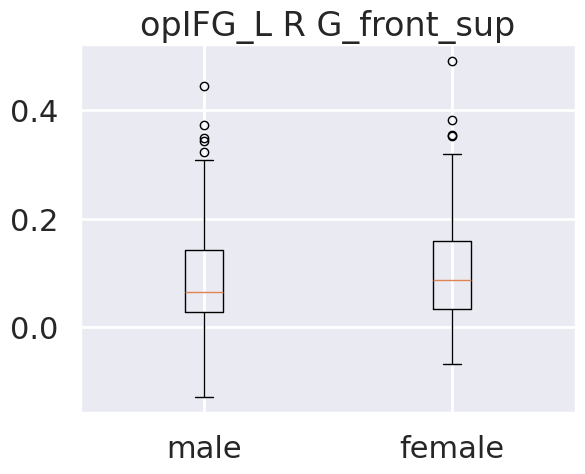

TtestResult(statistic=-2.0841613737881852, pvalue=0.037716598810496216, df=444.0)
male mean : 0.08459290856089545
male std : 0.09014405504647888
female mean : 0.10277003282153095
female std : 0.09353688114257062


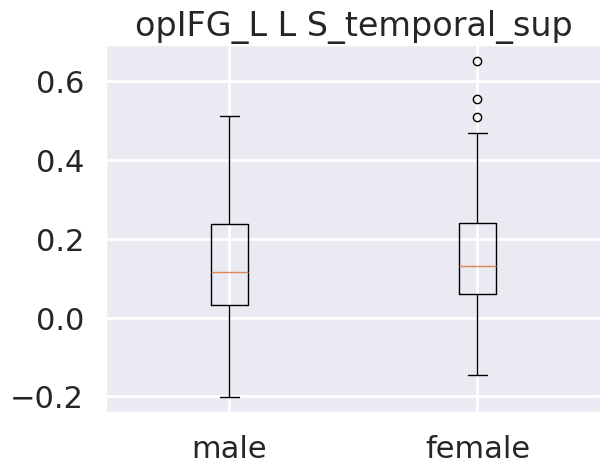

TtestResult(statistic=-1.6668928436809092, pvalue=0.09624090285099936, df=444.0)
male mean : 0.1341859774665909
male std : 0.13725138878207258
female mean : 0.15578860545663717
female std : 0.13581971819564176


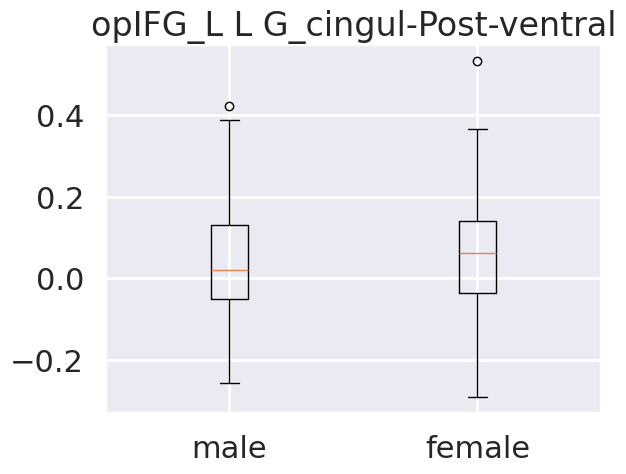

TtestResult(statistic=-2.100968084686296, pvalue=0.0362069630381018, df=444.0)
male mean : 0.03554070706545455
male std : 0.13401356952336016
female mean : 0.06211028690730089
female std : 0.13245388494884863
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [45]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6548526785714286
The standard deviation of the accuracy : 0.032209885159822114
The lower boundry of the confidance interval of the accuracy : 0.5917213036581772
The upper boundry of the confidance interval of the accuracy : 0.71798405348468

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            41.9849  20.0151
Homme            18.6414  31.3586
Mean sensitivity : 0.6934755091709768 Std sensitivity : 0.031987495541884785
Mean specificity : 0.6119239601686499 Std specificity : 0.0385823736950234

Testing accuracy
     coefficient     seed                       labels
125     0.234703  opIFG_R                R S_front_inf
80      0.224280  opIFG_R     R G_and_S_cingul-Mid-Ant
91      0.181864  opIFG_R            R G_insular_short
144     0.168338  opIFG_R              R S_subparietal
20      0.165930  opIFG_R      L G_oc-temp_lat-fusifor
90      0.165617  opIFG_R    R G_Ins_lg_and_S_cent_ins

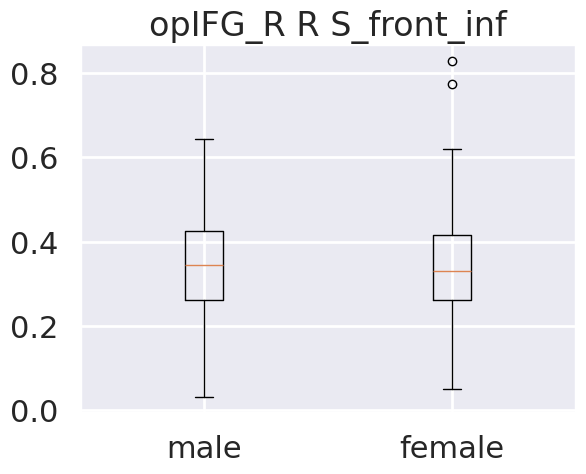

TtestResult(statistic=0.07824764428435962, pvalue=0.9376663141192548, df=444.0)
male mean : 0.34005799472272724
male std : 0.12011722857425006
female mean : 0.33916035776991155
female std : 0.12156179483366066


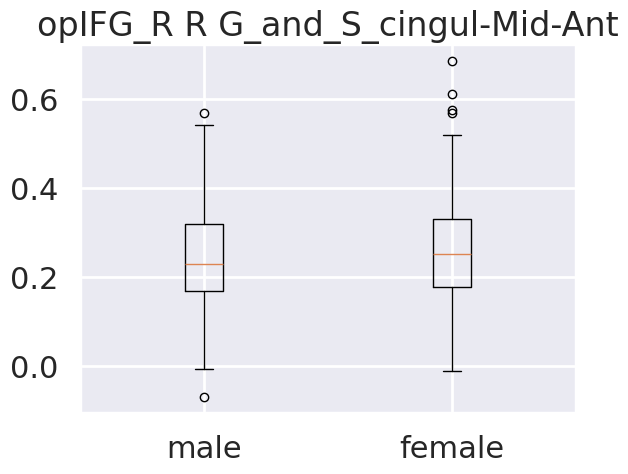

TtestResult(statistic=-1.3748727926649786, pvalue=0.16986429217416193, df=444.0)
male mean : 0.24635864027499998
male std : 0.11516632092045041
female mean : 0.2615508734380531
female std : 0.11760331507617267


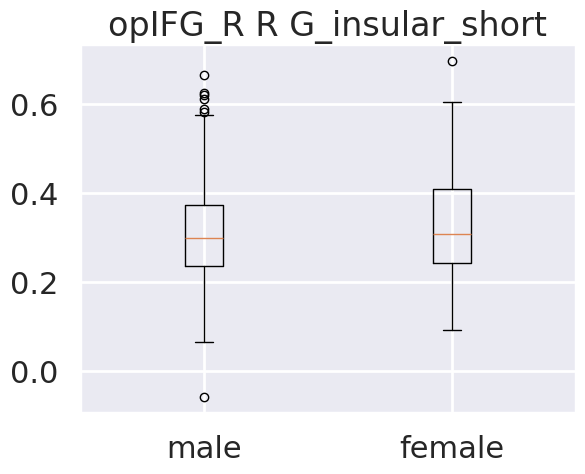

TtestResult(statistic=-1.5464901510054458, pvalue=0.12269867710134007, df=444.0)
male mean : 0.3078548638818182
male std : 0.11469814537547501
female mean : 0.3243126586106195
female std : 0.10953304822651043


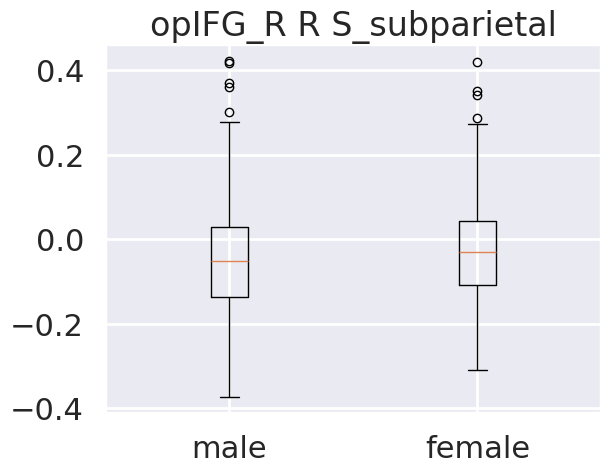

TtestResult(statistic=-1.0921853945954056, pvalue=0.2753438921573556, df=444.0)
male mean : -0.04254435420895455
male std : 0.13684442723315043
female mean : -0.02898507946176991
female std : 0.12460643733606609


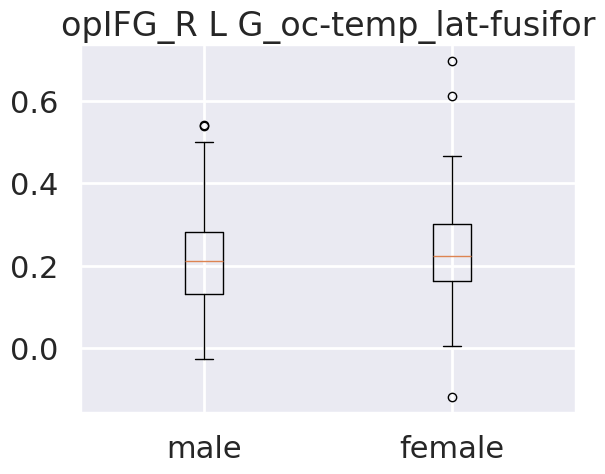

TtestResult(statistic=-2.29716549134702, pvalue=0.02207379859910422, df=444.0)
male mean : 0.20977229161136365
male std : 0.11066063251886343
female mean : 0.2329616213340708
female std : 0.1019691662512371


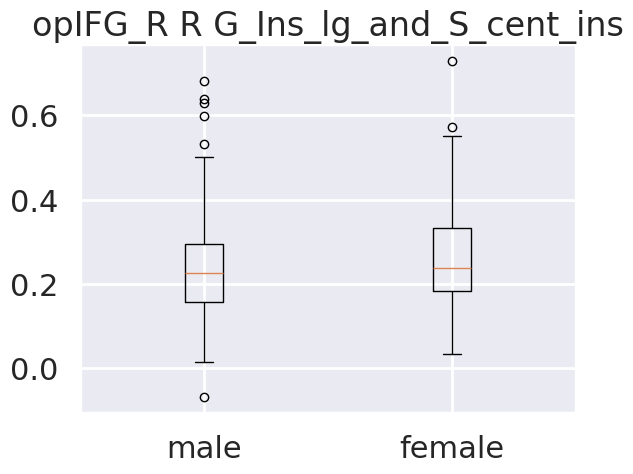

TtestResult(statistic=-1.7513618512678981, pvalue=0.08057407697245846, df=444.0)
male mean : 0.2380365514045454
male std : 0.12065856111230373
female mean : 0.257194790420354
female std : 0.1097077837749769


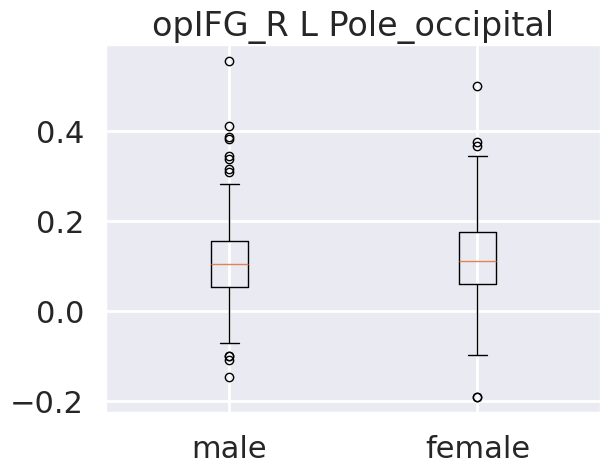

TtestResult(statistic=-0.8499022515546059, pvalue=0.39583748515462625, df=444.0)
male mean : 0.10983404132499999
male std : 0.09331687031129511
female mean : 0.11748476656694691
female std : 0.09628438956655336


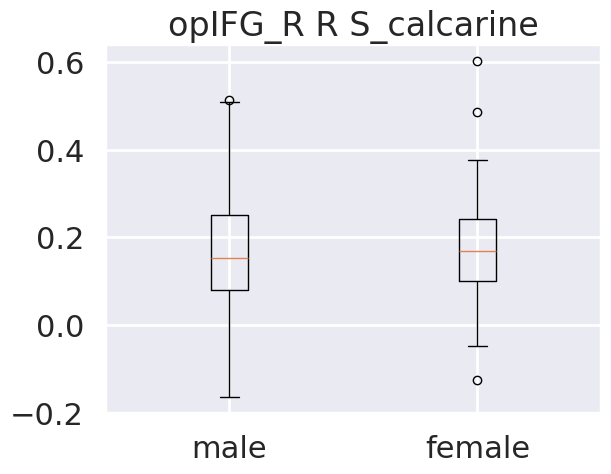

TtestResult(statistic=-0.17079795017895402, pvalue=0.8644604459855876, df=444.0)
male mean : 0.169357396905
male std : 0.11607212279567788
female mean : 0.17113548844513274
female std : 0.10305961126475156


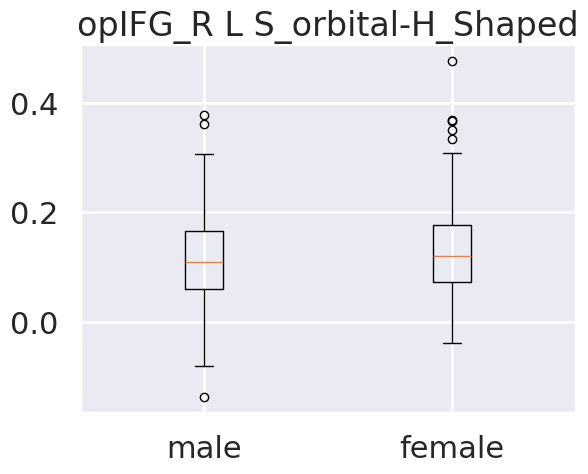

TtestResult(statistic=-1.8211549604303432, pvalue=0.06925614826074802, df=444.0)
male mean : 0.1127359650518182
male std : 0.08283471471021238
female mean : 0.12708223832964602
female std : 0.08313660035751222


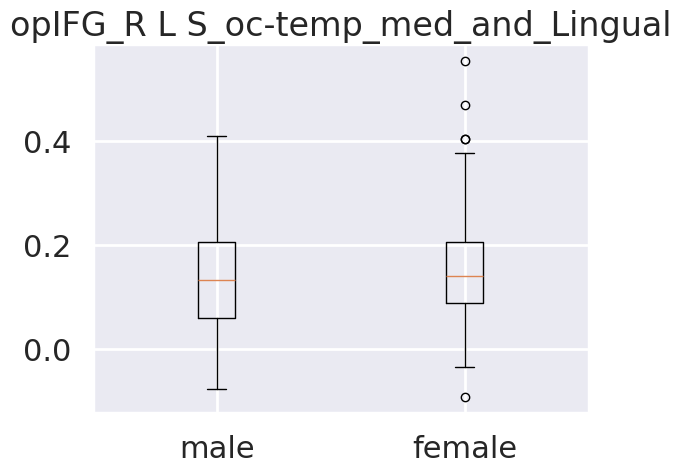

TtestResult(statistic=-1.9059588142115067, pvalue=0.05730102541114172, df=444.0)
male mean : 0.13532920261136364
male std : 0.09565515521861166
female mean : 0.15221455751504426
female std : 0.09100849007116237
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [46]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()



acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6420401785714285
The standard deviation of the accuracy : 0.029524732030938475
The lower boundry of the confidance interval of the accuracy : 0.5841717037907891
The upper boundry of the confidance interval of the accuracy : 0.6999086533520679

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            39.2558  22.7442
Homme            17.3473  32.6527
Mean sensitivity : 0.6940256600463537 Std sensitivity : 0.028890564810567537
Mean specificity : 0.5906843163587344 Std specificity : 0.03297372694426916

Testing accuracy
     coefficient    seed                       labels
26      0.258569  pITG_L             L G_parietal_sup
125     0.251404  pITG_L                R S_front_inf
9       0.229381  pITG_L      L G_cingul-Post-ventral
73      0.196164  pITG_L      L S_temporal_transverse
20      0.178793  pITG_L      L G_oc-temp_lat-fusifor
75      0.174681  pITG_L      R G_and_S_occipital_inf
83 

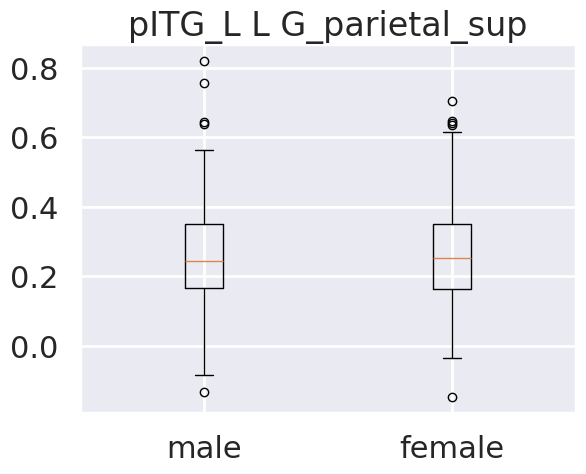

TtestResult(statistic=-0.12129658106863565, pvalue=0.9035110023768325, df=444.0)
male mean : 0.2595429796336363
male std : 0.14901430084909142
female mean : 0.261261912364292
female std : 0.1495591034508161


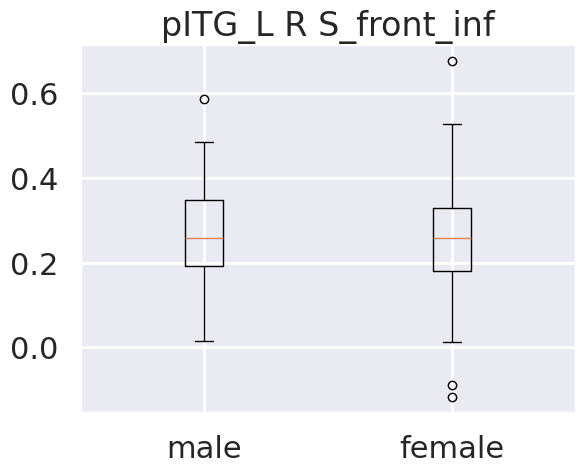

TtestResult(statistic=0.9477650717849536, pvalue=0.34376460657295227, df=444.0)
male mean : 0.26978528341363633
male std : 0.10201725087516947
female mean : 0.26001370624778763
female std : 0.11467183869640453


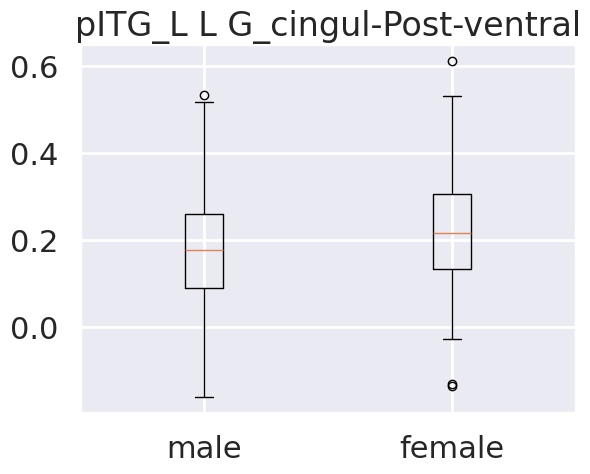

TtestResult(statistic=-3.320492387657934, pvalue=0.0009727313722355909, df=444.0)
male mean : 0.18068189929045453
male std : 0.12614943086046992
female mean : 0.21968866698230086
female std : 0.12137700264454868


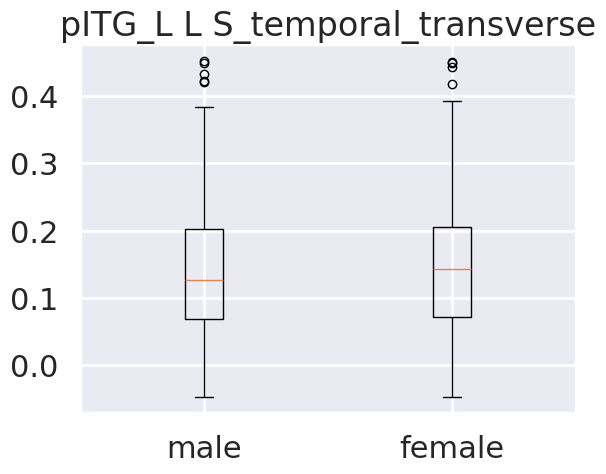

TtestResult(statistic=-0.999236588597994, pvalue=0.3182243516277546, df=444.0)
male mean : 0.14135478062136364
male std : 0.1010809475360238
female mean : 0.1508172054809734
female std : 0.09845703684947031


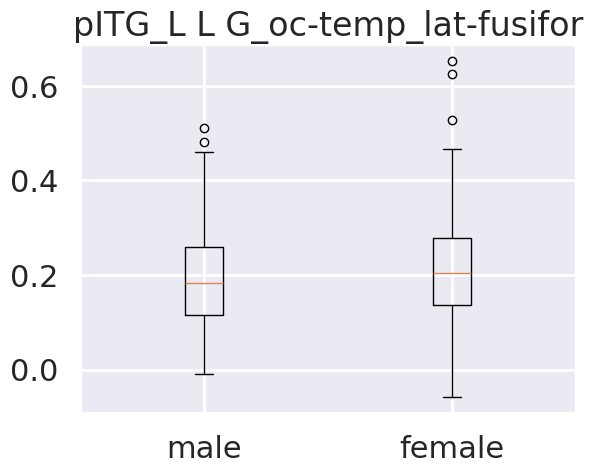

TtestResult(statistic=-1.9997257217840894, pvalue=0.046138656602001324, df=444.0)
male mean : 0.19146992757590908
male std : 0.10384546578866019
female mean : 0.2117008698230088
female std : 0.10917245497409923


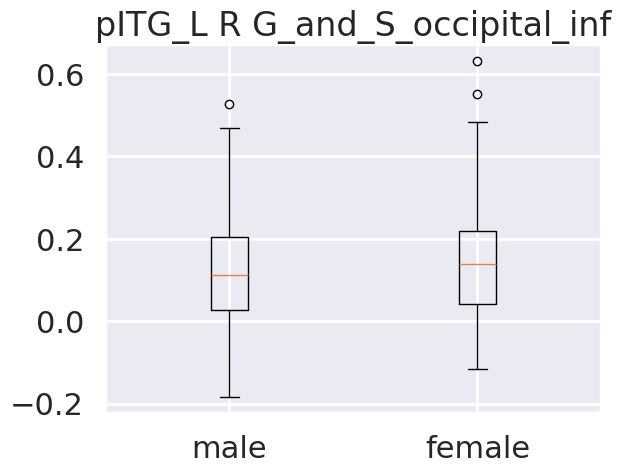

TtestResult(statistic=-2.16794219961621, pvalue=0.030693671100870415, df=444.0)
male mean : 0.11865208448627275
male std : 0.13429037299904675
female mean : 0.1455370280376106
female std : 0.12699033303739005


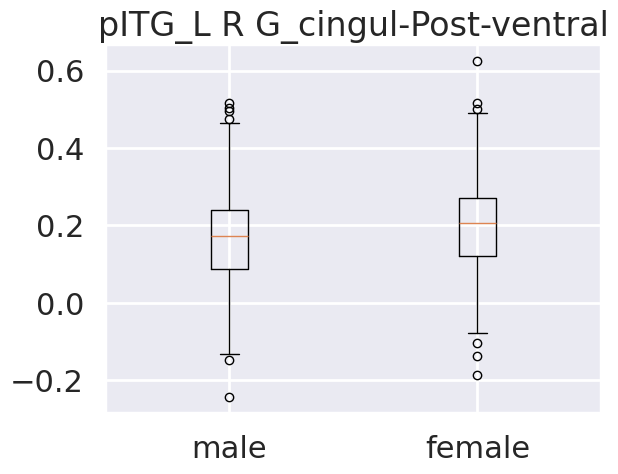

TtestResult(statistic=-2.648787167537202, pvalue=0.008366045127441709, df=444.0)
male mean : 0.17091063918281815
male std : 0.12692469455741226
female mean : 0.20225136862566373
female std : 0.12239044665822837


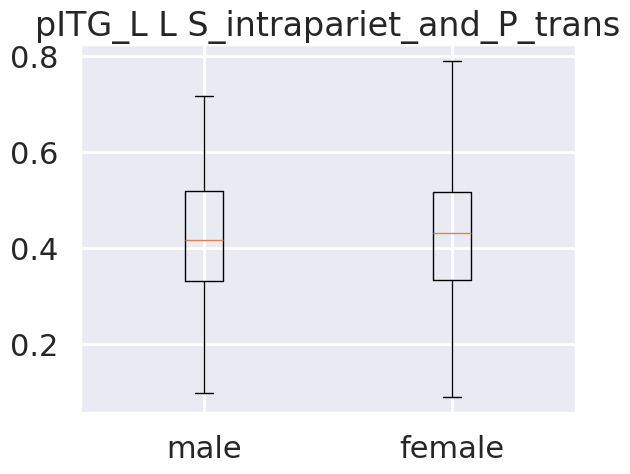

TtestResult(statistic=0.04334551637408842, pvalue=0.9654455946119826, df=444.0)
male mean : 0.4269157229090909
male std : 0.1275704914743609
female mean : 0.42637829978318587
female std : 0.13351276855842006


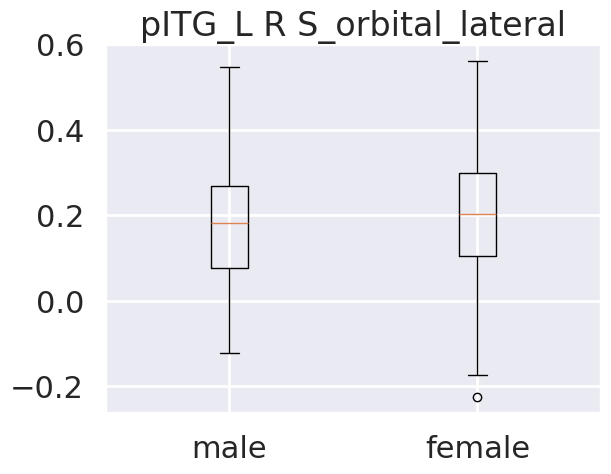

TtestResult(statistic=-1.9588548978405047, pvalue=0.05075529539747893, df=444.0)
male mean : 0.17842747502786363
male std : 0.1340949298580066
female mean : 0.20465929190884957
female std : 0.14755185247495148


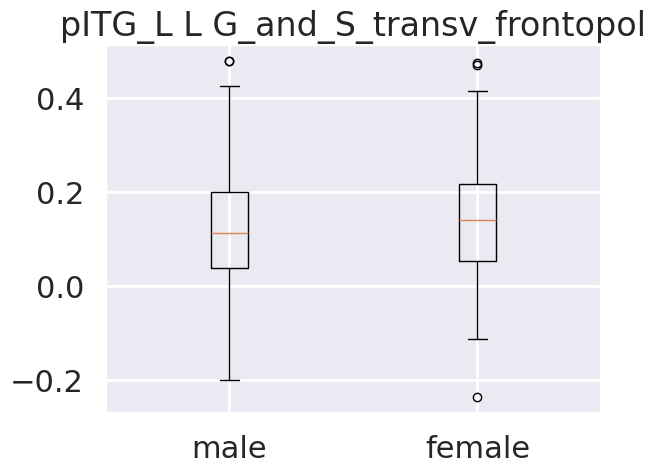

TtestResult(statistic=-1.6503752489496861, pvalue=0.09957337227410189, df=444.0)
male mean : 0.12125757842500001
male std : 0.11613881441030086
female mean : 0.1398216657579646
female std : 0.12075137888041303
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [47]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()



acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6769830357142856
The standard deviation of the accuracy : 0.026632076629139478
The lower boundry of the confidance interval of the accuracy : 0.6247841655211722
The upper boundry of the confidance interval of the accuracy : 0.7291819059073991

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.4636  18.5364
Homme            17.6415  32.3585
Mean sensitivity : 0.7121188127201378 Std sensitivity : 0.026923144322169322
Mean specificity : 0.6371372145822212 Std specificity : 0.033218754844334966

Testing accuracy
     coefficient    seed                    labels
20      0.317350  pITG_R   L G_oc-temp_lat-fusifor
83      0.207225  pITG_R   R G_cingul-Post-ventral
91      0.203452  pITG_R         R G_insular_short
84      0.195611  pITG_R                R G_cuneus
125     0.194242  pITG_R             R S_front_inf
72      0.162033  pITG_R          L S_temporal_sup
80      0.158161  pITG_

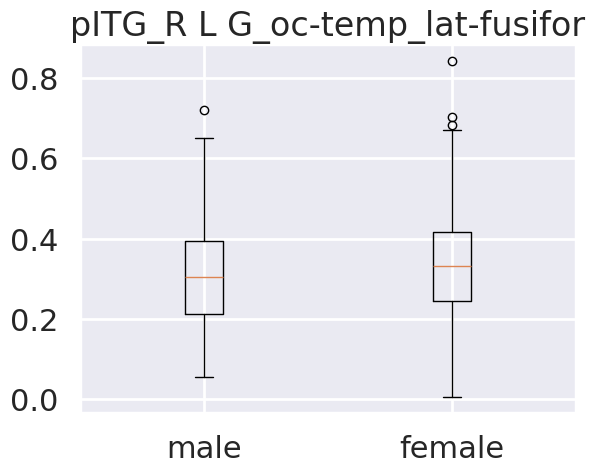

TtestResult(statistic=-1.5815614794109938, pvalue=0.11446176972894939, df=444.0)
male mean : 0.3142464540681818
male std : 0.12940759024345122
female mean : 0.3339439768207965
female std : 0.1329297793217458


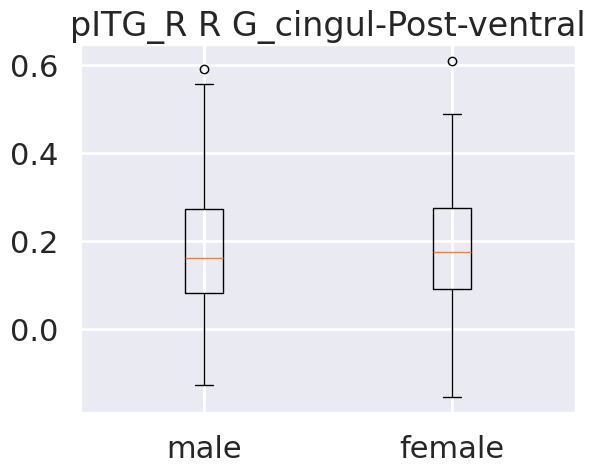

TtestResult(statistic=-0.6463818437115583, pvalue=0.5183660620704027, df=444.0)
male mean : 0.17339958317136364
male std : 0.1369603399128416
female mean : 0.18168219715398232
female std : 0.1330432358240209


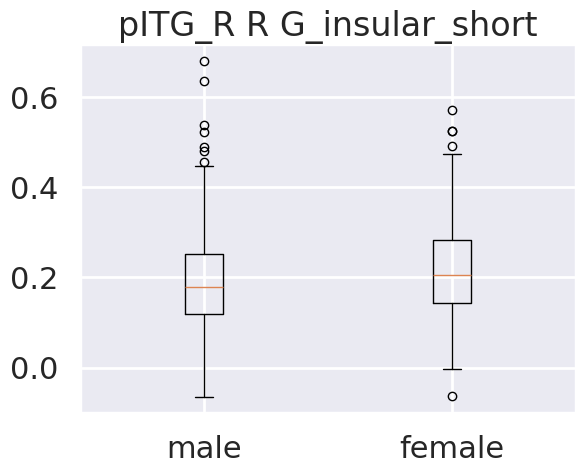

TtestResult(statistic=-2.328426709387253, pvalue=0.02033763180117438, df=444.0)
male mean : 0.19266768437636367
male std : 0.11434823137498168
female mean : 0.21694431726106198
female std : 0.10525967715183271


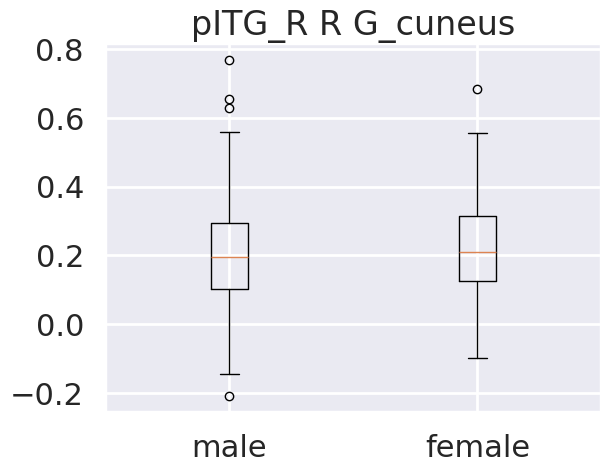

TtestResult(statistic=-1.0934027940647248, pvalue=0.2748098488417033, df=444.0)
male mean : 0.20146964876045453
male std : 0.15074304393476953
female mean : 0.21656654805309736
female std : 0.14011654309961546


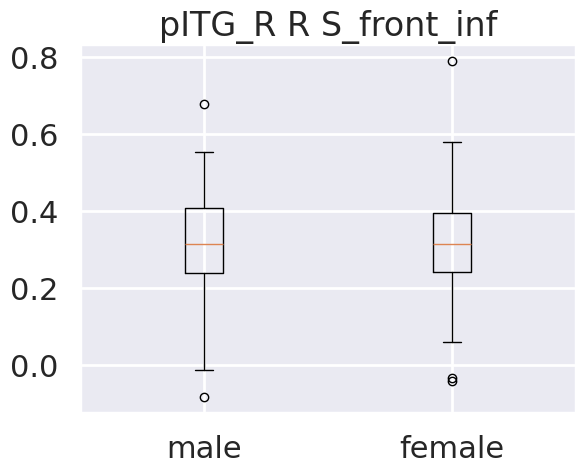

TtestResult(statistic=0.3908074707197447, pvalue=0.696127001791975, df=444.0)
male mean : 0.32033409866363627
male std : 0.11423757093954032
female mean : 0.31611755039380535
female std : 0.11309947336689506


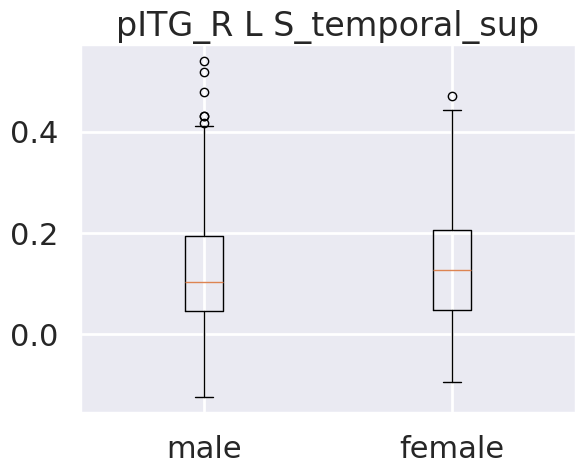

TtestResult(statistic=-0.9746923661855857, pvalue=0.330243605204655, df=444.0)
male mean : 0.12475287854954546
male std : 0.12241383067525949
female mean : 0.13580745320553098
female std : 0.11655394989976599


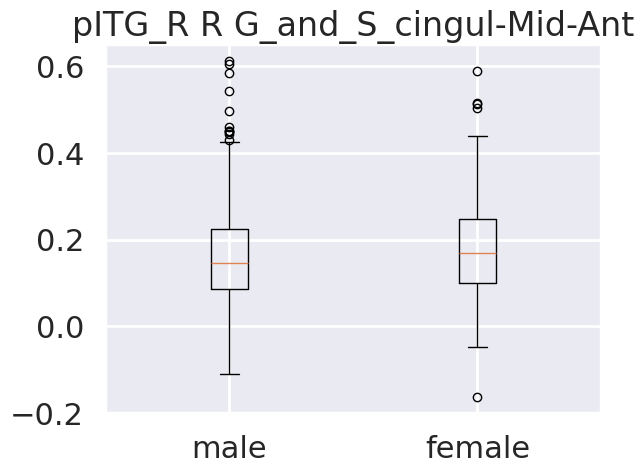

TtestResult(statistic=-1.5924893724514355, pvalue=0.1119864318979292, df=444.0)
male mean : 0.16204798098045456
male std : 0.1234327883958888
female mean : 0.18022160827876108
female std : 0.11701371747106165


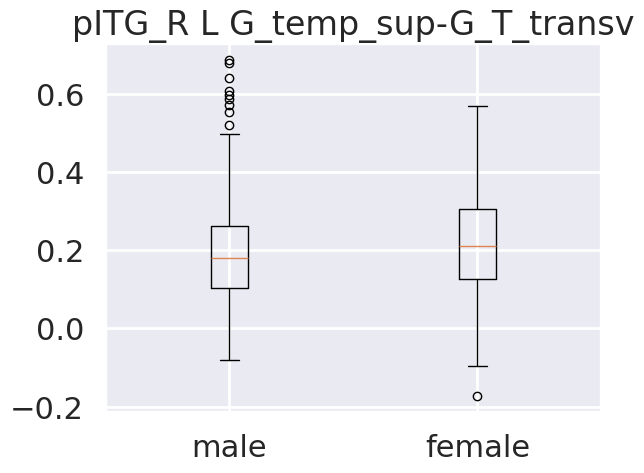

TtestResult(statistic=-1.4614819346160086, pvalue=0.14459057650918922, df=444.0)
male mean : 0.20179328301727273
male std : 0.1399808402067357
female mean : 0.2204069526106195
female std : 0.12826420044226047


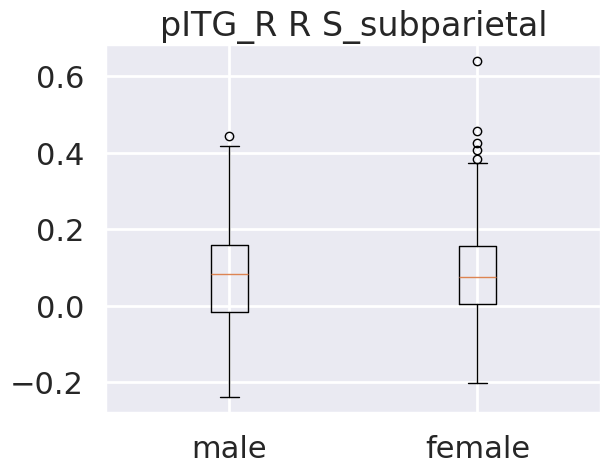

TtestResult(statistic=-0.7417313324375713, pvalue=0.4586422899123237, df=444.0)
male mean : 0.07628993686150001
male std : 0.1341566791012869
female mean : 0.0856920734276991
female std : 0.1329313033129608


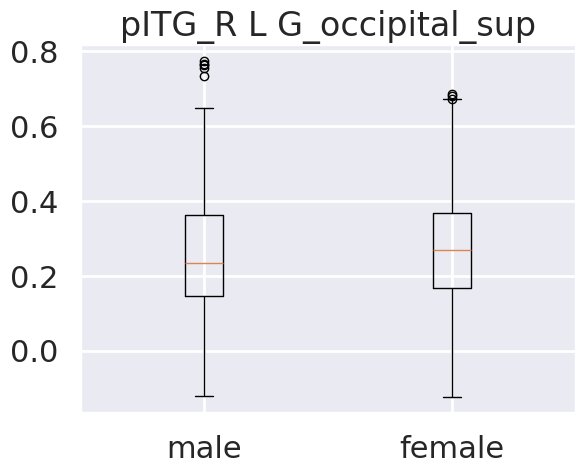

TtestResult(statistic=-1.1696531404610266, pvalue=0.24276808136056222, df=444.0)
male mean : 0.25802477958709086
male std : 0.16959029619725396
female mean : 0.27610700421106193
female std : 0.15603173247007288
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [48]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_L validation accuracy

Validation accuracy
The mean accuracy : 0.6838375000000001
The standard deviation of the accuracy : 0.030617757317245742
The lower boundry of the confidance interval of the accuracy : 0.6238266956581985
The upper boundry of the confidance interval of the accuracy : 0.7438483043418017

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            48.0486  13.9514
Homme            21.4588  28.5412
Mean sensitivity : 0.692186413422034 Std sensitivity : 0.02910115488706826
Mean specificity : 0.6726303933829149 Std specificity : 0.04117240802243795

Testing accuracy
     coefficient          seed                       labels
60      0.285785  planumtemp_L  L S_oc-temp_med_and_Lingual
66      0.214379  planumtemp_L              L S_postcentral
108     0.189177  planumtemp_L      R G_temp_sup-Plan_polar
20      0.177437  planumtemp_L      L G_oc-temp_lat-fusifor
99      0.169222  planumtemp_L      R G_pariet_inf-Supramar
32      0.146572  planu

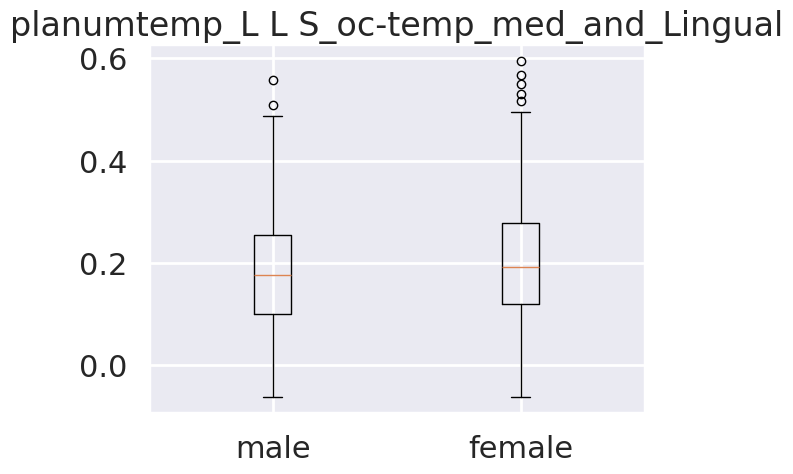

TtestResult(statistic=-0.9820015316846226, pvalue=0.32663388009863603, df=444.0)
male mean : 0.19011748165318185
male std : 0.1193422763151143
female mean : 0.20115719377787614
female std : 0.11753841774848728


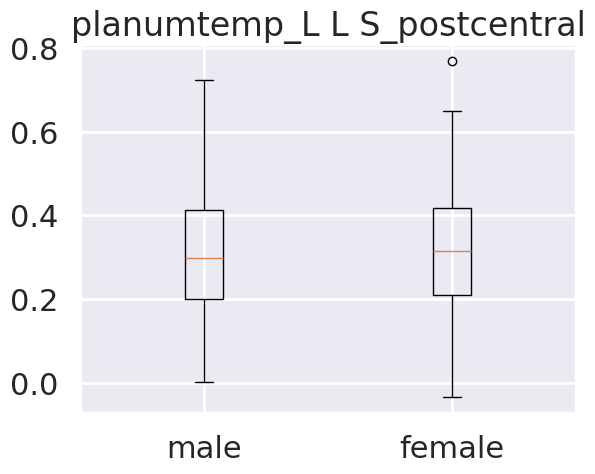

TtestResult(statistic=-0.9006522843417153, pvalue=0.3682614776953038, df=444.0)
male mean : 0.30515063129272724
male std : 0.14829154428115549
female mean : 0.3179469554849557
female std : 0.1510102266162187


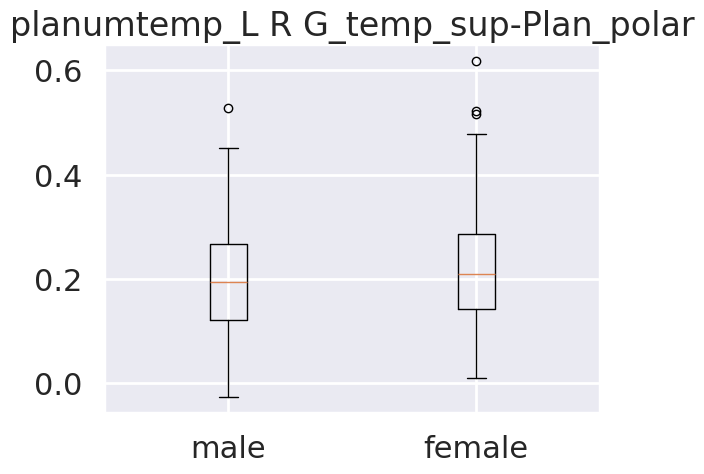

TtestResult(statistic=-1.7779244749091152, pvalue=0.07610058281626102, df=444.0)
male mean : 0.2006715641090909
male std : 0.10382583582105692
female mean : 0.21812659282964603
female std : 0.10303515540801055


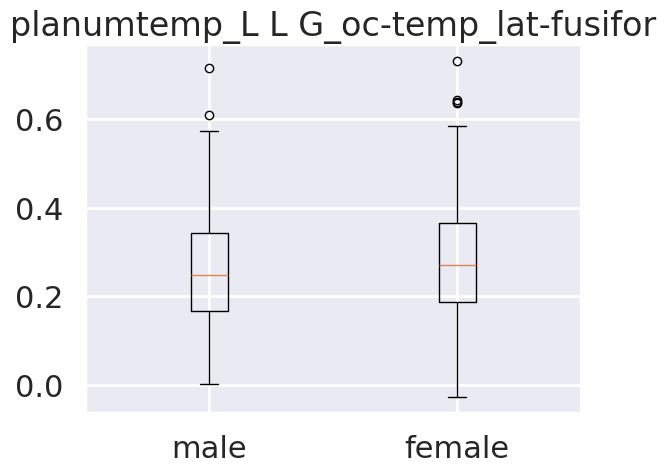

TtestResult(statistic=-1.7822965033456104, pvalue=0.0753841358030238, df=444.0)
male mean : 0.26045696333181817
male std : 0.12930470682611547
female mean : 0.28205850225221235
female std : 0.12608069732332455


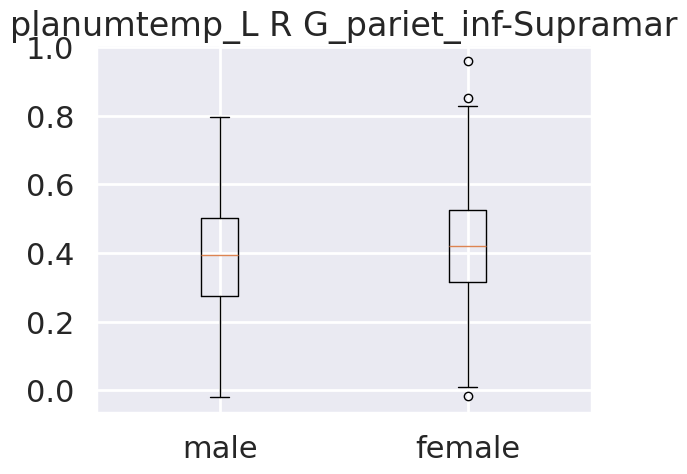

TtestResult(statistic=-2.004646579028185, pvalue=0.04560752374176003, df=444.0)
male mean : 0.3890049477772727
male std : 0.15755888205414556
female mean : 0.419655279880531
female std : 0.16441940722108642


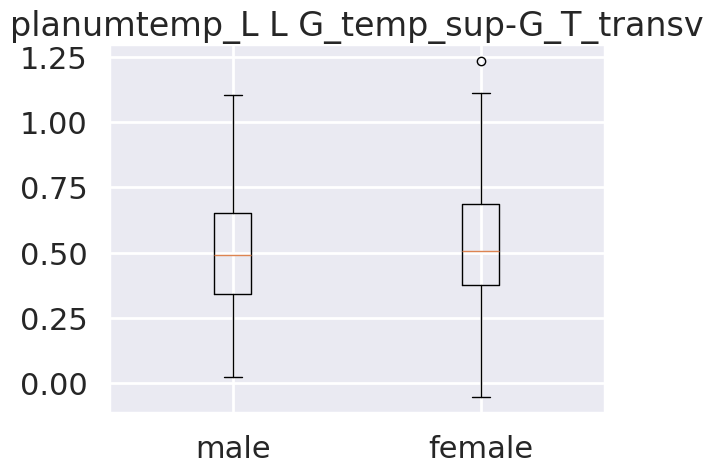

TtestResult(statistic=-1.4668185003241871, pvalue=0.14313335384135575, df=444.0)
male mean : 0.5018071829409091
male std : 0.20832682318354168
female mean : 0.5310863339823009
female std : 0.21217003655662306


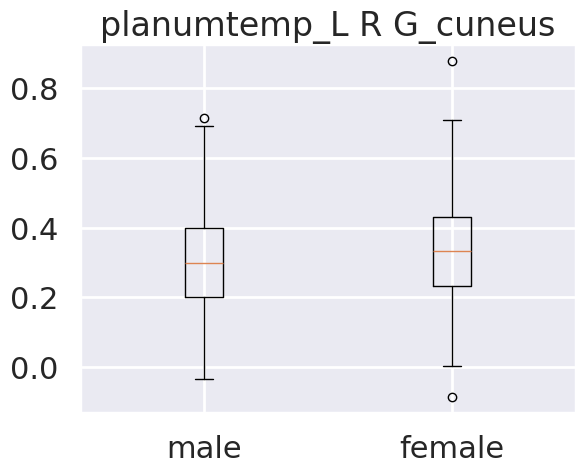

TtestResult(statistic=-1.900338345667161, pvalue=0.05803620626965391, df=444.0)
male mean : 0.31072007482090913
male std : 0.15283367474983472
female mean : 0.33769497466
female std : 0.1462581791438839


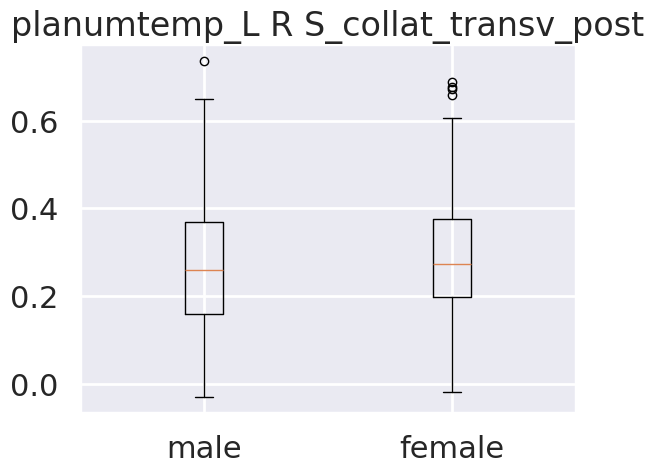

TtestResult(statistic=-1.2885811367529667, pvalue=0.19821477752458558, df=444.0)
male mean : 0.2709323726786364
male std : 0.14640792332179248
female mean : 0.2883145776778761
female std : 0.13779124907038082


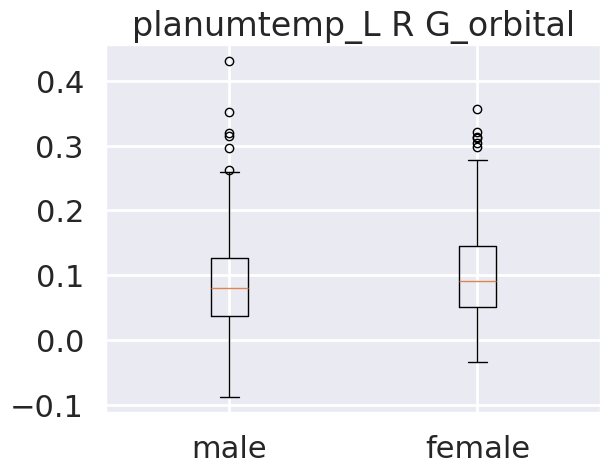

TtestResult(statistic=-2.407555752684538, pvalue=0.016466695302395, df=444.0)
male mean : 0.08842181549768181
male std : 0.07633133167037039
female mean : 0.1060652075022124
female std : 0.07804000323160226


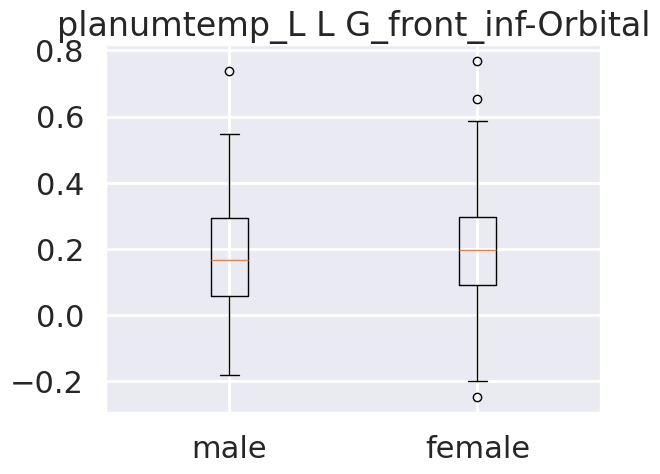

TtestResult(statistic=-2.1409547777015008, pvalue=0.03282159910430519, df=444.0)
male mean : 0.17877056908063638
male std : 0.15695543657924957
female mean : 0.21092954172433626
female std : 0.1594809388139367
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [49]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_R validation accuracy

Validation accuracy
The mean accuracy : 0.6838366071428571
The standard deviation of the accuracy : 0.029771067814148736
The lower boundry of the confidance interval of the accuracy : 0.6254853142271256
The upper boundry of the confidance interval of the accuracy : 0.7421879000585886

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            42.7696  19.2304
Homme            16.1799  33.8201
Mean sensitivity : 0.7264799844052217 Std sensitivity : 0.03144984209708888
Mean specificity : 0.6385426848610832 Std specificity : 0.03423834160899033

Testing accuracy
     coefficient          seed                       labels
72      0.223593  planumtemp_R             L S_temporal_sup
60      0.222028  planumtemp_R  L S_oc-temp_med_and_Lingual
47      0.216804  planumtemp_R      L S_circular_insula_inf
108     0.211511  planumtemp_R      R G_temp_sup-Plan_polar
121     0.186898  planumtemp_R      R S_circular_insula_inf
145     0.171646  plan

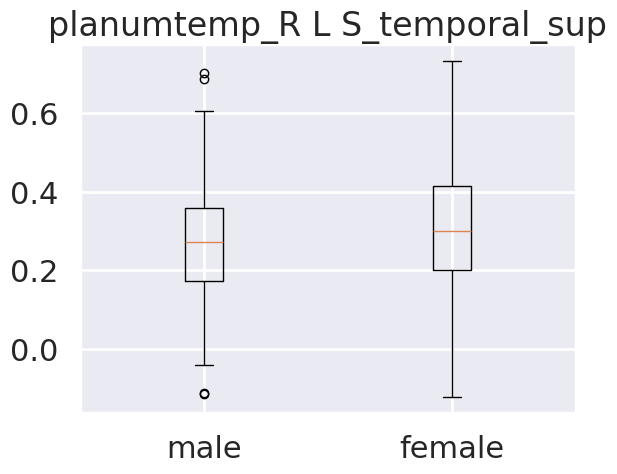

TtestResult(statistic=-2.172356284931162, pvalue=0.030357185275805373, df=444.0)
male mean : 0.27633841454636365
male std : 0.14512470431564756
female mean : 0.30718911921725667
female std : 0.1538477563553037


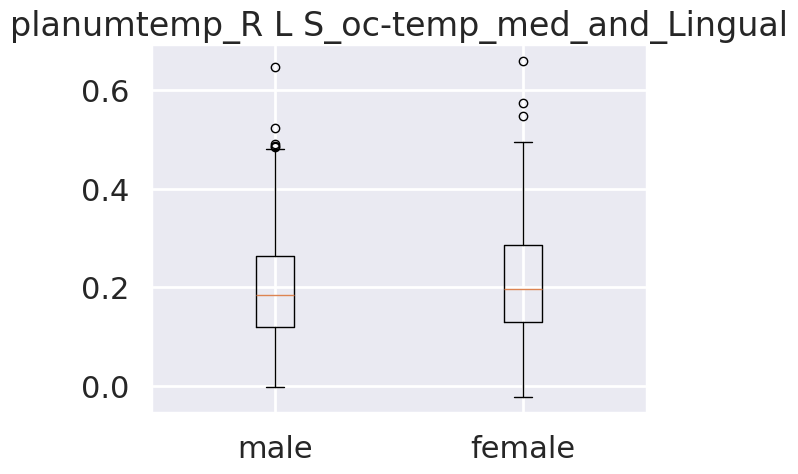

TtestResult(statistic=-1.0159299959681865, pvalue=0.3102159985538084, df=444.0)
male mean : 0.20269651011909093
male std : 0.11495529841844726
female mean : 0.21379863235238938
female std : 0.11528722128116595


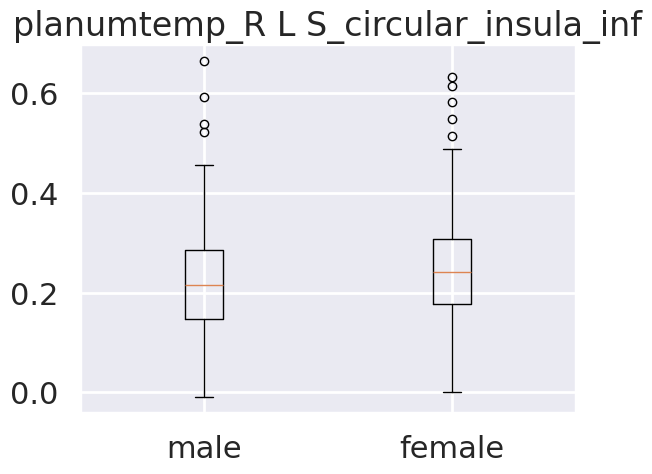

TtestResult(statistic=-2.2460869193139676, pvalue=0.025189374163642184, df=444.0)
male mean : 0.22351656927727273
male std : 0.10774760872380111
female mean : 0.24653169102477876
female std : 0.10813992547660102


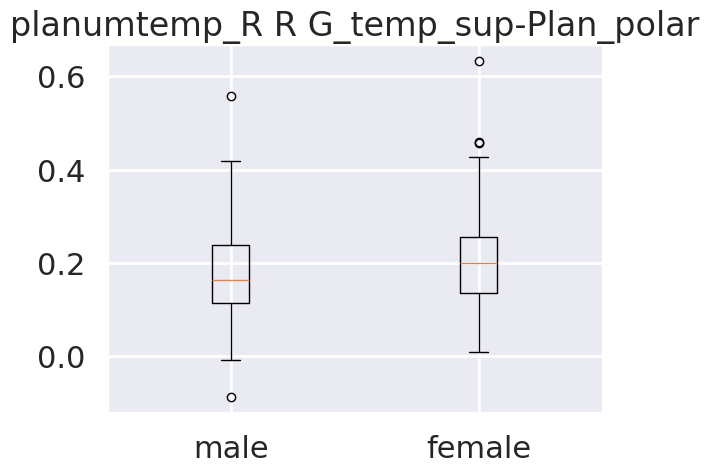

TtestResult(statistic=-2.406845999403157, pvalue=0.01649830662001579, df=444.0)
male mean : 0.1805098378272727
male std : 0.09410146156569885
female mean : 0.20217074238495575
female std : 0.09549310646966955


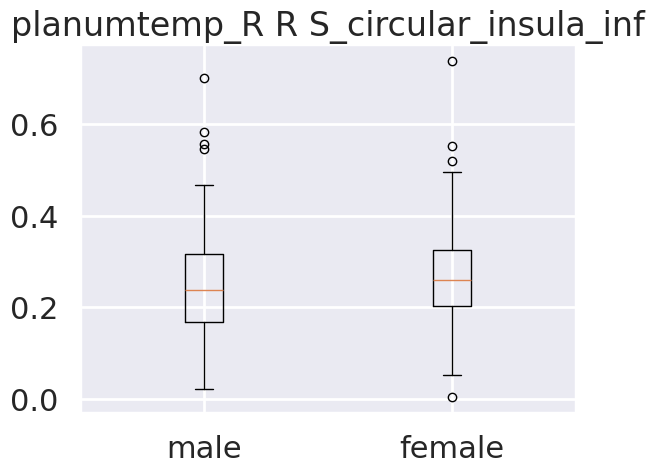

TtestResult(statistic=-2.0551114407020297, pvalue=0.040452724122837666, df=444.0)
male mean : 0.24660752485909096
male std : 0.10393322295402709
female mean : 0.2670182479539823
female std : 0.10529864189491507


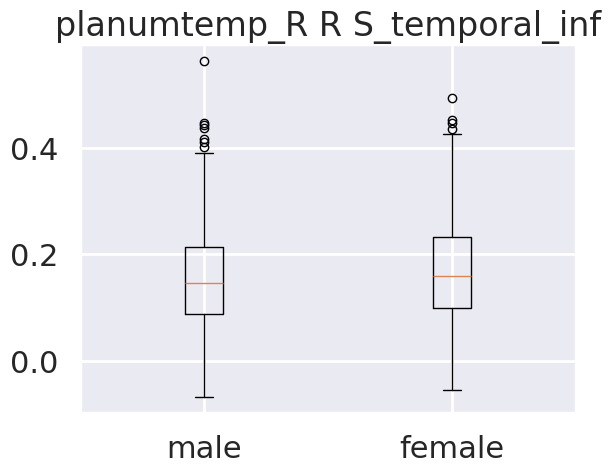

TtestResult(statistic=-0.9513634338765583, pvalue=0.3419375048418646, df=444.0)
male mean : 0.16194760387318183
male std : 0.10372482260491454
female mean : 0.1712123991
female std : 0.10147619169342245


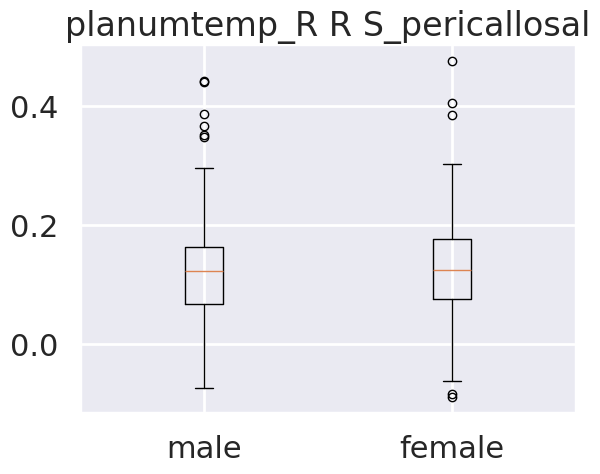

TtestResult(statistic=-0.04409450810520766, pvalue=0.964848893919676, df=444.0)
male mean : 0.12771739776227273
male std : 0.0836279631101089
female mean : 0.1280632141880531
female std : 0.08162612465870656


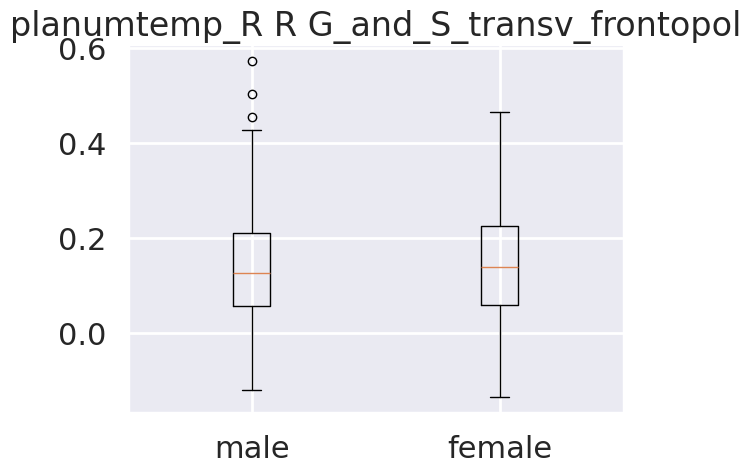

TtestResult(statistic=-0.8669063923595726, pvalue=0.3864615470203151, df=444.0)
male mean : 0.13518558467581818
male std : 0.12424049578100028
female mean : 0.14525303942876105
female std : 0.12046183552074693


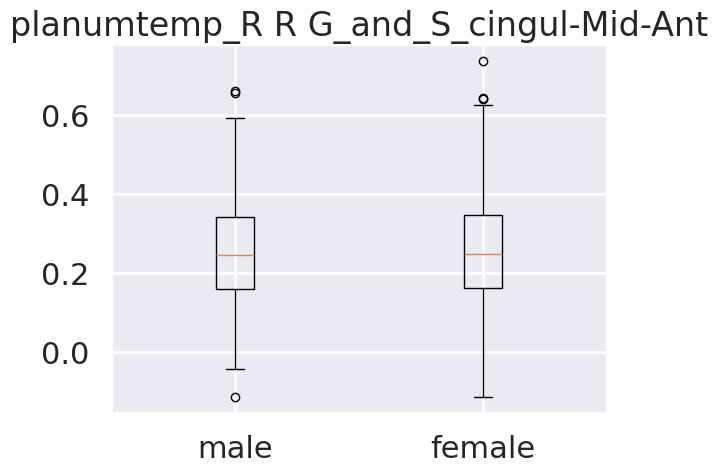

TtestResult(statistic=-0.4779030126905026, pvalue=0.6329544332768726, df=444.0)
male mean : 0.25491982690000003
male std : 0.12856250633529281
female mean : 0.2609543063654867
female std : 0.13722323913395632


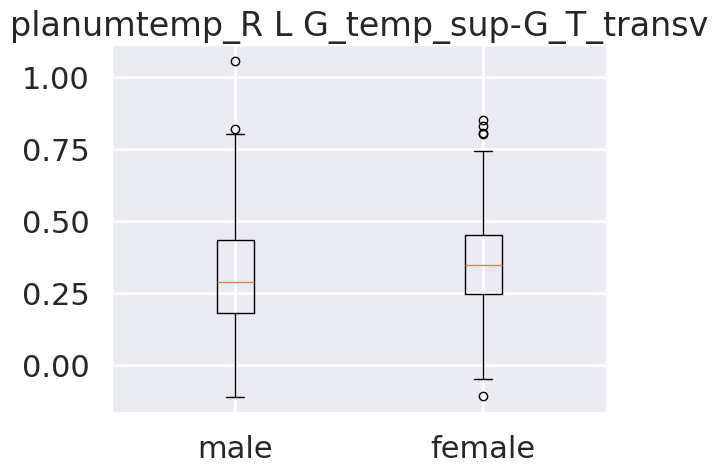

TtestResult(statistic=-2.177816719879876, pvalue=0.0299453400588716, df=444.0)
male mean : 0.31751137780909083
male std : 0.17149302594530139
female mean : 0.3530555233199115
female std : 0.17236777072811232
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [50]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all left validation accuracy

Validation accuracy
The mean accuracy : 0.75559375
The standard deviation of the accuracy : 0.026942987316356307
The lower boundry of the confidance interval of the accuracy : 0.7027854948599416
The upper boundry of the confidance interval of the accuracy : 0.8084020051400583

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            47.7919  14.2081
Homme            13.1654  36.8346
Mean sensitivity : 0.7850700083745575 Std sensitivity : 0.030690791591861763
Mean specificity : 0.7226240457361631 Std specificity : 0.032920324944387444

Testing accuracy
     coefficient          seed                       labels
53      0.123777       opIFG_L                L S_front_sup
98      0.113710       opIFG_L       R G_pariet_inf-Angular
351     0.105832        aMTG_L  L S_intrapariet_and_P_trans
421     0.105135        aMTG_L                R S_front_inf
322     0.103736        aMTG_L             L G_parietal_sup
305     0.100285        aMTG

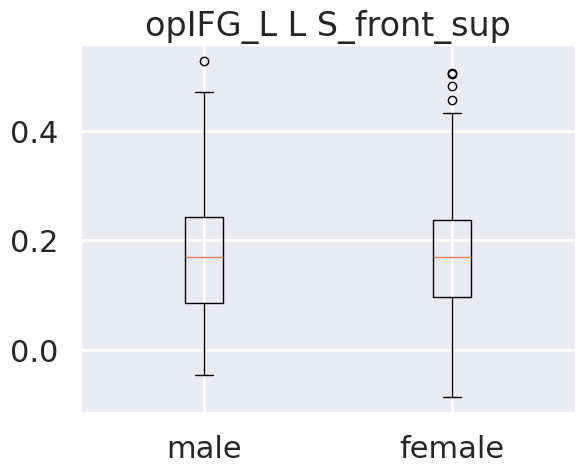

TtestResult(statistic=0.16750658280997677, pvalue=0.8670477340134027, df=444.0)
male mean : 0.17420680631400912
male std : 0.11912401318414584
female mean : 0.17235148060190264
female std : 0.11425827299617537


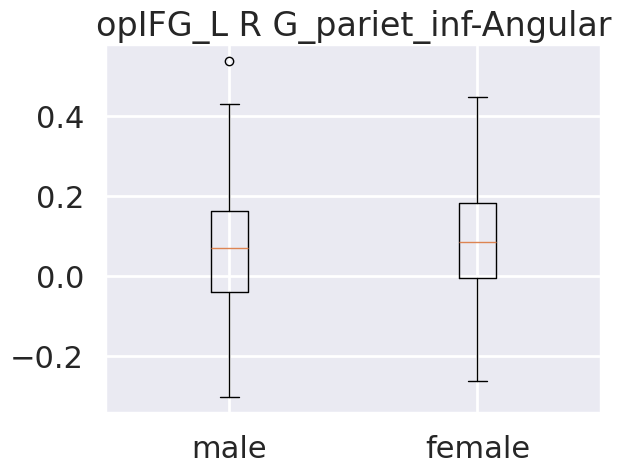

TtestResult(statistic=-1.2837042805959493, pvalue=0.199914972641604, df=444.0)
male mean : 0.07028634473590908
male std : 0.14273980163318048
female mean : 0.08705700692035398
female std : 0.13246296008577768


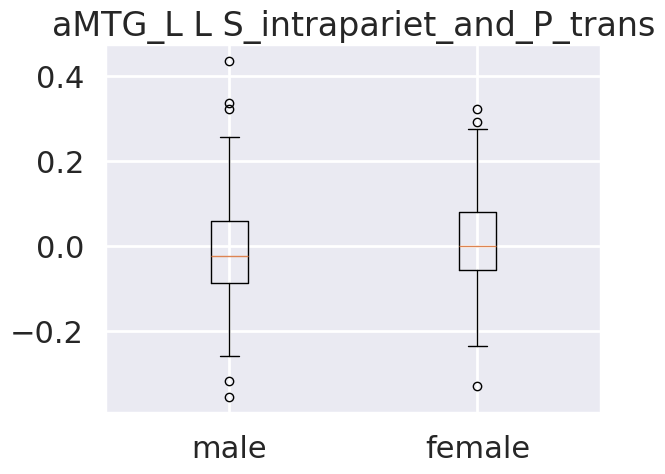

TtestResult(statistic=-2.1882039400431994, pvalue=0.02917519005188522, df=444.0)
male mean : -0.013163690943181816
male std : 0.11543664057625902
female mean : 0.01028722880575221
female std : 0.11037489457068743


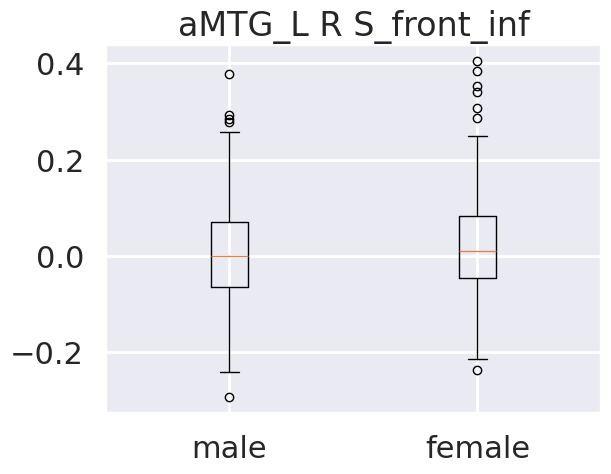

TtestResult(statistic=-1.3466607734060878, pvalue=0.17877651125344068, df=444.0)
male mean : 0.007340951230286363
male std : 0.11529808759000482
female mean : 0.02184227221641593
female std : 0.1116043211309179


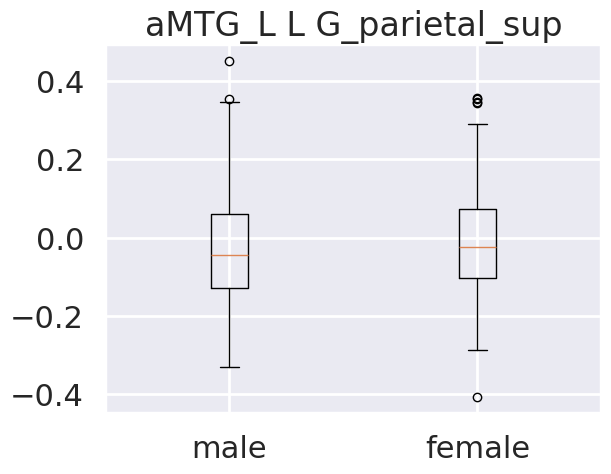

TtestResult(statistic=-1.5379515105784411, pvalue=0.12477278608563036, df=444.0)
male mean : -0.029085330825909087
male std : 0.13197624079115938
female mean : -0.009459302495796459
female std : 0.13678580452595004


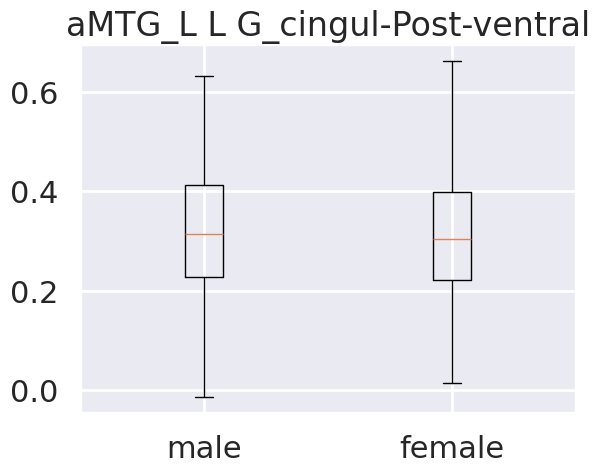

TtestResult(statistic=0.34553641189043366, pvalue=0.729854790212547, df=444.0)
male mean : 0.3196009154818181
male std : 0.12604857929946972
female mean : 0.31531212951327436
female std : 0.13518172022595426


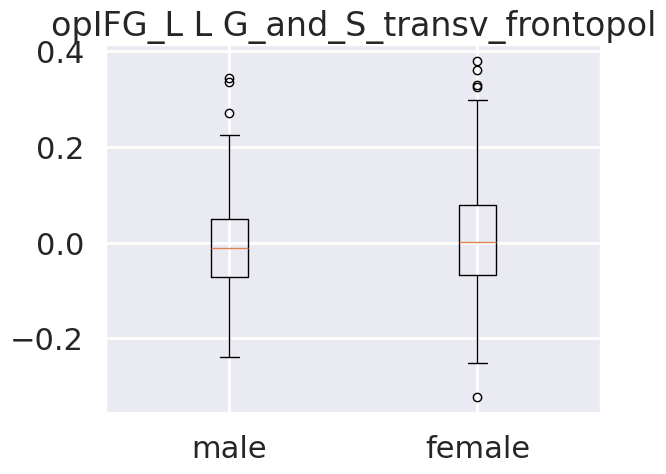

TtestResult(statistic=-1.6356167289057768, pvalue=0.10262849376599101, df=444.0)
male mean : -0.007709291982363636
male std : 0.1025075482709296
female mean : 0.008712956602389379
female std : 0.10885698253664537


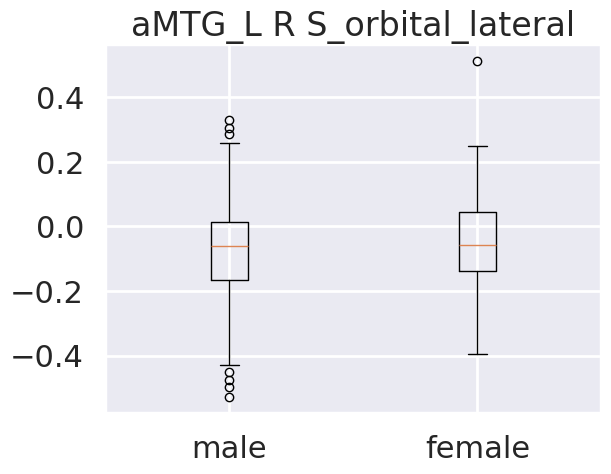

TtestResult(statistic=-1.6077494948748297, pvalue=0.10860088765355616, df=444.0)
male mean : -0.07217302953036363
male std : 0.1506820663019503
female mean : -0.05030928643159292
female std : 0.1356477770331538


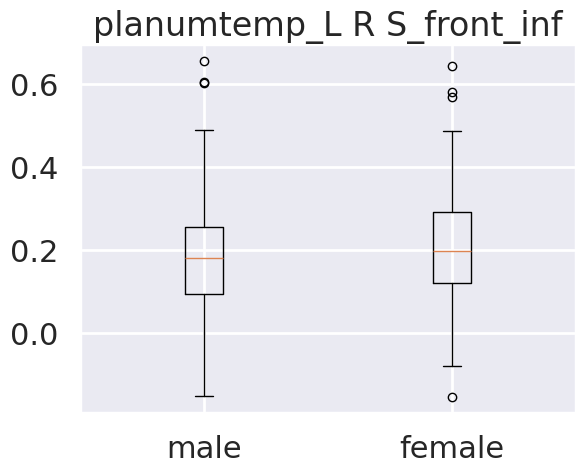

TtestResult(statistic=-1.2266514155103527, pvalue=0.2206037214901718, df=444.0)
male mean : 0.18711039481818184
male std : 0.12783895740344373
female mean : 0.20181205128141594
female std : 0.12470463573844555


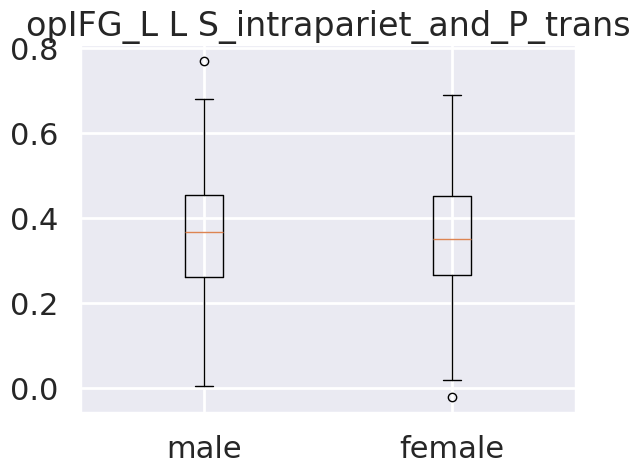

TtestResult(statistic=0.19221994486047625, pvalue=0.8476578062084208, df=444.0)
male mean : 0.3571942989895455
male std : 0.14515971928865637
female mean : 0.3546069050575221
female std : 0.13845782894738395
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [51]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all right validation accuracy

Validation accuracy
The mean accuracy : 0.7362330357142857
The standard deviation of the accuracy : 0.031829129146318316
The lower boundry of the confidance interval of the accuracy : 0.6738479425875018
The upper boundry of the confidance interval of the accuracy : 0.7986181288410695

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            45.7133  16.2867
Homme            13.2552  36.7448
Mean sensitivity : 0.7762417849899873 Std sensitivity : 0.03338493652086484
Mean specificity : 0.6944463175452116 Std specificity : 0.038964230378200966

Testing accuracy
     coefficient          seed                       labels
53      0.134322       opIFG_R                L S_front_sup
66      0.114011       opIFG_R              L S_postcentral
316     0.104480        aMTG_R      L G_oc-temp_lat-fusifor
55      0.103655       opIFG_R  L S_intrapariet_and_P_trans
421     0.103610        aMTG_R                R S_front_inf
379     0.094846     

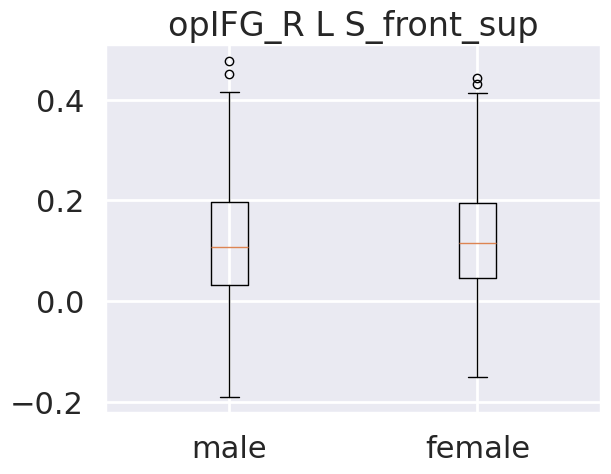

TtestResult(statistic=-0.49469205156348806, pvalue=0.6210622010022258, df=444.0)
male mean : 0.11438509766590908
male std : 0.11569996582668442
female mean : 0.11971639161323011
female std : 0.11138190375990466


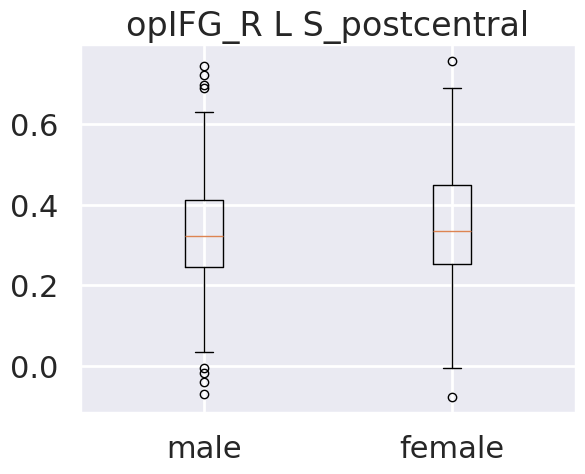

TtestResult(statistic=-1.5134767344652102, pvalue=0.1308700847985047, df=444.0)
male mean : 0.3258257002272727
male std : 0.14180478065118654
female mean : 0.34564355757079646
female std : 0.1340791841028081


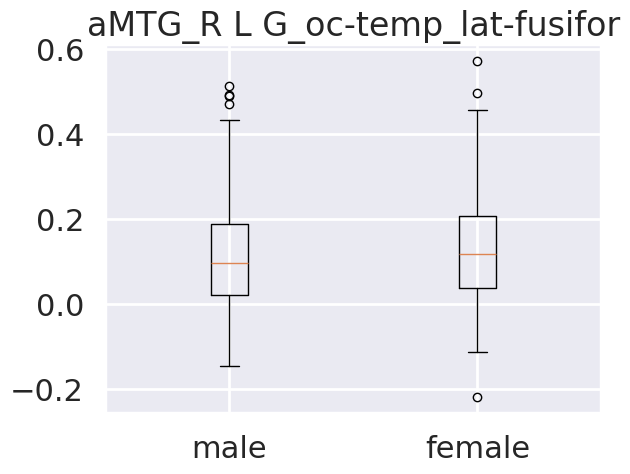

TtestResult(statistic=-1.563746517589469, pvalue=0.11858954017913889, df=444.0)
male mean : 0.11166784292409092
male std : 0.12597983349650443
female mean : 0.13039172499338797
female std : 0.12629509016875493


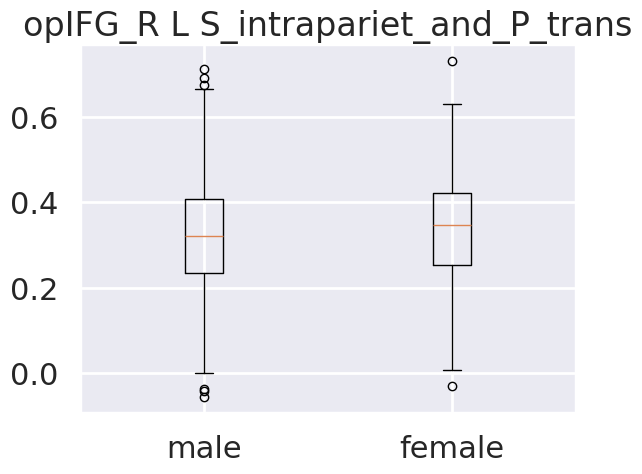

TtestResult(statistic=-1.028947382484815, pvalue=0.3040645972800323, df=444.0)
male mean : 0.32604467616681826
male std : 0.14000133717163324
female mean : 0.33911870171681413
female std : 0.1275901463336887


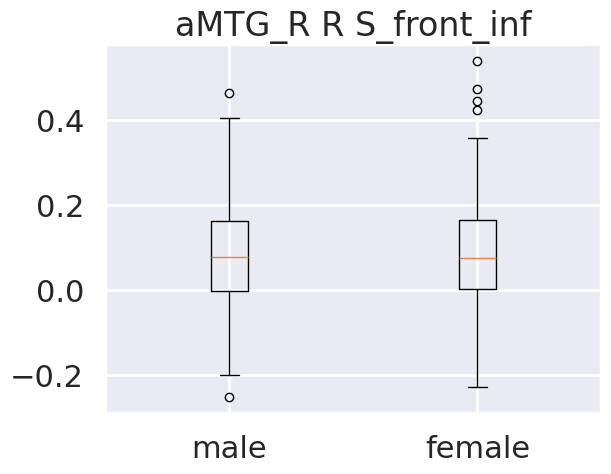

TtestResult(statistic=-0.48958457989788506, pvalue=0.624669681280446, df=444.0)
male mean : 0.0814598112240909
male std : 0.12317350000074088
female mean : 0.08729712538495575
female std : 0.12792789713722574


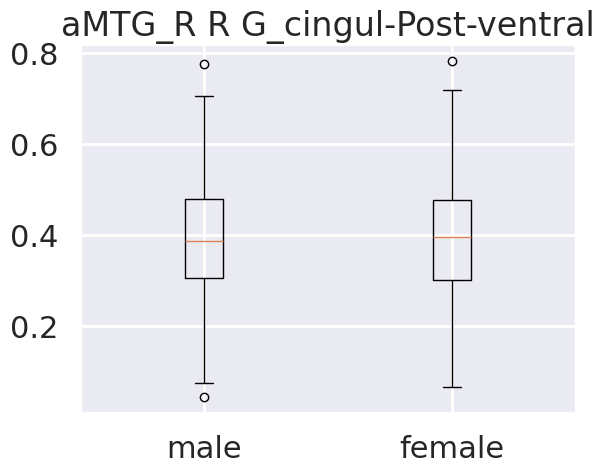

TtestResult(statistic=0.2776949290044926, pvalue=0.781375809933653, df=444.0)
male mean : 0.3881205236772728
male std : 0.13134559747607832
female mean : 0.38453581573451323
female std : 0.14036419082013046


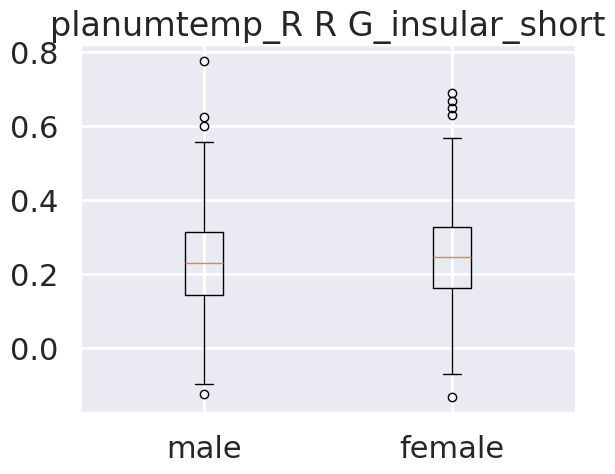

TtestResult(statistic=-1.1435771343888999, pvalue=0.2534152393412931, df=444.0)
male mean : 0.23920570924454546
male std : 0.13547139173095216
female mean : 0.2543955363336283
female std : 0.14413703415135468


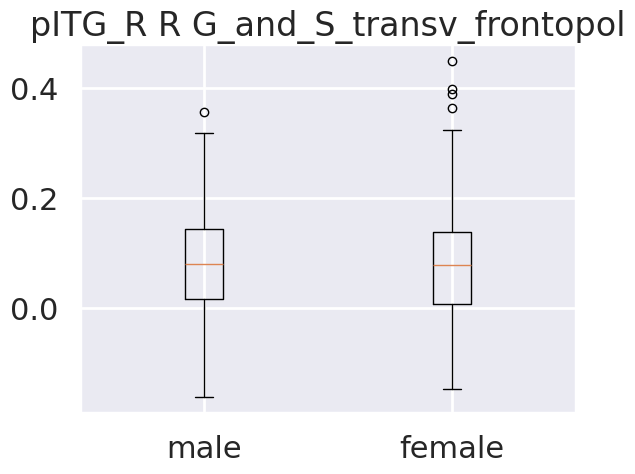

TtestResult(statistic=-0.7355816691832865, pvalue=0.4623737101262553, df=444.0)
male mean : 0.07671445946590906
male std : 0.09147551379327583
female mean : 0.08344172728318584
female std : 0.10085998649060324


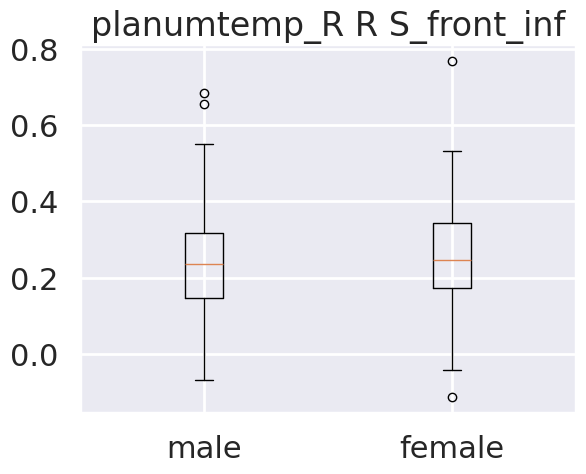

TtestResult(statistic=-1.1677646272379243, pvalue=0.24352841936819117, df=444.0)
male mean : 0.23580405927727274
male std : 0.12767445041669626
female mean : 0.24973693299557523
female std : 0.12373163734468698


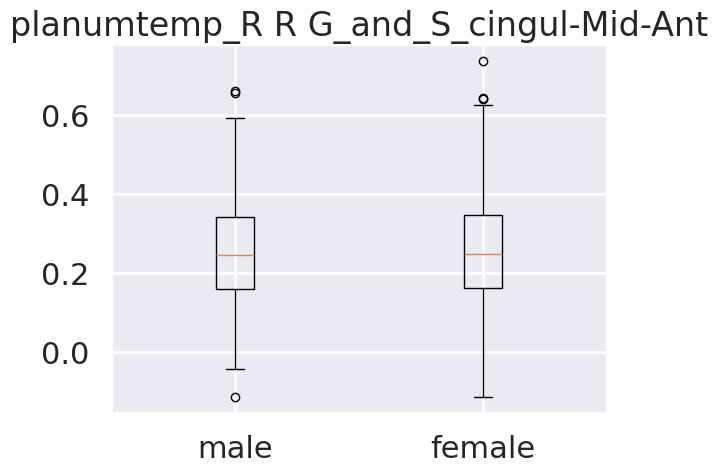

TtestResult(statistic=-0.4779030126905026, pvalue=0.6329544332768726, df=444.0)
male mean : 0.25491982690000003
male std : 0.12856250633529281
female mean : 0.2609543063654867
female std : 0.13722323913395632
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [52]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Test classification feature by feature on an independent set

In [53]:
# 53      0.071670       opIFG_L                L S_front_sup
# 98      0.068736       opIFG_L       R G_pariet_inf-Angular
# 305     0.067573        aMTG_L      L G_cingul-Post-ventral
# 4       0.062202       opIFG_L   L G_and_S_transv_frontopol
# 351     0.061009        aMTG_L  L S_intrapariet_and_P_trans
# 379     0.055271        aMTG_L      R G_cingul-Post-ventral
# 421     0.054923        aMTG_L                R S_front_inf
# 189     0.053367  planumtemp_L             L Pole_occipital
# 301     0.052666        aMTG_L         L G_and_S_cingul-Ant
# 431     0.051921        aMTG_L          R S_orbital_lateral

# the best feature (seed and their region)
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L" , "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
         "L_Pole_occipital",
         "L_G_and_S_cingul-Ant",
         "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")

x = []
y = []
for i in range(0, 1):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["Subject"]:
        sub_sex = Final_df.loc[Final_df["Subject"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    model = machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L L_S_front_sup
train: 356 test: 90
[array([0.61111111, 0.66666667, 0.44444444, 0.77777778, 0.72222222,
       0.5       , 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.55555556, 0.66666667, 0.77777778, 0.66666667, 0.55555556,
       0.66666667, 0.58823529, 0.88235294, 0.70588235, 0.64705882])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               11     33
accuracy test (r2) = 0.6666666666666666
accuracy train (r2) = 0.651685393258427




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

## Validation set

In [54]:
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L" , "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
         "L_Pole_occipital",
         "L_G_and_S_cingul-Ant",
         "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_validation.csv")

for i in range(0, 1):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    Final_df["Unnamed: 0"] = Final_df["Subject"].apply(lambda x : "sub-"+str(x))
    loaded = loaded[loaded["Unnamed: 0"].isin(Final_df["Unnamed: 0"])]
    signal = loaded[seeds[i]+"__"+regions[i]]
    acc = 0
    for index, row in loaded.iterrows():
        real = Final_df[Final_df["Unnamed: 0"] == row["Unnamed: 0"]]["Gender"].values[0]
        prediction = model["model"].predict([[row[seeds[i]+"__"+regions[i]]]])[0]
        if real == prediction:
            acc += 1
    print("Accuracy for the prediction on the validation set with the " +seeds[i]+"__"+regions[i]+" pair: " + str(acc/len(loaded)))

Accuracy for the prediction on the validation set with the opIFG_L__L_S_front_sup pair: 0.5714285714285714


## Mean AUC

In [55]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

In [56]:
# auc test
auc = data_results["auc_test"]
auc_test = np.asarray(auc)
moy = np.mean(auc_test)
se = np.std(auc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)

print("The mean AUC : " + str(moy))
print("The standard deviation of the AUC : " + str(se))
print("The lower boundry of the confidance interval of the AUC : " + str(lower))
print("The upper boundry of the confidance interval of the AUC : " + str(upper))

The mean AUC : 0.8898486021686349
The standard deviation of the AUC : 0.03540454065129827
The lower boundry of the confidance interval of the AUC : 0.8204557024920903
The upper boundry of the confidance interval of the AUC : 0.9592415018451795


In [57]:
# auc validation
auc = data_results["auc_validation"]
auc_test = np.asarray(auc)
moy = np.mean(auc_test)
se = np.std(auc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)

print("The mean AUC : " + str(moy))
print("The standard deviation of the AUC : " + str(se))
print("The lower boundry of the confidance interval of the AUC : " + str(lower))
print("The upper boundry of the confidance interval of the AUC : " + str(upper))

The mean AUC : 0.7361036451612903
The standard deviation of the AUC : 0.03184192209552957
The lower boundry of the confidance interval of the AUC : 0.6736934778540524
The upper boundry of the confidance interval of the AUC : 0.7985138124685283


# Validation bootstrapping

In [62]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/results_test_validation_2024-12-09/LinearSVC/')
results_all_seeds = study_dir / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_aMTG_L = study_dir /  "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_opIFG_L = study_dir / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
resutls_planumtemp_L = study_dir / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

In [63]:
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L)

In [65]:
# aMTG_L L_G_and_S_cingul_Ant
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_G_and_S_cingul_Ant")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_G_and_S_cingul_Ant
predicted class    Femme    Homme
actual class                     
Femme            38.2316   7.4062
Homme             8.7749  35.5873
Sensitivity : 0.8133258166423792
Specificity : 0.8277367509042065
mean Accuracy train : 0.9232578651685394
mean Accuracy test : 0.8202100000000002


In [18]:
# aMTG_L L_G_cingul_Postventral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_L_G_cingul_Postventral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_G_cingul_Postventral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_G_cingul_Postventral
predicted class  Femme  Homme
actual class                 
Femme             28.0   18.0
Homme             21.0   23.0
Sensitivity : 0.5714285714285714
Specificity : 0.5609756097560976
mean Accuracy train : 0.5421348314606743
mean Accuracy test : 0.5666666666666665


In [19]:
# aMTG_L L_S_intrapariet_and_P_trans
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_L_S_intrapariet_and_P_trans)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_S_intrapariet_and_P_trans")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_S_intrapariet_and_P_trans
predicted class  Femme  Homme
actual class                 
Femme             35.0   11.0
Homme             28.0   16.0
Sensitivity : 0.5555555555555556
Specificity : 0.5925925925925926
mean Accuracy train : 0.547752808988764
mean Accuracy test : 0.5666666666666665


In [20]:
# aMTG_L R_G_cingul_Post_ventral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_G_cingul_Post_ventral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_G_cingul_Post_ventral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_G_cingul_Post_ventral
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             23.0   21.0
Sensitivity : 0.5306122448979592
Specificity : 0.5121951219512195
mean Accuracy train : 0.5224719101123598
mean Accuracy test : 0.5222222222222223


In [21]:
# aMTG_L R_S_front_inf
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_S_front_inf)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_S_front_inf")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_S_front_inf
predicted class   Femme   Homme
actual class                   
Femme            23.003  22.997
Homme            26.000  18.000
Sensitivity : 0.4694202395771687
Specificity : 0.4390565163304632
mean Accuracy train : 0.539325842696629
mean Accuracy test : 0.45558888888888893


In [22]:
# aMTG_L R_S_orbital_lateral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_S_orbital_lateral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_S_orbital_lateral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_S_orbital_lateral
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             28.0   16.0
Sensitivity : 0.48148148148148145
Specificity : 0.4444444444444444
mean Accuracy train : 0.5140449438202248
mean Accuracy test : 0.4666666666666667


In [23]:
# opIFG_L L_G_and_S_transv_frontopol
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_L_G_and_S_transv_frontopol)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("opIFG_L L_G_and_S_transv_frontopol")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

opIFG_L L_G_and_S_transv_frontopol
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             15.0   29.0
Sensitivity : 0.6341463414634146
Specificity : 0.5918367346938775
mean Accuracy train : 0.5786682584269663
mean Accuracy test : 0.6111111111111109


In [24]:
# opIFG_L L_S_front_sup
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_L_S_front_sup)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("results_opIFG_L_L_S_front_sup")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

results_opIFG_L_L_S_front_sup
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             11.0   33.0
Sensitivity : 0.7105263157894737
Specificity : 0.6346153846153846
mean Accuracy train : 0.6516853932584271
mean Accuracy test : 0.6666666666666665


In [25]:
# opIFG_L R_G_pariet_inf_Angular
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_R_G_pariet_inf_Angular)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("opIFG_L R_G_pariet_inf_Angular")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

opIFG_L R_G_pariet_inf_Angular
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             13.0   31.0
Sensitivity : 0.675
Specificity : 0.62
mean Accuracy train : 0.6320224719101122
mean Accuracy test : 0.6444444444444445


In [26]:
# planumtemp_L L_Pole_occipital
moyenne, scoresZ, pvalue, data_results = compute_results(resutls_planumtemp_L_L_Pole_occipital)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("planumtemp_L L_Pole_occipital")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

planumtemp_L L_Pole_occipital
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             19.0   25.0
Sensitivity : 0.5869565217391305
Specificity : 0.5681818181818182
mean Accuracy train : 0.539325842696629
mean Accuracy test : 0.5777777777777775
